## CLEANING

### Notebook structure

[1. Checking for sources on participant demographic information and diagnosis](#demog)   
- rectifying missing values in columns gender, race, ethnicity, marital status, age, ...
- assessing information sources

[2. Neuropsychological tests - cleaning](#tests)  
- removing irrelevant columns and preparing each test dataset for exploration and visualization in the notebook EDA.ipynb


In [1]:
# Importing libraries.

import pandas as pd
import numpy as np
import math

import datetime as dt
from datetime import date, timedelta

import plotly 
import plotly.express as px
import seaborn as sns

from pandas.api.types import CategoricalDtype
from sklearn import preprocessing

import glob

# from scipy.cluster.hierarchy import fastcluster

import missingno as msno # to identify and visualize missing data prior to ML

## <a id="demog">1. Checking for sources on participant demographic information and diagnosis</a>    

There are 5 neuropsychological tests that we want to anlayze:    
- **Clinical Dementia Rating (CDR)**   
- **Geriatric Depression Scale (GDS)**   
- **Mini Mental State Examination (MMSE)**    
- **Neuropsychological Battery Tests (NEUROBAT)**    
- **Montreal Cognitive Assessment (MoCA)**    

The test datasets contain the participants' scores and **no** demographic information.

Ideally, we would like to investigate the relationship between the test scores and other independent variables, such as participants' age, gender, ethnicity, etc. We would also like to check the correlation of several variables with the participant's diagnosis.

To achieve this, we want to examine the dataframe with the **demographic information**, so we can freely merge its columns with the test datasets as needed. 

The purpose is to obtain: **gender, year of birth, marital status, education, ethnicity, race, diagnosis**, and other relevant information.

Since the ADNI database has grown organically with each ADNI phase over the last 17 years, it exhibits a complex structure and the data is scattered over several tables. To gain some insight, we will need to analyze additional files to obtain background information as well as augment our data with exam dates and demographics info:
- PTDEMOG.csv (*demographics*)
- REGISTRY.csv (*phases, exam dates and codes*)
- ADNIMERGE.csv (*selected data over all ADNI phases: ADNI1, ADNI2, ADNIGO, ADNI3 merged*) 
- DXSUM_PDXCONV_ADNIALL.csv (*diagnostic information*)

We will inspect these files in advance so that when we merge selected columns to test tables we will know for sure that resulting NaN values cannot be obtained or inferred.


### Demographics (gender, education, work history, ethnicity, etc.)

In [2]:
# PTDEMOG data dictionary.
demog_dict = pd.read_csv('../../data/tabular_data/PTDEMOG_dict.csv')
demog_dict.style.set_properties(**{'text-align': 'left'}).hide_index()
# demog_dict

ID,"""Record ID"""
RID,"""Participant roster ID"""
SITEID,"""Site ID"""
VISCODE,"""Visit code"""
VISCODE2,"""Translated visit code: longutudinal progression"""
USERDATE,"""Date record created"""
USERDATE2,"""Date record last updated"""
PTSOURCE,"""Information Source: 1=Participant Visit;2=Telephone Call"""
PTGENDER,"""Participant Gender: 1=Male; 2=Female"""
PTDOBMM,"""2a. Participant Month of Birth; 1..12"""
PTDOBYY,"""2b. Participant Year of Birth; 1900..1980"""


#### Examining the demographic data

In [3]:
# Cohort demography, partial: PTDEMOG.csv
df = pd.read_csv('../../data/tabular_data/PTDEMOG.csv')
df.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,PTSOURCE,PTGENDER,...,PTTLANG,PTPLANG,PTPSPEC,PTCOGBEG,PTMCIBEG,PTADBEG,PTADDX,PTETHCAT,PTRACCAT,update_stamp
0,ADNI1,18,2,107,sc,sc,2005-08-17,NaN,1,1.0,...,1.0,1.0,-4,NaN,NaN,-4.0,NaN,2.0,5.0,2005-08-17 00:00:00.0
1,ADNI1,20,1,10,f,f,2005-08-18,NaN,1,2.0,...,-4.0,-4.0,-4,NaN,NaN,-4.0,NaN,-4.0,-4.0,2005-08-18 00:00:00.0
2,ADNI1,22,3,107,sc,sc,2005-08-18,NaN,1,1.0,...,1.0,1.0,-4,NaN,NaN,1999.0,NaN,2.0,5.0,2005-08-18 00:00:00.0
3,ADNI1,24,4,10,sc,sc,2005-08-18,NaN,1,1.0,...,2.0,2.0,-4,NaN,NaN,-4.0,NaN,1.0,5.0,2005-08-18 00:00:00.0
4,ADNI1,26,5,107,sc,sc,2005-08-23,NaN,1,1.0,...,1.0,1.0,-4,NaN,NaN,-4.0,NaN,2.0,5.0,2005-08-23 00:00:00.0


In [4]:
df.replace('-1', np.NaN)
df.replace('-4', np.NaN)
df.replace(-1, np.NaN)
df.replace(-4, np.NaN)

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,PTSOURCE,PTGENDER,...,PTTLANG,PTPLANG,PTPSPEC,PTCOGBEG,PTMCIBEG,PTADBEG,PTADDX,PTETHCAT,PTRACCAT,update_stamp
0,ADNI1,18,2,107,sc,sc,2005-08-17,NaN,1,1.0,...,1.0,1.0,-4,NaN,NaN,NaN,NaN,2.0,5.0,2005-08-17 00:00:00.0
1,ADNI1,20,1,10,f,f,2005-08-18,NaN,1,2.0,...,NaN,NaN,-4,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
2,ADNI1,22,3,107,sc,sc,2005-08-18,NaN,1,1.0,...,1.0,1.0,-4,NaN,NaN,1999.0,NaN,2.0,5.0,2005-08-18 00:00:00.0
3,ADNI1,24,4,10,sc,sc,2005-08-18,NaN,1,1.0,...,2.0,2.0,-4,NaN,NaN,NaN,NaN,1.0,5.0,2005-08-18 00:00:00.0
4,ADNI1,26,5,107,sc,sc,2005-08-23,NaN,1,1.0,...,1.0,1.0,-4,NaN,NaN,NaN,NaN,2.0,5.0,2005-08-23 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711,ADNI3,137823,6970,10,sc,sc,2021-07-15,2021-07-15,1,1.0,...,1.0,1.0,NaN,2014.0,NaN,NaN,9999.0,2.0,5.0,2021-07-16 04:20:15.0
4712,ADNI3,137912,6968,36,sc,sc,2021-07-16,2021-07-16,1,2.0,...,1.0,1.0,NaN,2011.0,NaN,NaN,9999.0,2.0,5.0,2021-07-17 04:19:31.0
4713,ADNI3,138213,6963,27,sc,sc,2021-07-21,2021-07-21,1,2.0,...,1.0,1.0,NaN,9999.0,NaN,NaN,9999.0,2.0,4.0,2021-07-21 04:19:29.0
4714,ADNI3,138453,6949,12,sc,NaN,2021-07-26,2021-07-26,1,2.0,...,2.0,2.0,NaN,2018.0,NaN,NaN,9999.0,1.0,5.0,2021-07-27 04:19:33.0


In [5]:
df.shape

(4716, 32)

In [6]:
# No. of entries to start with.
dem_start_entries = df.shape[0]

In [7]:
df.isnull().sum()

Phase              0
ID                 0
RID                0
SITEID             0
VISCODE            0
VISCODE2           3
USERDATE           0
USERDATE2       3158
PTSOURCE           0
PTGENDER         119
PTDOBMM          176
PTDOBYY          176
PTHAND           132
PTMARRY            4
PTEDUCAT         132
PTWORKHS        2318
PTWORK            13
PTWRECNT          24
PTNOTRT           18
PTRTYR           264
PTHOME             8
PTOTHOME         950
PTTLANG          119
PTPLANG          119
PTPSPEC          945
PTCOGBEG        2167
PTMCIBEG        4267
PTADBEG         3204
PTADDX          2181
PTETHCAT         119
PTRACCAT         119
update_stamp       0
dtype: int64

In [8]:
# How many valid entries do we have about the PARTICIPANT's DATE OF DIAGNOSIS?
df['PTADDX'].unique()

array([  nan, 9999., 2007., 2009., 2008., 2010., 2006., 2004., 2011.,
       2005., 1986., 2012., 1999., 1987., 2003., 2017., 2016., 2013.,
       2015., 2014., 1985., 2018., 2019., 2020., 2021.])

In [9]:
# Unique participants
df['RID'].nunique()

3940

In [10]:
# Hidden missing values as 9999:
df['PTADDX'] = df['PTADDX'].replace(9999, np.NaN)

In [11]:
df['PTADDX'].isna().sum()

4308

We have date of AD diagnosis for only about 10% of the participants, it would be hard to draw any valid conclusions on that.

In [12]:
# Beginning of mild cog. impairments, symptoms year.
df['PTMCIBEG'].unique()

array([  nan, 2006., 2005., 2009., 2008., 2007., 1997., 2000., 1996.,
       1999., 1985., 2010., 1993., 2004., 1998., 2002., 1994., 2001.,
       2003., 1995., 1986., 1991., 1990.])

In [13]:
df['PTMCIBEG'].isna().sum()

4267

We have information on cognitive impairment onset for 449/4716 people, which is too small of a number to make any generalizations. As our focus is not so much on development of the disease and survival once you are diagnosed, we might remove these columns to obtain a cleaner dataframe.

In [14]:
# Drop unused columns.
drop_cols = ['USERDATE', 'USERDATE2', 'PTSOURCE', 'PTDOBMM', 'PTWORKHS', 
             'PTWRECNT', 'PTNOTRT', 'PTRTYR', 'PTWORK', 'PTOTHOME', 'PTHOME', 
             'PTTLANG', 'PTPSPEC', 'PTCOGBEG', 'PTMCIBEG', 'PTADBEG', 
             'PTADDX', 'update_stamp']

dem = df.drop(columns=drop_cols, axis=1)
# dem.head()

In [15]:
# Basic information overview.
print('Dataframe shape:', df.shape)
print()
dem.info()

Dataframe shape: (4716, 32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4716 entries, 0 to 4715
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Phase     4716 non-null   object 
 1   ID        4716 non-null   int64  
 2   RID       4716 non-null   int64  
 3   SITEID    4716 non-null   int64  
 4   VISCODE   4716 non-null   object 
 5   VISCODE2  4713 non-null   object 
 6   PTGENDER  4597 non-null   float64
 7   PTDOBYY   4540 non-null   float64
 8   PTHAND    4584 non-null   float64
 9   PTMARRY   4712 non-null   float64
 10  PTEDUCAT  4584 non-null   float64
 11  PTPLANG   4597 non-null   float64
 12  PTETHCAT  4597 non-null   float64
 13  PTRACCAT  4597 non-null   float64
dtypes: float64(8), int64(3), object(3)
memory usage: 515.9+ KB


In [16]:
# Order VISCODE, Phases
dem['Phase'] = dem['Phase'].astype('category')
dem['Phase'] = dem['Phase'].cat.set_categories(['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3'], ordered=True)

dem['VISCODE'] = dem['VISCODE'].astype('category')
dem['VISCODE'] = dem['VISCODE'].cat.set_categories(['sc', 'bl', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48',
                                                  'm54', 'uns1', 'f', 'nv', 'scmri', 'm03', 'm60', 'm66', 'm72', 'm78', 'v01', 'v02',
                                                  'v03', 'v04', 'v05', 'v06', 'v07', 'v11', 'v12', 'v21', 'v22', 'v31',
                                                  'v32', 'v41', 'v42', 'v51', 'v52', 'tau', 'reg', 'init', 'y1', 'y2', 
                                                  'y3', 'y4', 'y5', 'y6'], ordered=True)

We know, that in general, the missing values in ADNI datasets are encoded also with -1 and -4, so we'll change these values to NaN.

In [17]:
dem = dem.replace([-1], 'NaN')
dem = dem.replace([-4], 'NaN')
dem = dem.replace(['-1'], 'NaN')
dem = dem.replace(['-4'], 'NaN')

# Missing VISCODE2
# VISCODE2 = translated VISCODE into month visit for each participant
mv = dem[dem['VISCODE2'].isnull()]
mv

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
4514,ADNI3,90663,6214,42,sc,NaN,2.0,1952.0,1.0,1.0,18.0,1.0,2.0,4.0
4596,ADNI3,109968,6617,10,sc,NaN,2.0,1943.0,NaN,NaN,NaN,1.0,3.0,7.0
4714,ADNI3,138453,6949,12,sc,NaN,2.0,1951.0,1.0,1.0,14.0,2.0,1.0,5.0


In [18]:
dem.at[4514, 'VISCODE2'] = 'sc'
dem.at[4596, 'VISCODE2'] = 'sc'
dem.at[4714, 'VISCODE2'] = 'sc'

dem.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
0,ADNI1,18,2,107,sc,sc,1.0,1931.0,2.0,1.0,16.0,1.0,2.0,5.0
1,ADNI1,20,1,10,f,f,2.0,1944.0,NaN,1.0,18.0,NaN,NaN,NaN
2,ADNI1,22,3,107,sc,sc,1.0,1924.0,1.0,1.0,18.0,1.0,2.0,5.0
3,ADNI1,24,4,10,sc,sc,1.0,1938.0,1.0,1.0,10.0,2.0,1.0,5.0
4,ADNI1,26,5,107,sc,sc,1.0,1931.0,1.0,1.0,16.0,1.0,2.0,5.0


In [19]:
# Drop those who failed screening.
dem = dem[dem.VISCODE != 'f']

In [20]:
dem.isnull().sum()

Phase         0
ID            0
RID           0
SITEID        0
VISCODE       0
VISCODE2      0
PTGENDER    119
PTDOBYY     176
PTHAND      132
PTMARRY       4
PTEDUCAT    132
PTPLANG     119
PTETHCAT    119
PTRACCAT    119
dtype: int64

In [21]:
dem.shape

(4152, 14)

In [22]:
dem[dem['PTDOBYY'].isnull()].sort_values(by = ['Phase', 'RID', 'VISCODE'])

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
1089,ADNI1,2222,23,107,m12,m12,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1397,ADNI1,2878,47,4,m24,m24,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1427,ADNI1,2954,50,94,m36,m36,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1408,ADNI1,2912,88,94,m24,m24,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1402,ADNI1,2898,94,94,m24,m24,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3742,ADNI2,3316,4798,61,v03,bl,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3739,ADNI2,3310,4845,8,v12,m18,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3747,ADNI2,3326,4899,25,v21,m24,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3731,ADNI2,3294,5017,23,v11,m12,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN


In [23]:
# Does a coincidental participant have all YOB missing?
dem[dem['RID'] == 183]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
201,ADNI1,424,183,107,sc,sc,2.0,1933.0,1.0,2.0,14.0,1.0,2.0,5.0
926,ADNI1,1892,183,107,m06,m06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Apparently they entered a participant's data only on the first visit.

In [24]:
dem[dem['RID'] == 88]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
86,ADNI1,194,88,94,sc,sc,1.0,1940.0,1.0,1.0,8.0,1.0,2.0,5.0
1408,ADNI1,2912,88,94,m24,m24,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


They only updated values that change, but ethnicity, gender, education ... are pretty stable demographic characteristics, so it suffices if we keep just the rows with these values entered.

In [25]:
dem = dem.sort_values(by = ['RID', 'Phase', 'VISCODE']).reset_index(drop = True)
dem

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
0,ADNI1,18,2,107,sc,sc,1.0,1931.0,2.0,1.0,16.0,1.0,2.0,5.0
1,ADNIGO,304,2,8,sc,sc,1.0,1931.0,2.0,2.0,16.0,1.0,2.0,5.0
2,ADNI2,636,2,8,v06,m72,1.0,1931.0,2.0,2.0,16.0,1.0,2.0,5.0
3,ADNI1,22,3,107,sc,sc,1.0,1924.0,1.0,1.0,18.0,1.0,2.0,5.0
4,ADNI1,24,4,10,sc,sc,1.0,1938.0,1.0,1.0,10.0,2.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147,ADNI3,137034,6978,16,sc,sc,2.0,1939.0,2.0,2.0,20.0,1.0,2.0,4.0
4148,ADNI3,136902,6979,63,sc,sc,2.0,2021.0,1.0,1.0,14.0,1.0,2.0,4.0
4149,ADNI3,137407,6980,33,sc,sc,1.0,1949.0,1.0,1.0,18.0,1.0,2.0,2.0
4150,ADNI3,137485,6981,63,sc,sc,2.0,1955.0,1.0,1.0,16.0,2.0,1.0,5.0


In [26]:
dem[dem['RID'] == 448]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
459,ADNI1,792,448,1,sc,sc,1.0,1920.0,1.0,1.0,17.0,1.0,2.0,5.0
460,ADNI1,2788,448,1,m12,m12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
461,ADNIGO,1090,448,3,sc,sc,1.0,1920.0,1.0,1.0,17.0,1.0,2.0,5.0
462,ADNIGO,1122,448,3,m48,m48,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
463,ADNI2,1938,448,3,v06,m72,1.0,1920.0,1.0,1.0,17.0,1.0,2.0,5.0


In [27]:
# How many unique individuals? RID is personal ID number. Possible duplicates can be detected.
dem['RID'].nunique()

3376

There are 4716 entries, but only 3940  study participants. Let's check, which participants are entered several times and try to understand why and exclude the possibility of repeated entries.

In [28]:
# Count of each of the distinct values of RID column
repeated = dem.RID.value_counts().sort_values(ascending=False).reset_index()
# rep_RID = repeated.loc[repeated[repeated > 1]].tolist()
repeated = repeated[repeated['RID'] > 1]
repeated.rename(columns = {'index':'RID', 'RID':'count'}, inplace = True)
rids = repeated['RID'].tolist()
# rids

In [29]:
# Check the rows with repeated RIDs
rep_rid = dem[dem.RID.isin(rids)]
rep_rid = rep_rid.sort_values(by = 'RID')
print(rep_rid.shape)
rep_rid.head(12)

(1246, 14)


,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
0,ADNI1,18,2,107,sc,sc,1.0,1931.0,2.0,1.0,16.0,1.0,2.0,5.0
1,ADNIGO,304,2,8,sc,sc,1.0,1931.0,2.0,2.0,16.0,1.0,2.0,5.0
2,ADNI2,636,2,8,v06,m72,1.0,1931.0,2.0,2.0,16.0,1.0,2.0,5.0
8,ADNI1,32,8,107,sc,sc,2.0,1921.0,2.0,2.0,18.0,1.0,2.0,5.0
9,ADNIGO,322,8,8,sc,sc,2.0,1921.0,2.0,2.0,18.0,1.0,2.0,5.0
10,ADNI2,688,8,8,v06,m72,2.0,1921.0,2.0,2.0,18.0,1.0,2.0,5.0
13,ADNI1,46,15,4,sc,sc,1.0,1924.0,1.0,1.0,18.0,1.0,2.0,5.0
14,ADNI2,910,15,40,v06,m72,1.0,1924.0,1.0,1.0,18.0,1.0,2.0,5.0
20,ADNI2,754,21,8,v06,m72,2.0,1933.0,1.0,3.0,18.0,1.0,2.0,4.0
19,ADNIGO,436,21,8,m60,m60,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN


There are no duplicates, it appears we're dealing with participants, who continued through several ADNI phases, so the entries are valid.    

Coincidentally, we also partially solve the the missing values problem (example: participant RID = 21): gender and other columns are not missing at all, they were just not entered for all ADNI phases. Do participants with missing values have these entered at screening?

The ethnic category (PTETHCAT), for example, is important as a 'boolean' value, meaning, if a participant is Hispanic or not. For classification models this is informative, because in the literature we've learned that Hispanic people tend to have a higer risk to get Alzheimer's and they get sick at a younger age.

In [30]:
# Missing values at screening exam.
scr_values = dem[dem.VISCODE.isin(['sc'])]
scr_values.isnull().sum()

Phase        0
ID           0
RID          0
SITEID       0
VISCODE      0
VISCODE2     0
PTGENDER     0
PTDOBYY      0
PTHAND      13
PTMARRY      4
PTEDUCAT     8
PTPLANG      0
PTETHCAT     0
PTRACCAT     0
dtype: int64

Apart from couple of missing values on handedness etc., the df seems to have the values on gender, ethnicity and other more relevant variables, so we will tolerate the few missing values  in 3 columns and handle them if we need the columns later.

In [31]:
dem[dem['RID'] == 183]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
223,ADNI1,424,183,107,sc,sc,2.0,1933.0,1.0,2.0,14.0,1.0,2.0,5.0
224,ADNI1,1892,183,107,m06,m06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
dem[dem['RID'] == 852]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
844,ADNI1,1660,852,19,sc,sc,2.0,1922.0,1.0,4.0,18.0,1.0,2.0,5.0
845,ADNI1,2002,852,19,bl,bl,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


In [33]:
dem.isnull().sum()

Phase         0
ID            0
RID           0
SITEID        0
VISCODE       0
VISCODE2      0
PTGENDER    119
PTDOBYY     176
PTHAND      132
PTMARRY       4
PTEDUCAT    132
PTPLANG     119
PTETHCAT    119
PTRACCAT    119
dtype: int64

In [34]:
# Unknown handiness, encode with 0.
dem['PTHAND'] = dem['PTHAND'].fillna(0)

In [35]:
dem_na = dem[dem.isna().any(axis=1)]
dem_na[dem_na['VISCODE'] == 'sc']

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
3464,ADNI3,40158,6272,62,sc,sc,1.0,1949.0,1.0,NaN,17.0,1.0,2.0,5.0
3515,ADNI3,106477,6324,21,sc,sc,1.0,1957.0,0,1.0,NaN,1.0,2.0,5.0
3578,ADNI3,84367,6387,50,sc,sc,2.0,1954.0,0,NaN,NaN,1.0,2.0,5.0
3625,ADNI3,56372,6435,30,sc,sc,2.0,1953.0,1.0,1.0,NaN,1.0,2.0,5.0
3643,ADNI3,54264,6453,44,sc,sc,1.0,1960.0,0,1.0,NaN,1.0,2.0,5.0
3736,ADNI3,84346,6553,50,sc,sc,2.0,1958.0,0,NaN,NaN,1.0,2.0,5.0
3791,ADNI3,79361,6608,57,sc,sc,1.0,1949.0,0,5.0,NaN,1.0,2.0,7.0
3800,ADNI3,109968,6617,10,sc,sc,2.0,1943.0,0,NaN,NaN,1.0,3.0,7.0
3964,ADNI3,90519,6783,4,sc,sc,2.0,1929.0,1.0,3.0,NaN,1.0,2.0,5.0


In [36]:
dem[dem['RID'] == 4667]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
2578,ADNI2,1800,4667,4,v01,sc,2.0,1944.0,1.0,1.0,NaN,1.0,2.0,5.0


In [37]:
dem_na['RID'].nunique()

177

177/190 rows with missing entries belong to people who have either just enrolled in ADNI3 or have their data in other rows, so we can drop the last missing entries.

In [38]:
dem.isnull().sum()

Phase         0
ID            0
RID           0
SITEID        0
VISCODE       0
VISCODE2      0
PTGENDER    119
PTDOBYY     176
PTHAND        0
PTMARRY       4
PTEDUCAT    132
PTPLANG     119
PTETHCAT    119
PTRACCAT    119
dtype: int64

We still have a couple of missing values, but mostly with participants who have completed only one visit  in 2. or 3. Phase. (We've checked the entries individually with "dem[dem['RID'] == <RID>]"). These participants are probably missing entries in test results, since not many tests were performed in first visit and they can be removed.

In [39]:
print("The oldest participant was born in", dem['PTDOBYY'].min())
print("The youngest participant was born in", dem['PTDOBYY'].max())

The oldest participant was born in 1915.0
The youngest participant was born in 2021.0


Seems we have some erroneous data, where instead of year of birth some other date was noted. We have to check the PTYOBYY column to exclude younger people, since even early onset AD occurs at arround 50 years.

In [40]:
dem[dem['PTDOBYY'] > 1975]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
3668,ADNI3,49597,6478,44,sc,sc,1.0,1994.0,1.0,1.0,17.0,1.0,2.0,5.0
3737,ADNI3,57300,6554,50,sc,sc,1.0,2018.0,1.0,1.0,16.0,1.0,2.0,5.0
3848,ADNI3,72959,6667,57,sc,sc,2.0,2019.0,1.0,1.0,13.0,1.0,2.0,5.0
3963,ADNI3,90809,6782,25,sc,sc,2.0,2019.0,1.0,3.0,16.0,1.0,2.0,4.0
4062,ADNI3,118821,6884,45,sc,sc,2.0,2020.0,1.0,1.0,14.0,1.0,2.0,5.0
4089,ADNI3,128496,6913,25,sc,sc,1.0,2021.0,1.0,1.0,13.0,1.0,2.0,5.0
4132,ADNI3,134836,6960,63,sc,sc,2.0,2021.0,1.0,3.0,20.0,1.0,1.0,7.0
4148,ADNI3,136902,6979,63,sc,sc,2.0,2021.0,1.0,1.0,14.0,1.0,2.0,4.0


They might be normal controls, which can be checked in ADNIMERGE dataframe below. We will keep this entries, but will pay attention when we deal with AD patients.

Now let's check visit codeas and their meaning.

In [41]:
dem['PTDOBYY'].min()

1915.0

In [42]:
dem['PTDOBYY'].max()

2021.0

In [43]:
dem[dem['PTDOBYY'] > 1975]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
3668,ADNI3,49597,6478,44,sc,sc,1.0,1994.0,1.0,1.0,17.0,1.0,2.0,5.0
3737,ADNI3,57300,6554,50,sc,sc,1.0,2018.0,1.0,1.0,16.0,1.0,2.0,5.0
3848,ADNI3,72959,6667,57,sc,sc,2.0,2019.0,1.0,1.0,13.0,1.0,2.0,5.0
3963,ADNI3,90809,6782,25,sc,sc,2.0,2019.0,1.0,3.0,16.0,1.0,2.0,4.0
4062,ADNI3,118821,6884,45,sc,sc,2.0,2020.0,1.0,1.0,14.0,1.0,2.0,5.0
4089,ADNI3,128496,6913,25,sc,sc,1.0,2021.0,1.0,1.0,13.0,1.0,2.0,5.0
4132,ADNI3,134836,6960,63,sc,sc,2.0,2021.0,1.0,3.0,20.0,1.0,1.0,7.0
4148,ADNI3,136902,6979,63,sc,sc,2.0,2021.0,1.0,1.0,14.0,1.0,2.0,4.0


In [44]:
dem['PTEDUCAT'].dtype.name

'object'

In [45]:
# Remove age outliers and uncredible dates of birth.
dem = dem[dem['PTDOBYY'] < 1990]

In [46]:
vis_dict = pd.read_csv('../../data/tabular_data/VISITS.csv')
# vis_dict

In [47]:
vis2 = pd.read_csv('../../data/tabular_data/ADNI2_VISITID.csv')
# vis2

VISCODE2 appears to be longitudinal information about the study progress in months (VISCODE expressed in months).    
However, some discrepancy appears between VISCODE pre- and post- ADNI2 Phase, so we might need to order the progression by 'Phase', 'RID' and 'VISCODE' later.   

Let's save clean processed dem df to new csv.

In [48]:
dem = dem.dropna()

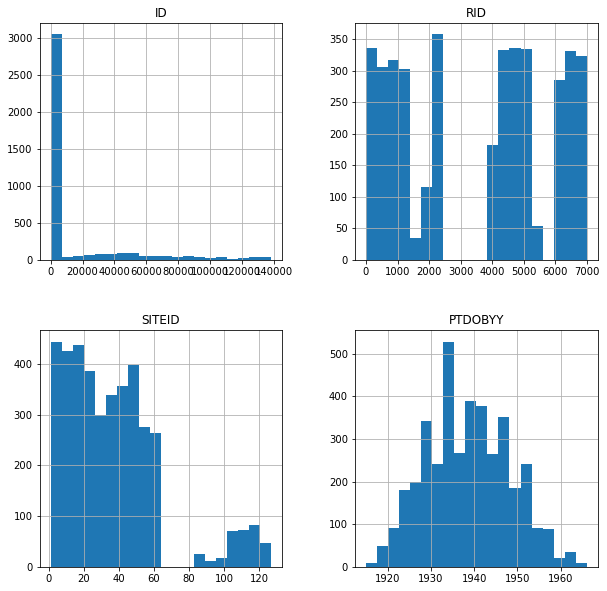

In [49]:
dem.hist(figsize=(10,10),bins=20)
a=1

In [50]:
dem.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
0,ADNI1,18,2,107,sc,sc,1.0,1931.0,2.0,1.0,16.0,1.0,2.0,5.0
1,ADNIGO,304,2,8,sc,sc,1.0,1931.0,2.0,2.0,16.0,1.0,2.0,5.0
2,ADNI2,636,2,8,v06,m72,1.0,1931.0,2.0,2.0,16.0,1.0,2.0,5.0
3,ADNI1,22,3,107,sc,sc,1.0,1924.0,1.0,1.0,18.0,1.0,2.0,5.0
4,ADNI1,24,4,10,sc,sc,1.0,1938.0,1.0,1.0,10.0,2.0,1.0,5.0


In [51]:
print(dem[['PTEDUCAT']].mean()) 
print(dem[['PTEDUCAT']].std()) 

PTEDUCAT    16.072838
dtype: float64
PTEDUCAT    2.781849
dtype: float64


In [52]:
# How many entries did we lose to cleaning?
dem_finish_entries = dem.shape[0]
dropped_entries = dem_start_entries - dem_finish_entries
print('Dropped entries:', dropped_entries)
print('Which is', np.round(dropped_entries/dem_start_entries*100, 2), '% of entries removed.')

Dropped entries: 762
Which is 16.16 % of entries removed.


In [53]:
# Writing dem to csv.
df = dem
df.to_csv('../../data/tabular_data/clean_PTDEMOG.csv', index=False)

### ADNIMERGE - selected merged datatables with data from ADNI1, ADNI2, ADNIGO, ADNI3

Next, we will check the file with data over all ADNI phases.

In [54]:
# ADNIMERGE dictionary.
df = pd.read_csv('../../data/tabular_data/ADNIMERGE_dict.csv')

# changing the max_rows value
pd.set_option("display.max_rows", 115)

adnimerge_dict = df[['FLDNAME', 'TEXT']]
adnimerge_dict

,FLDNAME,TEXT
0,RID,Participant roster ID
1,PTID,Original study protocol
2,ABETA,CSF ABETA
3,VISCODE,Visit code
4,SITE,Site
5,COLPROT,Study protocol of data collection
6,ORIGPROT,Original study protocol
7,EXAMDATE,Date
8,DX_bl,Baseline Dx
9,AGE,Age


In [55]:
# All ADNI phases, merged data, complementing PTDEMOG.csv: ADNIMERGE.csv
df = pd.read_csv('../../data/tabular_data/ADNIMERGE.csv')
df.head()

C:\Users\kfatur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (19,20,21,104,105,106) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.25173,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-05-14 05:01:08.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-05-14 05:01:08.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.498289,5.96721,6,6,2022-05-14 05:01:08.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.999316,11.96720,12,12,2022-05-14 05:01:08.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,1.998630,23.93440,24,24,2022-05-14 05:01:08.0


In [56]:
dem['RID'].nunique()

3357

In [57]:
# How many participants/records are in the PTDEMOG dataframe, but not in ADNIMERGE?
print(len(set(dem['RID'].unique()) - set(df['RID'].unique())))

# How many participants/records are in the ADNIMERGE dataframe, but not in PTDEMOG?
print(len(set(df['RID'].unique()) - set(dem['RID'].unique())))

1008
52


Demographic table has not been updated accordingly and there are 1008 records missing about the demographic data of patients currently included in the study. Is there a more up-to-date file? - No, according to the online community. 

52 people not in demographic table, but in adnimerge df - are maybe these participant those, who failed the screening?

In [58]:
ptp_in_am = list(set(df['RID'].unique()) - set(dem['RID'].unique()))

In [59]:
df[df['RID'].isin(ptp_in_am)]

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
13222,6884,ADNI3,ADNI3,123_S_6884,123,bl,2020-09-23,EMCI,56.0,Female,...,NaN,NaN,NaN,NaN,1.3185,0.0,0.0,0,0,2022-05-14 05:01:31.0
13687,6987,ADNI3,ADNI3,021_S_6987,21,bl,2021-08-10,CN,65.5,Female,...,NaN,NaN,NaN,1.0803,NaN,0.0,0.0,0,0,2022-05-14 05:01:31.0
13910,6999,ADNI3,ADNI3,035_S_6999,35,bl,2021-09-21,SMC,70.0,Male,...,NaN,NaN,NaN,1.3235,NaN,0.0,0.0,0,0,2022-05-14 05:01:31.0
15584,6994,ADNI3,ADNI3,021_S_6994,21,bl,2021-09-08,CN,61.4,Female,...,NaN,NaN,NaN,1.1636,NaN,0.0,0.0,0,0,2022-05-14 05:01:31.0
15587,6996,ADNI3,ADNI3,003_S_6996,3,bl,2021-09-27,SMC,64.6,Female,...,NaN,NaN,NaN,1.0070,NaN,0.0,0.0,0,0,2022-05-14 05:01:31.0
15588,6998,ADNI3,ADNI3,941_S_6998,941,bl,2021-10-05,CN,57.1,Male,...,NaN,NaN,NaN,NaN,1.0123,0.0,0.0,0,0,2022-05-14 05:01:31.0
15589,7000,ADNI3,ADNI3,035_S_7000,35,bl,2021-10-04,LMCI,89.5,Female,...,NaN,NaN,NaN,1.0361,NaN,0.0,0.0,0,0,2022-05-14 05:01:31.0
15609,7003,ADNI3,ADNI3,135_S_7003,135,bl,2021-10-13,AD,82.0,Female,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2022-05-14 05:01:31.0
15615,7007,ADNI3,ADNI3,027_S_7007,27,bl,2021-10-18,LMCI,71.9,Female,...,NaN,NaN,NaN,NaN,1.3644,0.0,0.0,0,0,2022-05-14 05:01:31.0
15628,6989,ADNI3,ADNI3,067_S_6989,67,bl,2021-10-19,LMCI,68.0,Female,...,NaN,NaN,NaN,NaN,1.5117,0.0,0.0,0,0,2022-05-14 05:01:31.0


50 participants who are in the ADNIMERGE file, but not (yet) entered in the demographic table have had their baseline exam in the last year, they were recruited for ADNI3.

In [60]:
# df.columns.tolist()

In [61]:
# 'ORIGPROT' = Original study protocol, which is the closest information to indicate Phase
am = df[['RID', 'ORIGPROT', 'SITE', 'VISCODE', 'EXAMDATE',
         'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
         'PTRACCAT', 'PTMARRY', 'DX', 'EXAMDATE_bl'
        ]] 
am.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15911 entries, 0 to 15910
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RID          15911 non-null  int64  
 1   ORIGPROT     15911 non-null  object 
 2   SITE         15911 non-null  int64  
 3   VISCODE      15911 non-null  object 
 4   EXAMDATE     15911 non-null  object 
 5   DX_bl        15883 non-null  object 
 6   AGE          15903 non-null  float64
 7   PTGENDER     15911 non-null  object 
 8   PTEDUCAT     15911 non-null  int64  
 9   PTETHCAT     15911 non-null  object 
 10  PTRACCAT     15911 non-null  object 
 11  PTMARRY      15910 non-null  object 
 12  DX           11120 non-null  object 
 13  EXAMDATE_bl  15911 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 1.7+ MB


In [62]:
# How many participants?
am['RID'].nunique()

2401

In [63]:
am = am.rename(columns = {'ORIGPROT':'Phase'})
am

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
0,2,ADNI1,11,bl,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
1,3,ADNI1,11,bl,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,Dementia,2005-09-12
2,3,ADNI1,11,m06,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married,Dementia,2005-09-12
3,3,ADNI1,11,m12,2006-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,Dementia,2005-09-12
4,3,ADNI1,11,m24,2007-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,Dementia,2005-09-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15906,5154,ADNI2,3,m90,2021-02-09,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,NaN,2013-06-10
15907,6341,ADNI3,7,m48,2022-05-09,LMCI,67.1,Male,12,Not Hisp/Latino,White,Married,NaN,2018-05-29
15908,6362,ADNI3,98,m36,2021-05-11,SMC,82.9,Female,18,Not Hisp/Latino,Asian,Widowed,NaN,2018-06-04
15909,7039,ADNI3,16,bl,2022-03-10,AD,61.6,Female,18,Not Hisp/Latino,Black,Married,Dementia,2022-03-10


In [64]:
am.isnull().sum()

RID               0
Phase             0
SITE              0
VISCODE           0
EXAMDATE          0
DX_bl            28
AGE               8
PTGENDER          0
PTEDUCAT          0
PTETHCAT          0
PTRACCAT          0
PTMARRY           1
DX             4791
EXAMDATE_bl       0
dtype: int64

In [65]:
# Order VISCODE, Phases
am['Phase'] = am['Phase'].astype('category')
am['VISCODE'] = am['VISCODE'].astype('category')

am['Phase'] = am['Phase'].cat.set_categories(['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3'], ordered=True)
am['VISCODE'] = am['VISCODE'].cat.set_categories(['sc', 'bl', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48',
                                                  'm54', 'uns1', 'f', 'nv', 'scmri', 'm03', 'm60', 'm66', 'm72', 'm78', 'v01', 'v02',
                                                  'v03', 'v04', 'v05', 'v06', 'v07', 'v11', 'v12', 'v21', 'v22', 'v31',
                                                  'v32', 'v41', 'v42', 'v51', 'v52', 'tau', 'reg', 'init', 'y1', 'y2', 
                                                  'y3', 'y4', 'y5', 'y6'], ordered=True)

In [66]:
# Make sure the exam column is of the correct type.
am['EXAMDATE'] = pd.to_datetime(am['EXAMDATE'])

In [67]:
am['PTMARRY'].unique()

array(['Married', 'Divorced', 'Widowed', 'Never married', 'Unknown', nan],
      dtype=object)

In [68]:
am[am['PTMARRY'].isnull()]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
15782,7031,ADNI3,35,bl,2022-02-15,EMCI,81.4,Female,14,Not Hisp/Latino,Black,NaN,MCI,2022-02-15


In [69]:
am[am['RID'] == 7031]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
15782,7031,ADNI3,35,bl,2022-02-15,EMCI,81.4,Female,14,Not Hisp/Latino,Black,NaN,MCI,2022-02-15


In [70]:
am = am.dropna(subset = ['PTMARRY'])

In [71]:
# Which entries are missing the diagnosis?
df = am.drop(['DX'], axis = 1)
am_na = df[df.isna().any(axis=1)]
print(am_na.shape)
# am_na

(1679, 13)


In [72]:
# We might like to obtain YOB from the above PTDEMOG df, so we will check if the RIDs from the entries with missing values are in the dem df above.
rids = dem['RID'].tolist()
match_rid = am_na[am_na['RID'].isin(rids)]
print(match_rid.shape)
match_rid.sort_values(by = 'RID')

(1674, 13)


,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,EXAMDATE_bl
11169,2,ADNI1,11,NaN,2013-03-25,CN,74.3,Male,16,Not Hisp/Latino,White,Married,2005-09-08
11164,2,ADNI1,11,NaN,2016-06-23,CN,74.3,Male,16,Not Hisp/Latino,White,Married,2005-09-08
11165,2,ADNI1,11,NaN,2015-09-22,CN,74.3,Male,16,Not Hisp/Latino,White,Married,2005-09-08
11166,2,ADNI1,11,NaN,2014-10-13,CN,74.3,Male,16,Not Hisp/Latino,White,Married,2005-09-08
11167,2,ADNI1,11,NaN,2014-03-17,CN,74.3,Male,16,Not Hisp/Latino,White,Married,2005-09-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13695,6935,ADNI3,14,bl,2021-08-12,NaN,70.4,Female,20,Hisp/Latino,White,Widowed,2021-08-12
13329,6939,ADNI3,16,bl,2021-06-21,NaN,73.5,Male,17,Hisp/Latino,White,Married,2021-06-21
13698,6944,ADNI3,14,bl,2021-08-11,NaN,76.9,Female,18,Not Hisp/Latino,Black,Divorced,2021-08-11
13304,6971,ADNI3,16,bl,2021-06-24,NaN,72.6,Male,16,Hisp/Latino,White,Married,2021-06-24


In [73]:
# am.isnull().sum()

In [74]:
am[am['DX_bl'].isnull()]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
12957,6712,ADNI3,19,bl,2019-04-24,NaN,90.6,Male,17,Not Hisp/Latino,White,Married,NaN,2019-04-24
13097,6853,ADNI3,16,bl,2020-03-09,NaN,67.0,Female,12,Not Hisp/Latino,Black,Never married,NaN,2020-03-09
13212,6880,ADNI3,137,bl,2020-12-09,NaN,66.3,Male,16,Not Hisp/Latino,White,Married,NaN,2020-12-09
13251,6883,ADNI3,137,bl,2020-12-21,NaN,64.5,Female,18,Not Hisp/Latino,White,Divorced,NaN,2020-12-21
13296,6934,ADNI3,16,bl,2021-05-06,NaN,67.0,Male,20,Not Hisp/Latino,Black,Married,NaN,2021-05-06
13304,6971,ADNI3,16,bl,2021-06-24,NaN,72.6,Male,16,Hisp/Latino,White,Married,NaN,2021-06-24
13323,6907,ADNI3,73,bl,2021-05-10,NaN,66.3,Male,18,Hisp/Latino,White,Married,NaN,2021-05-10
13329,6939,ADNI3,16,bl,2021-06-21,NaN,73.5,Male,17,Hisp/Latino,White,Married,NaN,2021-06-21
13632,6929,ADNI3,73,bl,2021-06-09,NaN,63.1,Female,14,Not Hisp/Latino,White,Married,NaN,2021-06-09
13663,6912,ADNI3,67,bl,2021-07-26,NaN,60.3,Female,16,Not Hisp/Latino,More than one,Divorced,NaN,2021-07-26


In [75]:
am[am['RID'] == 6712]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
12957,6712,ADNI3,19,bl,2019-04-24,NaN,90.6,Male,17,Not Hisp/Latino,White,Married,NaN,2019-04-24


In [76]:
am[am['RID'] == 6853]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
13097,6853,ADNI3,16,bl,2020-03-09,NaN,67.0,Female,12,Not Hisp/Latino,Black,Never married,NaN,2020-03-09


In [77]:
am[am['RID'] == 6880]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
13212,6880,ADNI3,137,bl,2020-12-09,NaN,66.3,Male,16,Not Hisp/Latino,White,Married,NaN,2020-12-09


People with just baseline visit in ADNI3 have just started the study and we don't have enough data on them, so we will drop these rows.

In [78]:
am = am.dropna(subset = ['DX_bl'])

In [79]:
am[am['DX'].isnull()]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
172,5275,ADNI2,135,m03,2013-11-06,AD,78.0,Female,12,Not Hisp/Latino,White,Married,NaN,2013-08-27
272,5273,ADNI2,135,m03,2013-11-06,SMC,90.1,Male,20,Not Hisp/Latino,White,Married,NaN,2013-08-20
400,5269,ADNI2,135,m36,2016-08-16,SMC,64.9,Male,16,Not Hisp/Latino,White,Divorced,NaN,2013-08-20
422,5269,ADNI2,135,m03,2013-10-23,SMC,64.9,Male,16,Not Hisp/Latino,White,Divorced,NaN,2013-08-20
732,5261,ADNI2,153,m24,2015-09-03,SMC,78.1,Female,18,Not Hisp/Latino,White,Widowed,NaN,2013-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15905,178,ADNI1,21,NaN,2022-05-03,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,NaN,2006-03-07
15906,5154,ADNI2,3,NaN,2021-02-09,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,NaN,2013-06-10
15907,6341,ADNI3,7,m48,2022-05-09,LMCI,67.1,Male,12,Not Hisp/Latino,White,Married,NaN,2018-05-29
15908,6362,ADNI3,98,m36,2021-05-11,SMC,82.9,Female,18,Not Hisp/Latino,Asian,Widowed,NaN,2018-06-04


In [80]:
am[am['RID'] == 5154]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
3126,5154,ADNI2,3,m06,2013-12-10,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,CN,2013-06-10
3127,5154,ADNI2,3,bl,2013-06-10,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,CN,2013-06-10
12890,5154,ADNI2,3,m24,2015-06-26,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,CN,2013-06-10
12917,5154,ADNI2,3,m36,2016-09-01,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,CN,2013-06-10
13257,5154,ADNI2,3,NaN,2020-04-30,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,NaN,2013-06-10
14335,5154,ADNI2,3,m60,2018-05-02,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,CN,2013-06-10
15906,5154,ADNI2,3,NaN,2021-02-09,SMC,72.4,Female,18,Not Hisp/Latino,White,Never married,NaN,2013-06-10


In [81]:
am[am['RID'] == 178].sort_values(by = ['EXAMDATE'])

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
438,178,ADNI1,21,bl,2006-03-07,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,MCI,2006-03-07
5573,178,ADNI1,21,m06,2006-09-07,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,MCI,2006-03-07
5574,178,ADNI1,21,m12,2007-03-08,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,MCI,2006-03-07
5575,178,ADNI1,21,m18,2007-09-07,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,MCI,2006-03-07
5576,178,ADNI1,21,m24,2008-03-21,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,MCI,2006-03-07
5577,178,ADNI1,21,m30,2008-09-17,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,NaN,2006-03-07
5578,178,ADNI1,21,m36,2009-03-17,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,MCI,2006-03-07
5579,178,ADNI1,21,m42,2009-09-15,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,NaN,2006-03-07
5580,178,ADNI1,21,m48,2010-03-17,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,MCI,2006-03-07
5581,178,ADNI1,21,m60,2011-06-03,LMCI,64.8,Male,20,Not Hisp/Latino,White,Married,MCI,2006-03-07


In [82]:
am[am['RID'] == 5275]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
169,5275,ADNI2,135,m06,2014-02-25,AD,78.0,Female,12,Not Hisp/Latino,White,Married,Dementia,2013-08-27
172,5275,ADNI2,135,m03,2013-11-06,AD,78.0,Female,12,Not Hisp/Latino,White,Married,NaN,2013-08-27
217,5275,ADNI2,135,bl,2013-08-27,AD,78.0,Female,12,Not Hisp/Latino,White,Married,Dementia,2013-08-27


In [83]:
am = am.sort_values(by = ['Phase', 'RID', 'EXAMDATE']).reset_index(drop = True)
am

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
0,2,ADNI1,11,bl,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
1,2,ADNI1,11,m06,2006-03-06,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
2,2,ADNI1,11,m36,2008-08-27,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
3,2,ADNI1,11,m60,2010-09-22,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
4,2,ADNI1,11,m66,2011-03-04,CN,74.3,Male,16,Not Hisp/Latino,White,Married,NaN,2005-09-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15877,7051,ADNI3,941,bl,2022-03-30,SMC,63.7,Male,12,Not Hisp/Latino,Black,Married,CN,2022-03-30
15878,7054,ADNI3,27,bl,2022-04-04,EMCI,72.2,Female,18,Not Hisp/Latino,White,Never married,MCI,2022-04-04
15879,7055,ADNI3,21,bl,2022-04-11,SMC,69.9,Male,16,Not Hisp/Latino,Black,Widowed,CN,2022-04-11
15880,7060,ADNI3,126,bl,2022-05-03,LMCI,76.5,Male,15,Not Hisp/Latino,White,Married,MCI,2022-05-03


I appears that these people have a diagnosis, it was just not entered at every visit / in every row.

In [84]:
# We add a boolean mask for RIDs with missing diagnosis to use forward fill for NaN.
# (The first exam with changed diagnosis always has a value entered, so we can fill the missing diagnosis with this first value, until the diagnosis changes.)
rids = am[am['DX'].isnull()]['RID'].tolist()

# We forward fill NAs only for RIDs in the list.
cols = ['AGE', 'DX']
am.loc[am['RID'].isin(rids), cols] = am.loc[:, cols].ffill()

In [85]:
am[am['AGE'].isnull()]

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
15241,6505,ADNI3,29,bl,2018-09-14,CN,NaN,Female,20,Hisp/Latino,White,Married,CN,2018-09-14
15718,6832,ADNI3,52,bl,2020-01-09,LMCI,NaN,Male,18,Not Hisp/Latino,White,Married,MCI,2020-01-09
15719,6832,ADNI3,52,m12,2021-03-15,LMCI,NaN,Male,18,Not Hisp/Latino,White,Married,MCI,2020-01-09
15753,6861,ADNI3,53,bl,2020-03-10,EMCI,NaN,Male,18,Not Hisp/Latino,White,Married,MCI,2020-03-10
15754,6861,ADNI3,53,m12,2021-05-27,EMCI,NaN,Male,18,Not Hisp/Latino,White,Married,MCI,2020-03-10


In [86]:
dem[dem['RID'] == 6505]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
3693,ADNI3,52121,6505,21,sc,sc,2.0,1955.0,1.0,1.0,20.0,1.0,1.0,5.0


In [87]:
# Age = EXAMDATE(am) - PTDOBYY(dem)
2018 - 1955

63

In [88]:
am.at[15241, 'AGE'] = 63

In [89]:
dem[dem['RID'] == 6832]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
4013,ADNI3,103027,6832,30,sc,sc,1.0,1941.0,1.0,1.0,18.0,1.0,2.0,5.0


In [90]:
2020 - 1941

79

In [91]:
am.at[15718, 'AGE'] = 79
am.at[15719, 'AGE'] = 79

In [92]:
dem[dem['RID'] == 6861]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTPLANG,PTETHCAT,PTRACCAT
4041,ADNI3,110443,6861,31,sc,sc,1.0,1953.0,1.0,1.0,18.0,1.0,2.0,5.0


In [93]:
2020 - 1953

67

In [94]:
am.at[15753, 'AGE'] = 67
am.at[15754, 'AGE'] = 67

In [95]:
print("The youngest participant is", am['AGE'].min(), "years old.")
print("The oldest participant is", am['AGE'].max(), "years old.")

The youngest participant is 50.4 years old.
The oldest participant is 91.4 years old.


In [96]:
print(am.shape)

# Are there the same no. of participants as in PTDEMOG - 3940?
print(am['RID'].nunique())

(15882, 14)
2372


PTDEMOG.csv and ADNIMERGE.csv seem to have a different number of participants. We know that some people failed screening and some discontinued or were excluded. We will just note, that we might need to combine these two sources to obtain complete demographic information on our study cohort.

In [97]:
am.isnull().sum()

RID               0
Phase             0
SITE              0
VISCODE        1643
EXAMDATE          0
DX_bl             0
AGE               0
PTGENDER          0
PTEDUCAT          0
PTETHCAT          0
PTRACCAT          0
PTMARRY           0
DX                0
EXAMDATE_bl       0
dtype: int64

In [98]:
am['DX_bl']

0          CN
1          CN
2          CN
3          CN
4          CN
         ... 
15877     SMC
15878    EMCI
15879     SMC
15880    LMCI
15881      CN
Name: DX_bl, Length: 15882, dtype: object

In [99]:
am.head()

,RID,Phase,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,DX,EXAMDATE_bl
0,2,ADNI1,11,bl,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
1,2,ADNI1,11,m06,2006-03-06,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
2,2,ADNI1,11,m36,2008-08-27,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
3,2,ADNI1,11,m60,2010-09-22,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08
4,2,ADNI1,11,m66,2011-03-04,CN,74.3,Male,16,Not Hisp/Latino,White,Married,CN,2005-09-08


In [100]:
pt_race = am.groupby("RID").first()

In [101]:
pt_race.groupby('PTRACCAT')['DX'].count()

PTRACCAT
Am Indian/Alaskan       5
Asian                  53
Black                 158
Hawaiian/Other PI       2
More than one          27
Unknown                11
White                2116
Name: DX, dtype: int64

In [102]:
# Indian/Alaskan %
5/2372

0.0021079258010118043

In [103]:
# non-white %
1 - 2116/2372

0.10792580101180438

In [104]:
print('No. of participants:', am[['RID']].nunique())
print()
print(am.groupby('DX')['AGE'].mean())
print(am.groupby('DX')['AGE'].std())
print()
print(am.groupby('DX')['PTEDUCAT'].mean())
print(am.groupby('DX')['PTEDUCAT'].std())

No. of participants: RID    2372
dtype: int64

DX
CN          73.156241
Dementia    74.364747
MCI         72.878906
Name: AGE, dtype: float64
DX
CN          6.242177
Dementia    7.322029
MCI         7.421790
Name: AGE, dtype: float64

DX
CN          16.512548
Dementia    15.530535
MCI         16.011248
Name: PTEDUCAT, dtype: float64
DX
CN          2.582445
Dementia    2.908393
MCI         2.809627
Name: PTEDUCAT, dtype: float64


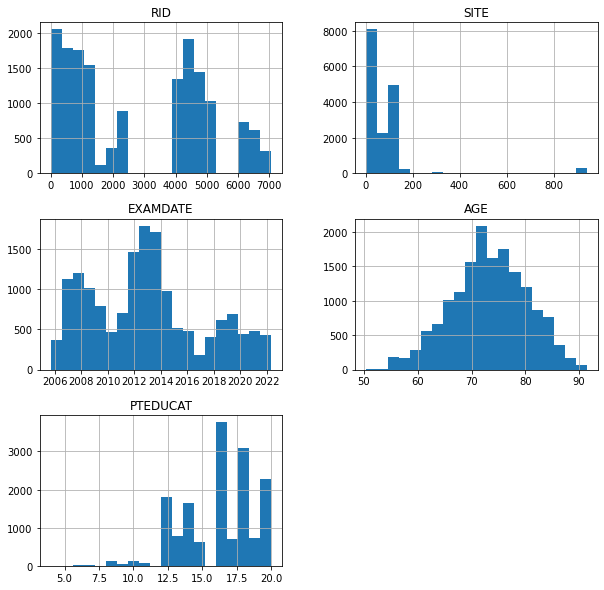

In [105]:
am.hist(figsize=(10,10),bins=20)
a=1

In [106]:
# Writing am to csv.
df = am
df.to_csv('../../data/tabular_data/clean_ADNIMERGE.csv', index=False)

### Diagnostic information

Now let's study the diagnostic table, the hopes are high. Fingers crossed that we will get as many diagnostic entries as possible.

In [107]:
# Diagnosis: DXSUM_PDXCONV_ADNIALL.csv
df = pd.read_csv('../../data/tabular_data/DXSUM_PDXCONV_ADNIALL.csv')
diag = df[['Phase', 'RID', 'PTID', 'SITEID', 'VISCODE', 'VISCODE2','EXAMDATE',
         'DXCHANGE', 'DXCURREN', 'DIAGNOSIS'
        ]] 

diag.head()

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DXCURREN,DIAGNOSIS
0,ADNI1,2,011_S_0002,107,bl,bl,2005-09-29,NaN,1.0,NaN
1,ADNI1,2,011_S_0002,107,m06,m06,2006-03-06,NaN,1.0,NaN
2,ADNI1,3,011_S_0003,107,bl,bl,2005-09-30,NaN,3.0,NaN
3,ADNI1,3,011_S_0003,107,m06,m06,2006-03-13,NaN,3.0,NaN
4,ADNI1,3,011_S_0003,107,m12,m12,2006-09-13,NaN,3.0,NaN


The head does not look too promising.
Current diagnosis variable names change by the phase in the diagnosis summary table.
Quick recap:
- ADNI1: DXCURREN 1=NL; 2=MCI; 3=AD
- ADNIGO/2: DXCHANGE    
    1=Stable: NL to NL;    
    2=Stable: MCI to MCI;  
    3=Stable: Dementia to Dementia;   
    4=Conversion: NL to MCI;   
    5=Conversion: MCI to Dementia; 
    6=Conversion: NL to Dementia;  
    7=Reversion: MCI to NL;   
    8=Reversion: Dementia to MCI;   
    9=Reversion: Dementia to NL    
- ADNI3: DIAGNOSIS 1=CN; 2=MCI; 3=Dementia

In [108]:
diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12996 entries, 0 to 12995
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Phase      12996 non-null  object 
 1   RID        12996 non-null  int64  
 2   PTID       12996 non-null  object 
 3   SITEID     12996 non-null  int64  
 4   VISCODE    12996 non-null  object 
 5   VISCODE2   12990 non-null  object 
 6   EXAMDATE   12966 non-null  object 
 7   DXCHANGE   6146 non-null   float64
 8   DXCURREN   3868 non-null   float64
 9   DIAGNOSIS  2971 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 1015.4+ KB


In [109]:
diag_start_entries = diag.shape[0]
diag_start_entries

12996

In [110]:
diag['EXAMDATE'] = pd.to_datetime(diag['EXAMDATE']).dt.date

C:\Users\kfatur\AppData\Local\Temp/ipykernel_30616/4249674630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag['EXAMDATE'] = pd.to_datetime(diag['EXAMDATE']).dt.date


In [111]:
diag.isnull().sum()

Phase            0
RID              0
PTID             0
SITEID           0
VISCODE          0
VISCODE2         6
EXAMDATE        30
DXCHANGE      6850
DXCURREN      9128
DIAGNOSIS    10025
dtype: int64

Yikes! Diagnostic columns have missing values in the 1000s. 

In [112]:
# Order VISCODE, Phases
am['Phase'] = am['Phase'].astype('category')
am['VISCODE'] = am['VISCODE'].astype('category')

am['Phase'] = am['Phase'].cat.set_categories(['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3'], ordered=True)
am['VISCODE'] = am['VISCODE'].cat.set_categories(['sc', 'bl', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48',
                                                  'm54', 'uns1', 'f', 'nv', 'scmri', 'm03', 'm60', 'm66', 'm72', 'm78', 'v01', 'v02',
                                                  'v03', 'v04', 'v05', 'v06', 'v07', 'v11', 'v12', 'v21', 'v22', 'v31',
                                                  'v32', 'v41', 'v42', 'v51', 'v52', 'tau', 'reg', 'init', 'y1', 'y2', 
                                                  'y3', 'y4', 'y5', 'y6'], ordered=True)

In [113]:
missing = np.round((9128/diag.shape[0]*100), decimals=1)
missing
print(missing, "% of the values in the current diagnosis column ['DXCURREN'] are missing.")

70.2 % of the values in the current diagnosis column ['DXCURREN'] are missing.


In [114]:
# What is with the missing diagnosis in the diagnosis file?
df = diag[diag['DIAGNOSIS'].isnull()]
df

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DXCURREN,DIAGNOSIS
0,ADNI1,2,011_S_0002,107,bl,bl,2005-09-29,NaN,1.0,NaN
1,ADNI1,2,011_S_0002,107,m06,m06,2006-03-06,NaN,1.0,NaN
2,ADNI1,3,011_S_0003,107,bl,bl,2005-09-30,NaN,3.0,NaN
3,ADNI1,3,011_S_0003,107,m06,m06,2006-03-13,NaN,3.0,NaN
4,ADNI1,3,011_S_0003,107,m12,m12,2006-09-13,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
11947,ADNI3,5273,135_S_5273,52,y2,NaN,NaT,NaN,NaN,NaN
12112,ADNI3,6701,032_S_6701,23,bl,bl,NaT,NaN,NaN,NaN
12507,ADNI3,6898,003_S_6898,2,sc,sc,NaT,NaN,NaN,NaN
12565,ADNI3,5158,029_S_5158,21,y2,m78,NaT,NaN,NaN,NaN


In [115]:
# Do some participants have at least diagnosis at some visits, but not on others?
diag_by_rid = diag.sort_values(['RID', 'EXAMDATE'])
diag_by_rid.head(100)

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DXCURREN,DIAGNOSIS
0,ADNI1,2,011_S_0002,107,bl,bl,2005-09-29,NaN,1.0,NaN
1,ADNI1,2,011_S_0002,107,m06,m06,2006-03-06,NaN,1.0,NaN
2134,ADNI1,2,011_S_0002,107,m36,m36,2008-08-27,NaN,1.0,NaN
3907,ADNIGO,2,011_S_0002,8,m60,m60,2010-09-27,1.0,NaN,NaN
4701,ADNI2,2,011_S_0002,8,v06,m72,2011-09-19,1.0,NaN,NaN
6465,ADNI2,2,011_S_0002,8,v11,m84,2012-10-04,4.0,NaN,NaN
7949,ADNI2,2,011_S_0002,8,v21,m96,2013-09-23,1.0,NaN,NaN
9453,ADNI2,2,011_S_0002,8,v41,m120,2015-10-20,1.0,NaN,NaN
9885,ADNI2,2,011_S_0002,8,v51,m132,2016-10-03,4.0,NaN,NaN
10303,ADNI3,2,011_S_0002,8,init,m144,2017-11-01,NaN,NaN,2.0


We notice that the majority of the rows have some diagnostic information in at least one of the columns: DXCHANGE, DXCURREN or DIAGNOSIS. We conclude that DXCURRENT is the diagnosis in ADNI1, DXCHANGE marks transitions though ADNI2 and DIAGNOSIS is diagnosis for ADNI3. It would be easier if each row had its own straightforward diagnosis, so we will infer it.    

If a row's diagnosis remains NaN, we will remove it, since we cannot use it for categorization.   

We will make an inferred column DX, with current diagnosis for each row (we cannot use 'DIAGNOSIS', since it only shows diagnosis specific for ADNI3).

In [116]:
def no_diagnosis(df):
    current = df['DXCURREN']
    change = df['DXCHANGE']
    diagnosis = df['DIAGNOSIS']
    
    # if diagnosis is not nan, dx = diagnosis
    if not math.isnan(diagnosis):
        return diagnosis
    # if current is not nan, dx = current
    if not math.isnan(current):
        return current
    # if change is nan, retain nan to remove rows later, otherwise ...
    if math.isnan(change):
        return change
    
    # map diagnostic values from DXCHANGE to 1=NC, 2=MCI, 3=AD
    mapping = {
        1: 1,
        2: 2,
        3: 3,
        4: 2,
        5: 3,
        6: 3,
        7: 1,
        8: 1,
        9: 1
    }
    
    return mapping[change]
           
# diag.apply(no_diagnosis, axis=1)

In [117]:
# Make a new column, which will have diagnosis for each row.
diag['DX'] = diag.apply(no_diagnosis, axis=1)
# diag.head()

In [118]:
# Remove rows where we could not infer diagnosis.
diag = diag.dropna(subset=['DX'])
diag['DX'].isnull().sum()

0

In [119]:
diag = diag.reset_index(drop=True)
diag

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DXCURREN,DIAGNOSIS,DX
0,ADNI1,2,011_S_0002,107,bl,bl,2005-09-29,NaN,1.0,NaN,1.0
1,ADNI1,2,011_S_0002,107,m06,m06,2006-03-06,NaN,1.0,NaN,1.0
2,ADNI1,3,011_S_0003,107,bl,bl,2005-09-30,NaN,3.0,NaN,3.0
3,ADNI1,3,011_S_0003,107,m06,m06,2006-03-13,NaN,3.0,NaN,3.0
4,ADNI1,3,011_S_0003,107,m12,m12,2006-09-13,NaN,3.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...
12980,ADNI3,7045,021_S_7045,16,sc,sc,2022-02-17,NaN,NaN,1.0,1.0
12981,ADNI3,7049,035_S_7049,25,sc,sc,2022-03-01,NaN,NaN,2.0,2.0
12982,ADNI3,6870,031_S_6870,22,sc,sc,2022-03-03,NaN,NaN,1.0,1.0
12983,ADNI3,7050,035_S_7050,25,sc,sc,2022-03-03,NaN,NaN,1.0,1.0


Now we have enough demographic information (age, gender, education, marital status, race, ethnicity, etc., as well as diagnosis for each row. We can join any desired column to our test dataframes.

In [120]:
diag.head()

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DXCURREN,DIAGNOSIS,DX
0,ADNI1,2,011_S_0002,107,bl,bl,2005-09-29,NaN,1.0,NaN,1.0
1,ADNI1,2,011_S_0002,107,m06,m06,2006-03-06,NaN,1.0,NaN,1.0
2,ADNI1,3,011_S_0003,107,bl,bl,2005-09-30,NaN,3.0,NaN,3.0
3,ADNI1,3,011_S_0003,107,m06,m06,2006-03-13,NaN,3.0,NaN,3.0
4,ADNI1,3,011_S_0003,107,m12,m12,2006-09-13,NaN,3.0,NaN,3.0


In [121]:
change = diag[diag['DXCHANGE'].isna()]
change['Phase'].unique()

array(['ADNI1', 'ADNI3'], dtype=object)

DXCHANGE has NaN values, where observation of diagnostic change is not yet possible: in the first phase of ADNI and with the new participants in ADNI3. We will introduce a new category - where no change could be observed yet, we will encode it with 0. This will make this column easier to work with and filter.    
The information from DXCURREN and DIAGNOSIS is now stored in DX and it is linked to Phase, RID and EXAMDATE, so it is uniquely defined for each entry and we can drop separate columns DXCURRENT and DIAGNOSIS - they stored the same type of info anyway, the difference being only, that DXCURREN had data on ADNI1 and DIAGNOSIS on ADNI3.

In [122]:
# Where change of diagnosis is not applicable, because the time period is too short, participants are new, etc.
diag['DXCHANGE'] =  diag['DXCHANGE'].fillna('0')

In [123]:
# Remove columns.
diag = diag.drop(['DXCURREN', 'DIAGNOSIS'], axis = 1)

In [124]:
diag.isnull().sum()

Phase        0
RID          0
PTID         0
SITEID       0
VISCODE      0
VISCODE2     3
EXAMDATE    19
DXCHANGE     0
DX           0
dtype: int64

In [125]:
diag[diag['VISCODE2'].isna()]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
11615,ADNI3,4037,041_S_4037,28,y2,NaN,2019-05-09,0,1.0
12782,ADNI3,5282,082_S_5282,37,y2,NaN,2020-10-20,0,2.0
12984,ADNI3,6266,033_S_6266,24,y4,NaN,2022-03-04,0,1.0


In [126]:
# Check what neighbouring participants have for VISCODE.
# For the participant RID = 6195
diag.iloc[11612:11620]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
11612,ADNI3,4419,021_S_4419,16,y2,m90,2019-05-13,0,1.0
11613,ADNI3,5097,041_S_5097,28,y1,m72,2019-04-25,0,1.0
11614,ADNI3,6690,082_S_6690,37,bl,bl,2019-05-16,0,3.0
11615,ADNI3,4037,041_S_4037,28,y2,NaN,2019-05-09,0,1.0
11616,ADNI3,4199,116_S_4199,44,y1,m90,2019-04-22,0,2.0
11617,ADNI3,6704,129_S_6704,49,bl,bl,2019-05-22,0,1.0
11618,ADNI3,1378,141_S_1378,55,y2,m144,2019-06-03,0,2.0
11619,ADNI3,6008,141_S_6008,55,y2,m24,2019-06-03,0,1.0


In [127]:
# Check what visits has this patient already had. What comes after VISCODE2 'm72'?
diag[diag['RID'] == 4037]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
4381,ADNI2,4037,041_S_4037,27,v01,sc,2011-04-29,1.0,1.0
4473,ADNI2,4037,041_S_4037,27,v03,bl,2011-06-27,1.0,1.0
5176,ADNI2,4037,041_S_4037,27,v05,m06,2012-01-24,1.0,1.0
6151,ADNI2,4037,041_S_4037,27,v11,m12,2012-07-25,1.0,1.0
7650,ADNI2,4037,041_S_4037,27,v21,m24,2013-07-05,1.0,1.0
9404,ADNI2,4037,041_S_4037,27,v41,m48,2015-09-16,1.0,1.0
10133,ADNI3,4037,041_S_4037,28,init,m72,2017-07-13,0,1.0
11615,ADNI3,4037,041_S_4037,28,y2,NaN,2019-05-09,0,1.0


In [128]:
# VISCODE2 == the difference from penultimate visit in 'EXAMDATE', 2017-07-13, with visit code 'm72'
# until the visit with the missing VISCODE2 on 2019-05-09, which is m72 + 24 months =  'm96'
diag[diag['VISCODE2'] == 'm96'].head()

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
7948,ADNI2,8,011_S_0008,8,v21,m96,2013-09-23,1.0,1.0
7949,ADNI2,2,011_S_0002,8,v21,m96,2013-09-23,1.0,1.0
8109,ADNI2,31,023_S_0031,17,v21,m96,2013-10-21,1.0,1.0
8124,ADNI2,21,011_S_0021,8,v21,m96,2013-11-06,1.0,1.0
8192,ADNI2,42,023_S_0042,17,v31,m96,2013-12-04,3.0,3.0


In [129]:
diag[diag['RID'] == 8]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
23,ADNI1,8,011_S_0008,107,bl,bl,2005-09-30,0,1.0
24,ADNI1,8,011_S_0008,107,m06,m06,2006-03-20,0,1.0
25,ADNI1,8,011_S_0008,107,m12,m12,2006-09-20,0,1.0
2138,ADNI1,8,011_S_0008,107,m36,m36,2008-09-09,0,1.0
2139,ADNI1,8,011_S_0008,107,m48,m48,2009-10-13,0,1.0
3913,ADNIGO,8,011_S_0008,8,m60,m60,2010-10-01,1.0,1.0
4730,ADNI2,8,011_S_0008,8,v06,m72,2011-09-29,1.0,1.0
6464,ADNI2,8,011_S_0008,8,v11,m84,2012-10-04,1.0,1.0
7948,ADNI2,8,011_S_0008,8,v21,m96,2013-09-23,1.0,1.0
9482,ADNI2,8,011_S_0008,8,v41,m120,2015-11-10,4.0,2.0


In [130]:
# Check what visits the other two patients already had?
print(diag[diag['RID'] == 5282])
print(diag[diag['RID'] == 6266])

       Phase   RID        PTID  SITEID VISCODE VISCODE2    EXAMDATE DXCHANGE  \
7813   ADNI2  5282  082_S_5282      36     v01       sc  2013-08-16      1.0   
8381   ADNI2  5282  082_S_5282      36     v03       bl  2013-09-09      1.0   
8655   ADNI2  5282  082_S_5282      36     v05      m06  2014-04-25      1.0   
9978   ADNI2  5282  082_S_5282      36     v21      m24  2015-11-25      1.0   
11060  ADNI3  5282  082_S_5282      37    init      m54  2018-06-14        0   
11720  ADNI3  5282  082_S_5282      37      y1      m72  2019-06-17        0   
12782  ADNI3  5282  082_S_5282      37      y2      NaN  2020-10-20        0   

        DX  
7813   1.0  
8381   1.0  
8655   1.0  
9978   1.0  
11060  1.0  
11720  1.0  
12782  2.0  
       Phase   RID        PTID  SITEID VISCODE VISCODE2    EXAMDATE DXCHANGE  \
10562  ADNI3  6266  033_S_6266      24      sc       sc  2018-03-07        0   
10763  ADNI3  6266  033_S_6266      24      bl       bl  2018-05-18        0   
12213  ADNI3  6

In [131]:
# VISCODE2 for RID 4037
diag.at[11615, 'VISCODE2'] = 'm96'
# for RID 5282
diag.at[12782, 'VISCODE2'] = 'm84'
# for RID 6266
diag.at[12984, 'VISCODE2'] = 'm48'

diag[diag['VISCODE2'].isna()]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX


In [132]:
# # Is the last visit with VISCODE2 'm48'?
diag[diag['RID'] == 6266]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10562,ADNI3,6266,033_S_6266,24,sc,sc,2018-03-07,0,1.0
10763,ADNI3,6266,033_S_6266,24,bl,bl,2018-05-18,0,1.0
12213,ADNI3,6266,033_S_6266,24,y2,m24,2020-03-17,0,1.0
12984,ADNI3,6266,033_S_6266,24,y4,m48,2022-03-04,0,1.0


In [133]:
# Assign order to Phases.
phase_order = ['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3']
diag['Phase'] = diag['Phase'].astype(CategoricalDtype(categories=phase_order, ordered=True))

In [134]:
diag = diag.sort_values(by = ['Phase', 'VISCODE', 'VISCODE2', 'RID']).reset_index(drop=True)
diag.tail(10)

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
12975,ADNI3,5132,127_S_5132,47,y4,m96,2021-05-27,0,2.0
12976,ADNI3,5169,027_S_5169,20,y4,m96,2021-05-18,0,1.0
12977,ADNI3,5170,027_S_5170,20,y4,m96,2021-06-17,0,1.0
12978,ADNI3,5177,021_S_5177,16,y4,m96,2021-06-16,0,1.0
12979,ADNI3,5200,127_S_5200,47,y4,m96,2021-10-05,0,1.0
12980,ADNI3,5222,037_S_5222,27,y4,m96,2021-06-23,0,1.0
12981,ADNI3,5237,021_S_5237,16,y4,m96,2021-10-01,0,3.0
12982,ADNI3,5265,007_S_5265,5,y4,m96,2021-09-21,0,2.0
12983,ADNI3,4919,027_S_4919,20,y5,m114,2022-01-31,0,2.0
12984,ADNI3,2245,027_S_2245,20,y5,m132,2022-01-27,0,2.0


In [135]:
NaT = diag[diag['EXAMDATE'].isna()].sort_values(by = ['Phase', 'VISCODE', 'RID'])
NaT

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10123,ADNI3,6195,035_S_6195,25,bl,bl,NaT,0,1.0
10335,ADNI3,6512,127_S_6512,47,bl,bl,NaT,0,2.0
10712,ADNI3,752,116_S_0752,44,init,m144,NaT,0,3.0
11028,ADNI3,2396,053_S_2396,31,init,m90,NaT,0,2.0
10776,ADNI3,5285,051_S_5285,29,init,m54,NaT,0,2.0
10777,ADNI3,5294,051_S_5294,29,init,m54,NaT,0,2.0
11051,ADNI3,6024,127_S_6024,47,sc,sc,NaT,0,1.0
11122,ADNI3,6102,019_S_6102,14,sc,sc,NaT,0,3.0
11538,ADNI3,6599,137_S_6599,54,sc,sc,NaT,0,1.0
11561,ADNI3,6628,137_S_6628,54,sc,sc,NaT,0,1.0


In [136]:
NaT['VISCODE'].unique()

array(['bl', 'init', 'sc', 'y1', 'y2', 'y3'], dtype=object)

All missing dates occur in ADNI3.

Can we add approximate dates of exam based on Phase, VISCODE, and neighbouring entries? Since we have VISCODE and VISCODE2for all patients, we can calculate the approximate time of the visit +/- month. or our purposes, +/- 2 months doesnt play a role, we just want to preserve integrity of an individual's progression and are not interested in the exact dates.

In [137]:
diag[diag['RID'] == 6195].sort_values(by = ['Phase', 'EXAMDATE', 'VISCODE'])

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
11204,ADNI3,6195,035_S_6195,25,sc,sc,2018-01-24,0,1.0
10123,ADNI3,6195,035_S_6195,25,bl,bl,NaT,0,1.0


Thie invsetigation below gives us an idea within which timeframe the exam should happen: we checked individual progression above, now we check the neighbouring entries below.

In [138]:
# Nearby entries for RIDs 6195
diag[diag['RID'] == 6192].sort_values(by = ['Phase', 'EXAMDATE'])

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
11203,ADNI3,6192,041_S_6192,28,sc,sc,2018-01-29,0,1.0
10122,ADNI3,6192,041_S_6192,28,bl,bl,2018-02-20,0,1.0
12475,ADNI3,6192,041_S_6192,28,y2,m24,2020-03-23,0,1.0


In [139]:
# Let's check dates for 2 participants close to 6195 who have all dates.
diag[diag['RID'] == 6197].sort_values(by = ['Phase', 'EXAMDATE'])

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
11205,ADNI3,6197,082_S_6197,37,sc,sc,2018-02-14,0,1.0
10124,ADNI3,6197,082_S_6197,37,bl,bl,2018-07-10,0,1.0


We notice two things. The person 6195 had screening in Jan 2018 for ADNI3. The neighbouring RIDs 6192 and 6197 had baseline visits between 2018-02-20 and 2018-07-10.

With na informed guess we can say that the participant with RID = 6195 was probably examined sometime in 2018 between February and October. (Phase + VISCODE/VISCODE2 are pretty strong indicators), since there is only one baseline exam per individual per Phase.)

In [140]:
diag = diag.sort_values(by = ['Phase', 'EXAMDATE', 'VISCODE', 'RID']).reset_index(drop=True)
diag.tail(25)

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
12960,ADNI3,7049,035_S_7049,25,sc,sc,2022-03-01,0,2.0
12961,ADNI3,1222,007_S_1222,5,y4,m180,2022-03-01,0,1.0
12962,ADNI3,6870,031_S_6870,22,sc,sc,2022-03-03,0,1.0
12963,ADNI3,7050,035_S_7050,25,sc,sc,2022-03-03,0,1.0
12964,ADNI3,6266,033_S_6266,24,y4,m48,2022-03-04,0,1.0
12965,ADNI3,1418,041_S_1418,28,y2,m144,2109-07-26,0,2.0
12966,ADNI3,6195,035_S_6195,25,bl,bl,NaT,0,1.0
12967,ADNI3,6512,127_S_6512,47,bl,bl,NaT,0,2.0
12968,ADNI3,752,116_S_0752,44,init,m144,NaT,0,3.0
12969,ADNI3,2396,053_S_2396,31,init,m90,NaT,0,2.0


For the participant at iloc[12965] we notice a strange (typo) date: 2109-07-26. Probably the year should be 2019, but let's check the progression:

In [141]:
diag[diag['RID'] == 1418]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
1813,ADNI1,1418,041_S_1418,20,bl,bl,2007-08-14,0,2.0
2386,ADNI1,1418,041_S_1418,20,m06,m06,2008-02-18,0,2.0
2819,ADNI1,1418,041_S_1418,20,m12,m12,2008-07-28,0,2.0
3222,ADNI1,1418,041_S_1418,20,m18,m18,2009-02-24,0,2.0
3480,ADNI1,1418,041_S_1418,20,m24,m24,2009-08-11,0,2.0
3842,ADNI1,1418,041_S_1418,20,m36,m36,2010-09-17,0,2.0
5105,ADNI2,1418,041_S_1418,27,v06,m48,2011-12-22,2.0,2.0
6249,ADNI2,1418,041_S_1418,27,v11,m60,2012-08-09,2.0,2.0
8352,ADNI2,1418,041_S_1418,27,v21,m72,2013-12-23,2.0,2.0
8979,ADNI2,1418,041_S_1418,27,v31,m84,2014-10-17,2.0,2.0


The date should definitely be 2019-07-26, let's fix that.

In [142]:
diag.at[12965, 'EXAMDATE'] = '2019-07-26'

In [143]:
# Fix date type (We messed it up with str type insert.)
diag['EXAMDATE'] = pd.to_datetime(diag['EXAMDATE']).dt.normalize()

In [144]:
# Continue fixing missing date. Compare by phase, site, viscode and viscode2 and fill examdate with similar.
diag = diag.sort_values(by = ['Phase', 'VISCODE', 'VISCODE2', 'RID']).reset_index(drop=True)
diag[diag['EXAMDATE'].isna()] 

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10123,ADNI3,6195,035_S_6195,25,bl,bl,NaT,0,1.0
10335,ADNI3,6512,127_S_6512,47,bl,bl,NaT,0,2.0
10712,ADNI3,752,116_S_0752,44,init,m144,NaT,0,3.0
10776,ADNI3,5285,051_S_5285,29,init,m54,NaT,0,2.0
10777,ADNI3,5294,051_S_5294,29,init,m54,NaT,0,2.0
11028,ADNI3,2396,053_S_2396,31,init,m90,NaT,0,2.0
11051,ADNI3,6024,127_S_6024,47,sc,sc,NaT,0,1.0
11122,ADNI3,6102,019_S_6102,14,sc,sc,NaT,0,3.0
11538,ADNI3,6599,137_S_6599,54,sc,sc,NaT,0,1.0
11561,ADNI3,6628,137_S_6628,54,sc,sc,NaT,0,1.0




We will fill the rows with missing date with the visit date from the row below.

In [145]:
diag.isnull().sum()

Phase        0
RID          0
PTID         0
SITEID       0
VISCODE      0
VISCODE2     0
EXAMDATE    19
DXCHANGE     0
DX           0
dtype: int64

In [146]:
# Let's try merging ADNIMERGE dataframe with entered exam dates.
examdate = am[['RID', 'Phase', 'VISCODE', 'EXAMDATE']]
diag = pd.merge(diag, examdate, how='left', on=['Phase', 'RID', 'VISCODE'])
diag[diag['EXAMDATE_x'].isnull()]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE_x,DXCHANGE,DX,EXAMDATE_y
10123,ADNI3,6195,035_S_6195,25,bl,bl,NaT,0,1.0,2018-04-18
10335,ADNI3,6512,127_S_6512,47,bl,bl,NaT,0,2.0,2018-09-13
10712,ADNI3,752,116_S_0752,44,init,m144,NaT,0,3.0,NaT
10776,ADNI3,5285,051_S_5285,29,init,m54,NaT,0,2.0,NaT
10777,ADNI3,5294,051_S_5294,29,init,m54,NaT,0,2.0,NaT
11028,ADNI3,2396,053_S_2396,31,init,m90,NaT,0,2.0,NaT
11051,ADNI3,6024,127_S_6024,47,sc,sc,NaT,0,1.0,NaT
11122,ADNI3,6102,019_S_6102,14,sc,sc,NaT,0,3.0,NaT
11538,ADNI3,6599,137_S_6599,54,sc,sc,NaT,0,1.0,NaT
11561,ADNI3,6628,137_S_6628,54,sc,sc,NaT,0,1.0,NaT


In [147]:
diag[diag['RID'] == 6102]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE_x,DXCHANGE,DX,EXAMDATE_y
11122,ADNI3,6102,019_S_6102,14,sc,sc,NaT,0,3.0,NaT


If an exam date is missing for a screening exam and there is no such date in ADNIMERGE, it means we have no way of inferring this date. Since such participant has just started the study, there are not much data available, so we can drop such entries.

In [148]:
diag = diag.drop(diag[(diag['VISCODE'] == 'sc') & (diag['EXAMDATE_x'].isnull())].index)

In [149]:
diag['EXAMDATE_x'] = pd.to_datetime(diag['EXAMDATE_x']).dt.normalize()
diag['EXAMDATE_y'] = pd.to_datetime(diag['EXAMDATE_y']).dt.normalize()

In [150]:
# For the participants with RID = 6195 and 6512 we have dates in merged column.
diag.at[10123, 'EXAMDATE_x'] = '2018-04-18'
diag.at[10335, 'EXAMDATE_x'] = '2018-09-13'

In [151]:
diag = diag.drop('EXAMDATE_y', axis=1)
diag.columns = diag.columns.str.replace('EXAMDATE_x', 'EXAMDATE')
diag

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
0,ADNI1,2,011_S_0002,107,bl,bl,2005-09-29,0,1.0
1,ADNI1,3,011_S_0003,107,bl,bl,2005-09-30,0,3.0
2,ADNI1,4,022_S_0004,10,bl,bl,2005-11-08,0,2.0
3,ADNI1,5,011_S_0005,107,bl,bl,2005-09-30,0,1.0
4,ADNI1,6,100_S_0006,4,bl,bl,2005-12-01,0,2.0
...,...,...,...,...,...,...,...,...,...
12980,ADNI3,5222,037_S_5222,27,y4,m96,2021-06-23,0,1.0
12981,ADNI3,5237,021_S_5237,16,y4,m96,2021-10-01,0,3.0
12982,ADNI3,5265,007_S_5265,5,y4,m96,2021-09-21,0,2.0
12983,ADNI3,4919,027_S_4919,20,y5,m114,2022-01-31,0,2.0


In [152]:
# For the participant RID = 4485
diag.iloc[12225:12232]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
12231,ADNI3,4489,135_S_4489,52,y1,m78,2018-06-01,0,2.0
12232,ADNI3,4502,023_S_4502,18,y1,m78,2018-11-12,0,3.0
12233,ADNI3,4536,137_S_4536,54,y1,m78,2020-03-03,0,2.0
12234,ADNI3,4538,036_S_4538,26,y1,m78,2018-12-20,0,3.0
12235,ADNI3,4548,019_S_4548,14,y1,m78,2018-08-03,0,2.0
12236,ADNI3,4576,014_S_4576,11,y1,m78,2018-11-29,0,1.0
12237,ADNI3,4620,007_S_4620,5,y1,m78,2019-01-08,0,1.0


In [153]:
diag[diag['RID'] == 4485]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
4747,ADNI2,4485,006_S_4485,4,v01,sc,2012-01-23,1.0,1.0
5713,ADNI2,4485,006_S_4485,4,v03,bl,2012-03-01,1.0,1.0
6477,ADNI2,4485,006_S_4485,4,v05,m06,2012-10-03,1.0,1.0
7571,ADNI2,4485,006_S_4485,4,v11,m12,2013-04-23,1.0,1.0
8488,ADNI2,4485,006_S_4485,4,v21,m24,2014-03-27,1.0,1.0
9772,ADNI2,4485,006_S_4485,4,v41,m48,2016-03-22,1.0,1.0
10852,ADNI3,4485,006_S_4485,4,init,m66,2017-09-21,0,1.0
12229,ADNI3,4485,006_S_4485,4,y1,m78,NaT,0,1.0
12724,ADNI3,4485,006_S_4485,4,y2,m90,2020-01-15,0,1.0


In [154]:
# Lets fill with the next date from the same phase and viscode (when we compared with other similar entries, iloc[12225:12232])
diag['EXAMDATE'] = diag['EXAMDATE'].bfill()

In [155]:
# Check, if it makes sense for an RID with previously missing dates.
diag[diag['RID'] == 4485]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
4747,ADNI2,4485,006_S_4485,4,v01,sc,2012-01-23,1.0,1.0
5713,ADNI2,4485,006_S_4485,4,v03,bl,2012-03-01,1.0,1.0
6477,ADNI2,4485,006_S_4485,4,v05,m06,2012-10-03,1.0,1.0
7571,ADNI2,4485,006_S_4485,4,v11,m12,2013-04-23,1.0,1.0
8488,ADNI2,4485,006_S_4485,4,v21,m24,2014-03-27,1.0,1.0
9772,ADNI2,4485,006_S_4485,4,v41,m48,2016-03-22,1.0,1.0
10852,ADNI3,4485,006_S_4485,4,init,m66,2017-09-21,0,1.0
12229,ADNI3,4485,006_S_4485,4,y1,m78,2018-10-25,0,1.0
12724,ADNI3,4485,006_S_4485,4,y2,m90,2020-01-15,0,1.0


I nthe above cell we checked, if new date makes sense for the RID with previously missing exam date. VISCODE2 is m78, which is 12 months after VISCODE m66. We see that the visits are approx. 12 months apart (also for the examdates where original date is available, there is a 1 months +/- deviation).

In [156]:
# Missing date for m144 - if approx. 5 years later after m84, it checks out
diag[diag['RID'] == 752]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
431,ADNI1,752,116_S_0752,5,bl,bl,2006-08-29,0,2.0
1231,ADNI1,752,116_S_0752,5,m06,m06,2007-02-27,0,2.0
1999,ADNI1,752,116_S_0752,5,m12,m12,2007-08-14,0,3.0
2495,ADNI1,752,116_S_0752,5,m18,m18,2008-02-26,0,3.0
3019,ADNI1,752,116_S_0752,5,m24,m24,2008-08-27,0,3.0
3570,ADNI1,752,116_S_0752,5,m36,m36,2009-09-08,0,3.0
3859,ADNI1,752,116_S_0752,5,m48,m48,2010-08-26,0,3.0
7112,ADNI2,752,116_S_0752,43,v06,m60,2011-09-07,3.0,3.0
8086,ADNI2,752,116_S_0752,43,v11,m72,2012-09-18,3.0,3.0
8920,ADNI2,752,116_S_0752,43,v21,m84,2013-10-15,3.0,3.0


In [157]:
# Missing date for m54 - if approx. 30 months after m24, it checks out
diag[diag['RID'] == 5285]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
5387,ADNI2,5285,051_S_5285,28,v01,sc,2013-08-20,1.0,1.0
6172,ADNI2,5285,051_S_5285,28,v03,bl,2013-12-02,1.0,1.0
8764,ADNI2,5285,051_S_5285,28,v21,m24,2016-05-19,4.0,2.0
10776,ADNI3,5285,051_S_5285,29,init,m54,2017-02-04,0,2.0
12197,ADNI3,5285,051_S_5285,29,y1,m66,2019-06-12,0,3.0


In [158]:
# We have to fix it.
diag.at[10776, 'EXAMDATE'] = '2018-06-12'

In [159]:
# Missing date for m54 - if approx. 30 months after m24, it checks out
diag[diag['RID'] == 5294]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
5396,ADNI2,5294,051_S_5294,28,v01,sc,2013-10-01,1.0,1.0
6178,ADNI2,5294,051_S_5294,28,v03,bl,2014-01-20,1.0,1.0
8770,ADNI2,5294,051_S_5294,28,v21,m24,2016-07-15,1.0,1.0
10777,ADNI3,5294,051_S_5294,29,init,m54,2017-02-04,0,2.0
12198,ADNI3,5294,051_S_5294,29,y1,m66,2019-06-18,0,2.0


In [160]:
# We have to fix it.
diag.at[10777, 'EXAMDATE'] = '2018-06-18'

In [161]:
# Missing date for m90 - if approx. 30 months after m60, it checks out
diag[diag['RID'] == 2396]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
3992,ADNIGO,2396,053_S_2396,30,bl,bl,2011-08-30,2.0,2.0
4108,ADNIGO,2396,053_S_2396,30,m06,m06,2012-02-17,2.0,2.0
7007,ADNI2,2396,053_S_2396,30,v06,m12,2012-07-27,2.0,2.0
8000,ADNI2,2396,053_S_2396,30,v11,m24,2013-07-26,2.0,2.0
8856,ADNI2,2396,053_S_2396,30,v21,m36,2014-08-08,2.0,2.0
9939,ADNI2,2396,053_S_2396,30,v41,m60,2016-09-09,2.0,2.0
11028,ADNI3,2396,053_S_2396,31,init,m90,2018-11-26,0,2.0


In [162]:
# We have to fix it.
diag.at[11028, 'EXAMDATE'] = '2019-03-09'

In [163]:
# Missing date for m12 - if approx. 12 months before m24, it checks out
diag[diag['RID'] == 6013]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10020,ADNI3,6013,022_S_6013,17,bl,bl,2017-06-05,0,3.0
11043,ADNI3,6013,022_S_6013,17,sc,sc,2017-04-18,0,3.0
11917,ADNI3,6013,022_S_6013,17,y1,m12,2018-07-13,0,3.0
12410,ADNI3,6013,022_S_6013,17,y2,m24,2019-08-26,0,3.0


In [164]:
# Missing date for m12 - if approx. 12 months before m30, it checks out
diag[diag['RID'] == 6069]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10061,ADNI3,6069,022_S_6069,17,bl,bl,2017-09-11,0,1.0
11093,ADNI3,6069,022_S_6069,17,sc,sc,2017-08-21,0,1.0
12160,ADNI3,6069,022_S_6069,17,y1,m18,2019-07-26,0,1.0
12593,ADNI3,6069,022_S_6069,17,y2,m30,2019-12-16,0,1.0
12961,ADNI3,6069,022_S_6069,17,y4,m48,2021-09-30,0,1.0


In [165]:
# We have to fix it.
diag.at[12160, 'EXAMDATE'] = '2018-12-16'

In [166]:
# Missing date for m156 - if approx. 24 months after m132, it checks out
diag[diag['RID'] == 96]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
63,ADNI1,96,022_S_0096,10,bl,bl,2006-02-06,0,1.0
882,ADNI1,96,022_S_0096,10,m06,m06,2006-07-12,0,1.0
1662,ADNI1,96,022_S_0096,10,m12,m12,2007-01-30,0,1.0
2710,ADNI1,96,022_S_0096,10,m24,m24,2008-02-29,0,1.0
3348,ADNI1,96,022_S_0096,10,m36,m36,2009-02-10,0,1.0
3773,ADNI1,96,022_S_0096,10,m48,m48,2010-02-12,0,1.0
4287,ADNIGO,96,022_S_0096,16,m60,m60,2011-02-02,1.0,1.0
7207,ADNI2,96,022_S_0096,16,v06,m72,2012-02-07,1.0,1.0
8165,ADNI2,96,022_S_0096,16,v11,m84,2013-02-26,1.0,1.0
8989,ADNI2,96,022_S_0096,16,v21,m96,2014-02-10,1.0,1.0


In [167]:
# Missing date for m96 - if approx. 24 months after m72, it checks out
diag[diag['RID'] == 2379]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
3983,ADNIGO,2379,022_S_2379,16,bl,bl,2011-06-08,2.0,2.0
4099,ADNIGO,2379,022_S_2379,16,m06,m06,2011-12-06,2.0,2.0
6998,ADNI2,2379,022_S_2379,16,v06,m12,2012-06-18,2.0,2.0
7991,ADNI2,2379,022_S_2379,16,v11,m24,2013-08-01,2.0,2.0
8848,ADNI2,2379,022_S_2379,16,v21,m36,2014-06-17,2.0,2.0
9415,ADNI2,2379,022_S_2379,16,v31,m48,2015-09-04,2.0,2.0
9932,ADNI2,2379,022_S_2379,16,v41,m60,2016-06-20,2.0,2.0
10896,ADNI3,2379,022_S_2379,17,init,m72,2017-08-07,0,1.0
12752,ADNI3,2379,022_S_2379,17,y2,m96,2019-10-16,0,1.0


In [168]:
# Missing date for m102 - if approx. 12 months after m90, it checks out
diag[diag['RID'] == 4324]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
4614,ADNI2,4324,009_S_4324,6,v01,sc,2011-10-26,2.0,2.0
5602,ADNI2,4324,009_S_4324,6,v03,bl,2011-12-02,2.0,2.0
6374,ADNI2,4324,009_S_4324,6,v05,m06,2012-05-18,2.0,2.0
7472,ADNI2,4324,009_S_4324,6,v11,m12,2012-11-14,2.0,2.0
8398,ADNI2,4324,009_S_4324,6,v21,m24,2013-12-16,5.0,3.0
9156,ADNI2,4324,009_S_4324,6,v31,m36,2014-11-21,3.0,3.0
9710,ADNI2,4324,009_S_4324,6,v41,m48,2016-02-12,3.0,3.0
10825,ADNI3,4324,009_S_4324,6,init,m66,2017-07-10,0,3.0
12222,ADNI3,4324,009_S_4324,6,y1,m78,2018-07-11,0,3.0
12710,ADNI3,4324,009_S_4324,6,y2,m90,2019-07-10,0,3.0


In [169]:
# Missing date for m90 - if approx. 12 months after m78, it checks out
diag[diag['RID'] == 5004]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
5159,ADNI2,5004,022_S_5004,16,v01,sc,2012-10-23,2.0,2.0
6013,ADNI2,5004,022_S_5004,16,v03,bl,2012-12-10,2.0,2.0
6751,ADNI2,5004,022_S_5004,16,v05,m06,2013-08-13,2.0,2.0
7838,ADNI2,5004,022_S_5004,16,v11,m12,2013-11-06,2.0,2.0
8681,ADNI2,5004,022_S_5004,16,v21,m24,2014-11-14,2.0,2.0
9331,ADNI2,5004,022_S_5004,16,v31,m36,2016-06-06,2.0,2.0
10759,ADNI3,5004,022_S_5004,17,init,m54,2017-03-27,0,2.0
12190,ADNI3,5004,022_S_5004,17,y1,m66,2018-03-14,0,2.0
12670,ADNI3,5004,022_S_5004,17,y2,m78,2019-08-26,0,2.0
12863,ADNI3,5004,022_S_5004,17,y3,m90,2020-12-22,0,2.0


In [170]:
# We have to fix it.
diag.at[12863, 'EXAMDATE'] = '2020-08-26'

In [171]:
diag['EXAMDATE'] = pd.to_datetime(diag['EXAMDATE']).dt.normalize()

In [172]:
diag.isnull().sum()

Phase       0
RID         0
PTID        0
SITEID      0
VISCODE     0
VISCODE2    0
EXAMDATE    0
DXCHANGE    0
DX          0
dtype: int64

In [173]:
diag.shape

(12979, 9)

In [174]:
# How many entries did we lose to cleaning?
diag_finish_entries = diag.shape[0]
dropped_entries = diag_start_entries - diag_finish_entries
print(dropped_entries)
print(np.round(dropped_entries/diag_start_entries*100, 2), '% removed')

17
0.13 % removed


In [175]:
# Writing diag to csv.
df = diag
df.to_csv('../../data/tabular_data/clean_DXSUM_ADNIALL.csv', index=False)

## <a id="tests">2. Neuropsychological tests - cleaning</a>  

### Clinical Dementia Rating (CDR)

Assesses six domains of cognitive and functional performance applicable to Alzheimer disease and related dementias: Memory, Orientation, Judgment & Problem Solving, Community Affairs, Home & Hobbies, and Personal Care.

In [176]:
# CDR data dictionary, for information about the abbreviations in column names.
cdr_dict = pd.read_csv('../../data/tabular_data/CDR_dict.csv', header=None)
cdr_dict

,0,1
0,Phase,Phase
1,ID,Record ID
2,RID,Participant roster ID
3,SITEID,Site ID
4,VISCODE,Visit code
5,VISCODE2,Translated visit code: : longitudinal progression
6,USERDATE,Date record created
7,USERDATE2,Date record last updated
8,EXAMDATE,Examination Date
9,CDSOURCE,Information Source: 1=Participant Visit;2=Tele...


Each question is evaluated with 0, 0.5, 1, 2, or 3 points.

In [177]:
# Clinical dementia rating scale
df = pd.read_csv('../../data/tabular_data/CDR.csv')
print(df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Phase         12305 non-null  object 
 1   ID            12305 non-null  int64  
 2   RID           12305 non-null  int64  
 3   SITEID        12305 non-null  int64  
 4   VISCODE       12305 non-null  object 
 5   VISCODE2      12278 non-null  object 
 6   USERDATE      12305 non-null  object 
 7   USERDATE2     6939 non-null   object 
 8   EXAMDATE      4205 non-null   object 
 9   CDSOURCE      12196 non-null  float64
 10  CDVERSION     7387 non-null   float64
 11  CDMEMORY      12272 non-null  float64
 12  CDORIENT      12272 non-null  float64
 13  CDJUDGE       12272 non-null  float64
 14  CDCOMMUN      12272 non-null  float64
 15  CDHOME        12272 non-null  float64
 16  CDCARE        12271 non-null  float64
 17  CDGLOBAL      12271 non-null  float64
 18  CDRSB         2395 non-nul

(12305, 21)

In [178]:
# Columns that can be directly dropped, since the information is irrelevant for our purpose.
drop_cols = ['SITEID', 'USERDATE', 'USERDATE2', 'CDSOURCE', 'CDVERSION', 'update_stamp']

df = df.drop(columns=drop_cols, axis=1)
cdr = df

In [179]:
cdr_start_entries = cdr.shape[0]

In [180]:
cdr.isnull().sum()

Phase          0
ID             0
RID            0
VISCODE        0
VISCODE2      27
EXAMDATE    8100
CDMEMORY      33
CDORIENT      33
CDJUDGE       33
CDCOMMUN      33
CDHOME        33
CDCARE        34
CDGLOBAL      34
CDRSB       9910
CDSOB       9910
dtype: int64

In [181]:
cdr.head()

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB
0,ADNI1,8,2,sc,sc,2005-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,ADNI1,10,3,sc,sc,2005-08-18,1.0,1.0,1.0,1.0,0.5,0.0,1.0,NaN,NaN
2,ADNI1,12,4,sc,sc,2005-08-18,0.5,0.0,0.5,0.0,0.0,0.0,0.5,NaN,NaN
3,ADNI1,14,5,sc,sc,2005-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,ADNI1,16,7,sc,sc,2005-08-25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN


In [182]:
# Order VISCODE, Phases
am['Phase'] = am['Phase'].astype('category')
am['VISCODE'] = am['VISCODE'].astype('category')

am['Phase'] = am['Phase'].cat.set_categories(['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3'], ordered=True)
am['VISCODE'] = am['VISCODE'].cat.set_categories(['sc', 'bl', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48',
                                                  'm54', 'uns1', 'f', 'nv', 'scmri', 'm03', 'm60', 'm66', 'm72', 'm78', 'v01', 'v02',
                                                  'v03', 'v04', 'v05', 'v06', 'v07', 'v11', 'v12', 'v21', 'v22', 'v31',
                                                  'v32', 'v41', 'v42', 'v51', 'v52', 'tau', 'reg', 'init', 'y1', 'y2', 
                                                  'y3', 'y4', 'y5', 'y6'], ordered=True)

In [183]:
# Remove rows with missing test input.
cdr_score_columns = ['CDMEMORY', 'CDORIENT', 'CDJUDGE', 'CDCOMMUN', 'CDHOME', 'CDCARE']

# Drop rows with NA values. Drop only those with missing scores, missing visit dates etc. play no role.
initial_count = len(cdr)
cdr = cdr.dropna(subset=cdr_score_columns).reset_index(drop=True)
dropped_count = initial_count - len(cdr)
print('Total dropped records: ', dropped_count)
# cdr.isnull().sum()

Total dropped records:  34


'CDRSB' is a special score. According to the [Knight Alzheimer Disease Research Center](https://knightadrc.wustl.edu/professionals-clinicians/cdr-dementia-staging-instrument/sum-of-boxes/), the "Sum of Boxes provides a more quantitative measure of dementia severity" than the global CDR. But there are particular rules for determining CDRSB, that we don't know. The missing values in the column 'sum of boxes' ensue as a consequence.   

Global CDR involves a scoring algorithm that weights memory as the primary domain and all other domains as secondary. A rating of 0 indicates no cognitive impairment and a rating of 1, 2, or 3 indicates mild, moderate, or severe dementia. We were not able to obtain the algorithm in a timely manner to calculate this filed on ouw own, and since "this approach has been critiqued as being a relatively coarse estimation of dementia severity' [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3557804/), we decided to disregard it. 

CDSOB - Clinical Dementia Sum of Boxes is sum of all entered values in a row. We cannot calculate it, because we are missing values from CDRGLOBAL. To obtain some kind of total score anyway, we'll make a new colmn and simply sum up the values in the previous columns.

In [184]:
# Sum all the scores. 
cdr['total_score'] = 0
for col in cdr_score_columns:
    cdr['total_score'] += cdr[col]

cdr.head()

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score
0,ADNI1,8,2,sc,sc,2005-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
1,ADNI1,10,3,sc,sc,2005-08-18,1.0,1.0,1.0,1.0,0.5,0.0,1.0,NaN,NaN,4.5
2,ADNI1,12,4,sc,sc,2005-08-18,0.5,0.0,0.5,0.0,0.0,0.0,0.5,NaN,NaN,1.0
3,ADNI1,14,5,sc,sc,2005-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
4,ADNI1,16,7,sc,sc,2005-08-25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,6.0


In [185]:
# Fix missing exam date by merging 'EXAMDATE' from REGISTRY.csv on 'ID' in df
# We had some problems with columns convertinf to series, so we want to make sure, we will get a dataframe.
reg = pd.read_csv('../../data/tabular_data/REGISTRY.csv')
pd.set_option("display.max_columns", 22)
reg = pd.DataFrame(reg)
reg.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,RGREASON,RGOTHSPE,RGSOURCE,RGRESCRN,RGPREVID,CHANGTR,CGTRACK,CGTRACK2,update_stamp
0,ADNI1,30,2,107,sc,sc,2005-08-17,NaN,NaN,NaN,NaN,2005-08-17,-4.0,-4.0,-4,NaN,0.0,-4,NaN,NaN,NaN,2005-08-17 00:00:00.0
1,ADNI1,32,1,10,f,f,2005-08-18,NaN,NaN,NaN,NaN,2005-08-18,-4.0,-4.0,-4,NaN,0.0,-4,NaN,NaN,NaN,2005-08-18 00:00:00.0
2,ADNI1,34,3,107,sc,sc,2005-08-18,NaN,NaN,NaN,NaN,2005-08-18,-4.0,-4.0,-4,NaN,0.0,-4,NaN,NaN,NaN,2005-08-18 00:00:00.0
3,ADNI1,36,4,10,sc,sc,2005-08-18,NaN,NaN,NaN,NaN,2005-08-18,-4.0,-4.0,-4,NaN,0.0,-4,NaN,NaN,NaN,2005-08-18 00:00:00.0
4,ADNI1,38,5,107,sc,sc,2005-08-23,NaN,NaN,NaN,NaN,2005-08-23,-4.0,-4.0,-4,NaN,0.0,-4,NaN,NaN,NaN,2005-08-23 00:00:00.0


In [186]:
# Missing values in EXAMDATE?
print(reg['EXAMDATE'].isnull().sum())
examdate = reg[['Phase', 'RID', 'VISCODE', 'EXAMDATE']]
examdate = pd.DataFrame(examdate)
examdate.head(20)

4357


,Phase,RID,VISCODE,EXAMDATE
0,ADNI1,2,sc,2005-08-17
1,ADNI1,1,f,2005-08-18
2,ADNI1,3,sc,2005-08-18
3,ADNI1,4,sc,2005-08-18
4,ADNI1,5,sc,2005-08-23
5,ADNI1,7,sc,2005-08-25
6,ADNI1,9,f,2005-08-26
7,ADNI1,11,f,2005-09-07
8,ADNI1,13,f,2005-09-09
9,ADNI1,2,bl,2005-09-08


In [187]:
examdate = examdate.dropna()

In [188]:
# Remove participants who failed screening (VISCODE = 'f')
cdr = cdr[cdr.VISCODE != 'f']
cdr

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score
0,ADNI1,8,2,sc,sc,2005-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
1,ADNI1,10,3,sc,sc,2005-08-18,1.0,1.0,1.0,1.0,0.5,0.0,1.0,NaN,NaN,4.5
2,ADNI1,12,4,sc,sc,2005-08-18,0.5,0.0,0.5,0.0,0.0,0.0,0.5,NaN,NaN,1.0
3,ADNI1,14,5,sc,sc,2005-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
4,ADNI1,16,7,sc,sc,2005-08-25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12266,ADNI3,138404,6726,y1,m24,NaN,0.5,0.0,0.5,0.5,0.5,1.0,0.5,3.0,3.0,3.0
12267,ADNI3,138519,2333,y3,m120,NaN,0.5,0.0,0.5,0.0,0.0,0.0,0.5,1.0,1.0,1.0
12268,ADNI3,138481,4598,y4,m108,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12269,ADNI3,138460,6949,sc,NaN,NaN,0.5,0.5,0.5,0.0,0.0,0.0,0.5,1.5,1.5,1.5


In [189]:
# Fix missing date.
cdr = pd.merge(cdr, examdate, how='left', on=['Phase', 'RID', 'VISCODE'])
cdr['EXAMDATE_y'].isnull().sum()

15

In [190]:
cdr[cdr['EXAMDATE_y'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE_x,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE_y
2704,ADNI1,6088,243,m24,m24,2008-06-04,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,8.0,NaN
3615,ADNI1,7912,1430,m36,m36,2009-10-01,2.0,3.0,2.0,2.0,2.0,1.0,2.0,NaN,NaN,12.0,NaN
3851,ADNI1,8388,1407,m12,m12,2008-09-03,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,-6.0,NaN
3930,ADNIGO,1232,830,m60,m60,NaN,1.0,0.5,1.0,1.0,0.5,0.0,0.5,NaN,NaN,4.0,NaN
8932,ADNI2,8966,5256,v11,m12,NaN,0.0,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN,0.5,NaN
10344,ADNI3,51095,2119,y1,NaN,NaN,1.0,1.0,0.5,0.0,0.0,0.0,0.5,2.5,2.5,2.5,NaN
10578,ADNI3,67266,4414,y1,NaN,NaN,3.0,3.0,3.0,2.0,2.0,0.0,2.0,13.0,14.0,13.0,NaN
10862,ADNI3,101671,981,y2,m156,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11604,ADNI3,121701,6375,y2,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11615,ADNI3,122097,6252,y2,NaN,NaN,1.0,0.5,1.0,1.0,0.5,0.0,0.5,4.0,4.0,4.0,NaN


In [191]:
cdr.at[2704, 'EXAMDATE_y'] = cdr['EXAMDATE_x']
cdr.at[3615, 'EXAMDATE_y'] = cdr['EXAMDATE_x']
cdr.at[3851, 'EXAMDATE_y'] = cdr['EXAMDATE_x']
cdr[cdr['EXAMDATE_y'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE_x,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE_y
3930,ADNIGO,1232,830,m60,m60,NaN,1.0,0.5,1.0,1.0,0.5,0.0,0.5,NaN,NaN,4.0,NaN
8932,ADNI2,8966,5256,v11,m12,NaN,0.0,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN,0.5,NaN
10344,ADNI3,51095,2119,y1,NaN,NaN,1.0,1.0,0.5,0.0,0.0,0.0,0.5,2.5,2.5,2.5,NaN
10578,ADNI3,67266,4414,y1,NaN,NaN,3.0,3.0,3.0,2.0,2.0,0.0,2.0,13.0,14.0,13.0,NaN
10862,ADNI3,101671,981,y2,m156,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11604,ADNI3,121701,6375,y2,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11615,ADNI3,122097,6252,y2,NaN,NaN,1.0,0.5,1.0,1.0,0.5,0.0,0.5,4.0,4.0,4.0,NaN
11644,ADNI3,123317,6624,y2,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.5,NaN
11672,ADNI3,124358,6419,y2,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11756,ADNI3,128825,6688,y2,NaN,NaN,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,NaN


In [192]:
cdr = cdr.drop('EXAMDATE_x', axis=1)
cdr.isnull().sum()

Phase             0
ID                0
RID               0
VISCODE           0
VISCODE2         24
CDMEMORY          0
CDORIENT          0
CDJUDGE           0
CDCOMMUN          0
CDHOME            0
CDCARE            0
CDGLOBAL          1
CDRSB          9547
CDSOB          9548
total_score       0
EXAMDATE_y       12
dtype: int64

In [193]:
cdr['CDGLOBAL'].unique()

array([ 0. ,  1. ,  0.5, -1. ,  2. ,  3. ,  nan])

In [194]:
cdr.columns = cdr.columns.str.replace('EXAMDATE_y', 'EXAMDATE')
# cdr.tail(35)

In [195]:
cdr[cdr['EXAMDATE'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
3930,ADNIGO,1232,830,m60,m60,1.0,0.5,1.0,1.0,0.5,0.0,0.5,NaN,NaN,4.0,NaN
8932,ADNI2,8966,5256,v11,m12,0.0,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN,0.5,NaN
10344,ADNI3,51095,2119,y1,NaN,1.0,1.0,0.5,0.0,0.0,0.0,0.5,2.5,2.5,2.5,NaN
10578,ADNI3,67266,4414,y1,NaN,3.0,3.0,3.0,2.0,2.0,0.0,2.0,13.0,14.0,13.0,NaN
10862,ADNI3,101671,981,y2,m156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11604,ADNI3,121701,6375,y2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11615,ADNI3,122097,6252,y2,NaN,1.0,0.5,1.0,1.0,0.5,0.0,0.5,4.0,4.0,4.0,NaN
11644,ADNI3,123317,6624,y2,NaN,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.5,NaN
11672,ADNI3,124358,6419,y2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11756,ADNI3,128825,6688,y2,NaN,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,NaN


In [196]:
cdr[cdr['RID'] == 830]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
545,ADNI1,1518,830,sc,sc,0.5,0.5,1.0,0.0,0.0,1.0,0.5,NaN,NaN,3.0,2006-08-17
1360,ADNI1,3390,830,m06,m06,1.0,0.5,0.5,0.0,0.0,0.0,0.5,NaN,NaN,2.0,2007-04-03
1921,ADNI1,4518,830,m12,m12,1.0,0.0,1.0,0.0,0.5,0.0,0.5,NaN,NaN,2.5,2007-09-17
2516,ADNI1,5710,830,m18,m18,1.0,0.5,1.0,0.0,0.5,0.0,0.5,NaN,NaN,3.0,2008-03-24
2966,ADNI1,6612,830,m24,m24,1.0,0.0,0.5,0.0,0.0,0.0,0.5,NaN,NaN,1.5,2008-09-25
3541,ADNI1,7764,830,m36,m36,1.0,0.0,1.0,0.5,0.5,0.0,0.5,NaN,NaN,3.0,2009-09-21
3930,ADNIGO,1232,830,m60,m60,1.0,0.5,1.0,1.0,0.5,0.0,0.5,NaN,NaN,4.0,NaN
3981,ADNIGO,236,830,m48,m48,1.0,0.5,1.0,1.0,0.5,1.0,1.0,NaN,NaN,5.0,2010-09-23
4778,ADNI2,630,830,v06,m60,1.0,0.5,1.0,1.0,0.5,0.0,0.5,NaN,NaN,4.0,2011-09-22


In [197]:
cdr.loc[(cdr.ID == 1232), 'EXAMDATE'] = '2011-09-21'

In [198]:
cdr[cdr['RID'] == 5256]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
7227,ADNI2,5546,5256,v01,sc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2013-07-02
7963,ADNI2,7022,5256,v05,m06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2014-02-06
8932,ADNI2,8966,5256,v11,m12,0.0,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN,0.5,NaN
8998,ADNI2,9100,5256,v21,m24,0.0,0.0,0.5,0.0,0.0,0.0,0.0,NaN,NaN,0.5,2015-09-08


In [199]:
cdr.loc[(cdr.ID == 8966), 'EXAMDATE'] = '2014-08-06'

In [200]:
cdr[cdr['RID'] == 981]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
702,ADNI1,1904,981,sc,sc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2006-10-05
1670,ADNI1,4014,981,m06,m06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2007-05-02
2100,ADNI1,4876,981,m12,m12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2007-11-01
3094,ADNI1,6870,981,m24,m24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2008-11-12
3603,ADNI1,7888,981,m36,m36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2009-11-11
4136,ADNIGO,548,981,m48,m48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2011-01-04
5430,ADNI2,1938,981,v06,m60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2012-03-29
6862,ADNI2,4816,981,v11,m72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2013-03-29
8127,ADNI2,7350,981,v21,m84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2014-04-15
9540,ADNI2,10212,981,v31,m96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2015-10-30


In [201]:
cdr.loc[(cdr.ID == 101671), 'EXAMDATE'] = '2019-10-11'

In [202]:
cdr[cdr['RID'] == 2119]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
3978,ADNIGO,230,2119,sc,sc,0.5,0.0,0.5,0.0,0.0,0.0,0.5,NaN,NaN,1.0,2010-09-28
4300,ADNIGO,882,2119,m06,m06,0.5,0.0,0.5,0.0,0.0,0.0,0.5,NaN,NaN,1.0,2011-04-28
4871,ADNI2,818,2119,v06,m12,0.5,0.0,0.5,0.0,0.0,0.0,0.5,NaN,NaN,1.0,2011-10-24
6272,ADNI2,3624,2119,v11,m24,0.5,0.0,0.5,0.0,0.5,0.0,0.5,NaN,NaN,1.5,2012-10-22
7676,ADNI2,6448,2119,v21,m36,0.5,0.0,0.0,0.0,0.0,0.0,0.5,NaN,NaN,0.5,2013-10-24
9027,ADNI2,9160,2119,v41,m60,0.5,0.5,0.5,0.5,0.0,0.0,0.5,NaN,NaN,2.0,2015-10-28
9641,ADNI3,5577,2119,init,m84,0.5,0.0,0.5,0.0,0.0,0.0,0.5,1.0,1.0,1.0,2017-06-13
10344,ADNI3,51095,2119,y1,NaN,1.0,1.0,0.5,0.0,0.0,0.0,0.5,2.5,2.5,2.5,NaN


In [203]:
cdr.at[10344, 'EXAMDATE'] = '2018-06-13'
cdr.at[10344, 'VISCODE2'] = 'm96'

In [204]:
cdr[cdr['RID'] == 4414]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
5274,ADNI2,1626,4414,v01,sc,1.0,0.5,0.5,0.5,0.0,0.0,0.5,NaN,NaN,2.5,2012-02-22
5840,ADNI2,3882,4414,v05,m06,1.0,1.0,0.5,0.5,0.5,0.0,0.5,NaN,NaN,3.5,2012-09-18
7336,ADNI2,5764,4414,v11,m12,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,-6.0,2013-03-14
8136,ADNI2,7368,4414,v21,m24,1.0,1.0,1.0,1.0,0.5,0.0,1.0,NaN,NaN,4.5,2014-03-24
8795,ADNI2,8692,4414,v31,m36,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,5.0,2015-04-08
9413,ADNI2,9942,4414,v41,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,6.0,2016-06-10
9797,ADNI3,15303,4414,init,m60,2.0,2.0,2.0,1.0,2.0,1.0,2.0,10.0,10.0,10.0,2017-10-04
10578,ADNI3,67266,4414,y1,NaN,3.0,3.0,3.0,2.0,2.0,0.0,2.0,13.0,14.0,13.0,NaN


In [205]:
cdr.at[10578, 'EXAMDATE'] = '2018-10-04'
cdr.at[10578, 'VISCODE2'] = 'm72'

In [206]:
cdr[cdr['RID'] == 6375]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
10217,ADNI3,42155,6375,sc,sc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-05-10
11604,ADNI3,121701,6375,y2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [207]:
cdr.at[11604, 'EXAMDATE'] = '2020-05-10'
cdr.at[11604, 'VISCODE2'] = 'm24'

In [208]:
cdr[cdr['RID'] == 6252]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
10070,ADNI3,32143,6252,sc,sc,0.5,0.0,0.5,0.0,0.0,0.0,0.5,1.0,1.0,1.0,2018-02-28
11037,ADNI3,96020,6252,y1,m12,1.0,0.5,0.5,0.5,0.5,0.0,0.5,3.0,3.0,3.0,2019-05-06
11615,ADNI3,122097,6252,y2,NaN,1.0,0.5,1.0,1.0,0.5,0.0,0.5,4.0,4.0,4.0,NaN


In [209]:
cdr.at[11615, 'EXAMDATE'] = '2020-05-06'
cdr.at[11615, 'VISCODE2'] = 'm24'

In [210]:
cdr[cdr['RID'] == 6624]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
10590,ADNI3,68013,6624,sc,sc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-10-30
11644,ADNI3,123317,6624,y2,NaN,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.5,NaN


In [211]:
cdr.at[11644, 'EXAMDATE'] = '2020-10-30'
cdr.at[11644, 'VISCODE2'] = 'm24'

In [212]:
cdr[cdr['RID'] == 6419]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
10295,ADNI3,47376,6419,sc,sc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-06-13
11672,ADNI3,124358,6419,y2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [213]:
cdr.at[11672, 'EXAMDATE'] = '2020-06-13'
cdr.at[11672, 'VISCODE2'] = 'm24'

In [214]:
cdr[cdr['RID'] == 6688]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
10707,ADNI3,75679,6688,sc,sc,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,2019-02-07
11373,ADNI3,110956,6688,y1,m12,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,2020-03-05
11756,ADNI3,128825,6688,y2,NaN,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,NaN


In [215]:
cdr.at[11756, 'EXAMDATE'] = '2021-03-05'
cdr.at[11756, 'VISCODE2'] = 'm24'

In [216]:
cdr = cdr.dropna(subset=['EXAMDATE'])

In [217]:
cdr.isna().sum()

Phase             0
ID                0
RID               0
VISCODE           0
VISCODE2         15
CDMEMORY          0
CDORIENT          0
CDJUDGE           0
CDCOMMUN          0
CDHOME            0
CDCARE            0
CDGLOBAL          1
CDRSB          9547
CDSOB          9548
total_score       0
EXAMDATE          0
dtype: int64

In [218]:
cdr = cdr.dropna(subset=['CDGLOBAL'])

In [219]:
cdr['EXAMDATE'] = cdr[['EXAMDATE']]

In [220]:
cdr.shape

(11939, 16)

In [221]:
cdr[cdr['VISCODE2'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
10957,ADNI3,95586,4868,y2,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,18.0,18.0,18.0,2019-08-15
11387,ADNI3,111591,4483,y2,NaN,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,1.0,1.0,2021-03-17
11501,ADNI3,117402,6682,y1,NaN,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,2020-07-31
11514,ADNI3,117980,4960,y2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-06-18
11518,ADNI3,117979,6651,y1,NaN,1.0,0.5,0.5,0.5,0.5,0.0,0.5,3.0,3.0,3.0,2020-06-01
11519,ADNI3,117976,6672,y1,NaN,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,2020-06-01
11520,ADNI3,117977,6681,y1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-01
11550,ADNI3,119152,6674,y1,NaN,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,2020-11-20
11551,ADNI3,119153,6689,y1,NaN,1.0,0.5,1.0,0.5,0.5,0.0,0.5,3.5,3.5,3.5,2020-08-01
11613,ADNI3,122083,4485,y3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-08-25


In [222]:
# cdr[cdr['RID'] == 4868]
# cdr[cdr['RID'] == 4483]
# cdr[cdr['RID'] == 6682]
# cdr[cdr['RID'] == 4960]
# cdr[cdr['RID'] == 6651]
# cdr[cdr['RID'] == 6672]
# cdr[cdr['RID'] == 6681]
# cdr[cdr['RID'] == 6674]
# cdr[cdr['RID'] == 6689]
# cdr[cdr['RID'] == 4485]
# cdr[cdr['RID'] == 6234]
# cdr[cdr['RID'] == 6277]
# cdr[cdr['RID'] == 6291]
# cdr[cdr['RID'] == 6500]
cdr[cdr['RID'] == 6839]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
11240,ADNI3,104263,6839,sc,sc,0.5,0.5,1.0,0.5,0.5,0.0,0.5,3.0,3.0,3.0,2019-12-03
11811,ADNI3,131642,6839,y1,NaN,2.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,6.0,6.0,2021-03-25


In [223]:
cdr.shape

(11939, 16)

In [224]:
cdr['ID'].nunique()

7407

In [225]:
# ID is not unique, so we have to combine it with Phase (this combination is unique).
cdr.loc[(cdr.ID == 95586) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm84'
cdr.loc[(cdr.ID == 111591) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm96'
cdr.loc[(cdr.ID == 117402) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm12'
cdr.loc[(cdr.ID == 117980) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm96'
cdr.loc[(cdr.ID == 117979) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm12'
cdr.loc[(cdr.ID == 117976) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm12'
cdr.loc[(cdr.ID == 117977) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm12'
cdr.loc[(cdr.ID == 119152) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm12'
cdr.loc[(cdr.ID == 119153) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm12'
cdr.loc[(cdr.ID == 122083) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm108'
cdr.loc[(cdr.ID == 122082) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm24'
cdr.loc[(cdr.ID == 122084) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm24'
cdr.loc[(cdr.ID == 122098) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm24'
cdr.loc[(cdr.ID == 122423) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm24'
cdr.loc[(cdr.ID == 131642) & (cdr.Phase == 'ADNI3'), 'VISCODE2'] = 'm12'

In [226]:
cdr[cdr['ID'] == 136425]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,CDRSB,CDSOB,total_score,EXAMDATE
11899,ADNI3,136425,6967,sc,sc,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,10.0,1.0,2021-06-14


For the ID=136425 we notice a possible wrong value in CDSOB, it is 10.0 instead of probably 1.0 (the only value in the entire row, so sum of boxes cannot be 10).   
For the rows, where the values in CDRSB and CDSOB are entered, they are sometimes different, sometimes equal. Search on the internet does not explain, how these columns are calculated, so we will drop them, as they have 9877/12269 missing values anyway.

In [227]:
cdr = cdr.drop(columns = ['CDRSB', 'CDSOB'])
cdr.isnull().sum()

Phase          0
ID             0
RID            0
VISCODE        0
VISCODE2       0
CDMEMORY       0
CDORIENT       0
CDJUDGE        0
CDCOMMUN       0
CDHOME         0
CDCARE         0
CDGLOBAL       0
total_score    0
EXAMDATE       0
dtype: int64

Each question can be scored with maximum 3 points. Let's check column values.

In [228]:
cdr = cdr.dropna(subset=['CDGLOBAL'])

In [229]:
viscode2 = reg[(reg['VISCODE2'].isnull() == True)] 
viscode2

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,PTSTATUS,RGSTATUS,VISTYPE,EXAMDATE,RGCONDCT,RGREASON,RGOTHSPE,RGSOURCE,RGRESCRN,RGPREVID,CHANGTR,CGTRACK,CGTRACK2,update_stamp
12509,ADNI2,22668,5083,19,tau,NaN,06/29/2016,NaN,1.0,1.0,1.0,2016-06-07,NaN,NaN,-4,3.0,NaN,-4,NaN,NaN,NaN,2016-06-29 19:55:50.0
15643,ADNI2,22666,5127,19,tau,NaN,06/29/2016,06/29/2016,1.0,1.0,1.0,2016-06-20,NaN,NaN,-4,3.0,NaN,-4,NaN,NaN,NaN,2016-06-29 19:55:50.0
17334,ADNI2,16404,172,38,-4,NaN,08/07/2014,NaN,1.0,1.0,3.0,NaN,NaN,2.0,-4,NaN,NaN,-4,NaN,NaN,NaN,2014-08-07 19:21:17.0
20385,ADNI2,22722,5202,30,tau,NaN,07/13/2016,03/28/2019,1.0,1.0,3.0,NaN,NaN,6.0,"PET done within a month of Year 3 Visit, all r...",NaN,NaN,-4,NaN,NaN,NaN,2019-03-28 19:51:08.0
20392,ADNI2,22736,4813,30,tau,NaN,07/15/2016,03/22/2019,1.0,1.0,3.0,NaN,NaN,6.0,Done at Year 4,NaN,NaN,-4,NaN,NaN,NaN,2019-03-22 20:00:41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25526,ADNI3,153344,6428,44,y3,NaN,2022-03-22,2022-03-22,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-23 04:20:24.0
25554,ADNI3,154223,6317,20,y4,NaN,2022-04-05,2022-04-05,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-06 04:22:43.0
25576,ADNI3,155018,4384,21,y3,NaN,2022-04-15,2022-04-15,NaN,NaN,4.0,NaN,NaN,6.0,Pt missed visit d/t participation in a clinica...,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-16 04:19:53.0
25609,ADNI3,155991,4268,10,y1,NaN,2022-05-04,2022-05-04,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-05 04:19:51.0


In [230]:
# # Should be viscode in this case 'tau'? It is about the "tau-only visit", where they took the samples. 
cdr['VISCODE2'].unique().tolist()
# # Yes, seems valid.

['sc',
 'm06',
 'm12',
 'm36',
 'm18',
 'uns1',
 'm24',
 'm48',
 'm60',
 'm72',
 'm84',
 'm96',
 'm108',
 'm120',
 'm132',
 'm144',
 'm156',
 'm168',
 'm180']

In [231]:
cdr[cdr['VISCODE2'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,total_score,EXAMDATE


In [232]:
# Other missing values - sometimes encoded as -1 or -4:
mis_mem = cdr[cdr.CDMEMORY == -1]
mis_mem

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,total_score,EXAMDATE
560,ADNI1,1556,48,m06,m06,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2006-06-15
709,ADNI1,8412,575,m36,m36,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2009-10-12
2096,ADNI1,4868,492,m06,m06,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2006-12-07
2206,ADNI1,5088,958,m06,m06,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2007-05-17
2262,ADNI1,5200,898,m12,m12,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2007-11-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,ADNI2,10206,5202,v31,m36,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2016-06-22
9538,ADNI2,10208,5131,v21,m24,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2015-04-16
9541,ADNI2,10216,4050,v41,m48,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2015-06-30
9542,ADNI2,10218,4343,v41,m48,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-6.0,2015-12-03


In [233]:
mis_mem = cdr[cdr.CDMEMORY == -4]
mis_mem

,Phase,ID,RID,VISCODE,VISCODE2,CDMEMORY,CDORIENT,CDJUDGE,CDCOMMUN,CDHOME,CDCARE,CDGLOBAL,total_score,EXAMDATE


We forgot, that missing values are encoded differently in these datasets. For the folowing dataframes we will replace the hidden missing values right away with:     

df.replace(-1, np.NaN)    
df.replace(-4, np.NaN)

It appears that we have additional missing values encoded with -1 in 133 rows,where actually entire rows are useless. Since all the information about the participant's performance is missing, we will drop these rows.

In [234]:
before = cdr.shape[0]
before

11939

In [235]:
#CDGLOBAL is sum of other columns and cannot be negative.
cdr = cdr[cdr['CDGLOBAL'] >= 0]

In [236]:
# Did we remove all?
after = cdr.shape[0]
print(before - after)

133


In [237]:
cdr.isnull().sum()

Phase          0
ID             0
RID            0
VISCODE        0
VISCODE2       0
CDMEMORY       0
CDORIENT       0
CDJUDGE        0
CDCOMMUN       0
CDHOME         0
CDCARE         0
CDGLOBAL       0
total_score    0
EXAMDATE       0
dtype: int64

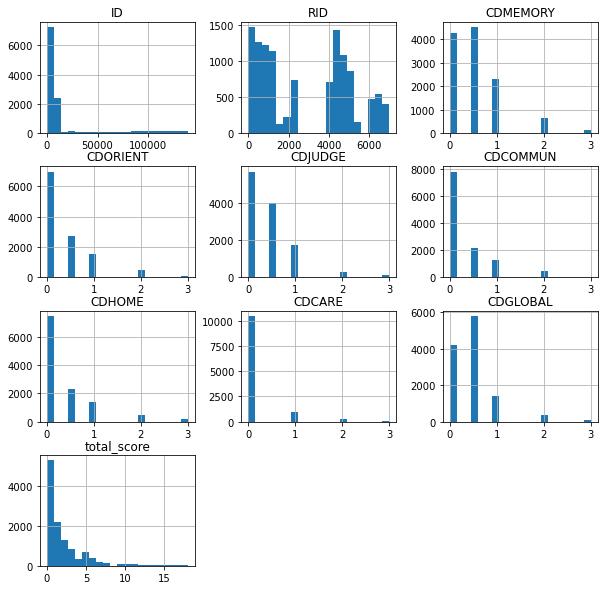

In [238]:
cdr.hist(figsize=(10,10),bins=20)
a=1

In [239]:
cdr.shape

(11806, 14)

In [240]:
cdr_dx = pd.merge(cdr, diag, how='left', on=['Phase', 'RID', 'VISCODE'])

print('No. of participants:', cdr_dx[['RID']].nunique())
print()
print('Mean total score, STD:', cdr_dx.groupby('DX')['total_score'].mean())
print('STD:', cdr_dx.groupby('DX')['total_score'].std())
print()
print('Mean CD GLOBAL:', cdr_dx.groupby('DX')['CDGLOBAL'].mean())
print('STD:', cdr_dx.groupby('DX')['CDGLOBAL'].std())

No. of participants: RID    3053
dtype: int64

Mean total score, STD: DX
1.0    0.109096
2.0    1.575109
3.0    5.913132
Name: total_score, dtype: float64
STD: DX
1.0    0.330765
2.0    1.139007
3.0    3.105448
Name: total_score, dtype: float64

Mean CD GLOBAL: DX
1.0    0.035328
2.0    0.474810
3.0    1.007897
Name: CDGLOBAL, dtype: float64
STD: DX
1.0    0.128141
2.0    0.157269
3.0    0.540300
Name: CDGLOBAL, dtype: float64


In [241]:
# How many entries did we lose to cleaning?
cdr_finish_entries = cdr.shape[0]
dropped_entries = cdr_start_entries - cdr_finish_entries
print(dropped_entries)
print(np.round(dropped_entries/cdr_start_entries*100, 2), '% removed')

499
4.06 % removed


In [242]:
# Writing df to csv.
df = cdr
df.to_csv('../../data/tabular_data/clean_CDR.csv', index=False)

### Geriatric Depression Scale (GDS)

The Geriatric Depression Scale (GDS) is an assessment used to identify depression in the elderly. The scale consists of 15 yes/no questions. Answers in bold suggest depression, they are scored with 1 point:  

YES/**NO** 1. Are you basically satisfied with your life?  
**YES**/NO 2. Have you dropped many of your activities and interests?   
**YES**/NO 3. Do you feel that your life is empty?   
**YES**/NO 4. Do you often get bored?   
YES/**NO** 5. Are you in good spirits most of the time?    
**YES**/NO 6. Are you afraid that something bad is going to happen to you?   
YES/**NO** 7. Do you feel happy most of the time?   
**YES**/NO 8. Do you often feel helpless?   
**YES**/NO 9. Do you prefer to stay at home, rather than going out and doing new things?   
**YES**/NO 10. Do you feel you have more problems with memory than most?   
YES/**NO** 11. Do you think it is wonderful to be alive now?   
**YES**/NO 12. Do you feel pretty worthless the way you are now?   
YES/**NO** 13. Do you feel full of energy?    
**YES**/NO 14. Do you feel that your situation is hopeless?   
**YES**/NO 15. Do you think that most people are better off than you are?   

In the dataframe, the answer "yes" is noted as 1 and answer "no" is noted as 0.    
This might be a source of confusion: Only answers indicative of depression are scored as 1 point. Sometimes that does not correspond to the noted number in the field. Example: 0 (no) in 1. question is scored with 1 point (indicates depression), but 0 in 2. question is scored as 0 points (not dropping activities is a sign of health).

Higher total score (GDTOTAL) denotes more depressive symptoms. 
A score of 5 or more suggests depression.

**GDS, maximum score = 15:**

**0   -     4    normal  
5   -     8    mild  
9   -   11    moderate  
12 -   15    severe**

Alzheimer's disease participants: "findings suggest that depressive symptoms in AD patients are associated with cortical
thinning in temporal and parietal regions." (Lebedeva, 2014)

<u>Sources:<u>
- https://adni.loni.usc.edu/adni-publications/Lebedeva_2014_JNNP.pdf
- https://geriatrictoolkit.missouri.edu/cog/GDS_SHORT_FORM.PDF
- http://www.medafile.com/GDS15.htm

In [243]:
gds = pd.read_csv('../../data/tabular_data/GDSCALE.csv')
gds.shape

(11372, 29)

In [244]:
gds_dict = pd.read_csv('../../data/tabular_data/GDSCALE_dict.csv')
gds_dict.style.set_properties(**{'text-align': 'left'}).hide_index()
gds_dict

,Phase,Phase.1
0,ID,Record ID
1,RID,Participant roster ID
2,SITEID,Site ID
3,VISCODE,Visit code
4,VISCODE2,Translated visit code: longutudinal progression
5,USERDATE,Date record created
6,USERDATE2,Date record last updated
7,EXAMDATE,Examination Date
8,GDSOURCE,Information Source: 1=Participant Visit;2=Tele...
9,GDUNABL,1=Participant is unable to complete the GDS(Ge...


This is a questionnaire that scores 'yes' with 1 and 'no' with 0, but just to keep us on our toes, the value 1 in cell sometimes counts as 1 point and sometimes as 0 points. :)   

Only a subset of columns is interesting to us. If a participant was unable to complete the test, this might be relevant, so we will retain the column for now.

In [245]:
gds_cols = gds.columns.tolist()
print()
print(gds_cols)
print()
gds.info()


['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'GDSOURCE', 'GDUNABL', 'GDUNABSP', 'GDSATIS', 'GDDROP', 'GDEMPTY', 'GDBORED', 'GDSPIRIT', 'GDAFRAID', 'GDHAPPY', 'GDHELP', 'GDHOME', 'GDMEMORY', 'GDALIVE', 'GDWORTH', 'GDENERGY', 'GDHOPE', 'GDBETTER', 'GDTOTAL', 'update_stamp']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11372 entries, 0 to 11371
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Phase         11372 non-null  object 
 1   ID            11372 non-null  int64  
 2   RID           11372 non-null  int64  
 3   SITEID        11372 non-null  int64  
 4   VISCODE       11372 non-null  object 
 5   VISCODE2      11341 non-null  object 
 6   USERDATE      11372 non-null  object 
 7   USERDATE2     2698 non-null   object 
 8   EXAMDATE      3130 non-null   object 
 9   GDSOURCE      11323 non-null  float64
 10  GDUNABL       11347 non-null  float64
 11  GDUN

In [246]:
# Columns we are interested in.
gds_columns = ['Phase', 'ID', 'RID', 'VISCODE', 'VISCODE2',  
               'GDUNABL', 'GDUNABSP', 'GDSATIS', 'GDDROP', 
               'GDEMPTY', 'GDBORED', 'GDSPIRIT', 'GDAFRAID',
               'GDHAPPY', 'GDHELP', 'GDHOME', 'GDMEMORY', 
               'GDALIVE', 'GDWORTH', 'GDENERGY', 'GDHOPE', 
               'GDBETTER', 'GDTOTAL', 'EXAMDATE']
gds = gds[gds_columns]

In [247]:
gds_start_entries = gds.shape[0]
gds_start_entries

11372

In [248]:
# Order VISCODE, Phases
am['Phase'] = am['Phase'].astype('category')
am['VISCODE'] = am['VISCODE'].astype('category')

am['Phase'] = am['Phase'].cat.set_categories(['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3'], ordered=True)
am['VISCODE'] = am['VISCODE'].cat.set_categories(['sc', 'bl', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48',
                                                  'm54', 'uns1', 'f', 'nv', 'scmri', 'm03', 'm60', 'm66', 'm72', 'm78', 'v01', 'v02',
                                                  'v03', 'v04', 'v05', 'v06', 'v07', 'v11', 'v12', 'v21', 'v22', 'v31',
                                                  'v32', 'v41', 'v42', 'v51', 'v52', 'tau', 'reg', 'init', 'y1', 'y2', 
                                                  'y3', 'y4', 'y5', 'y6'], ordered=True)

In [249]:
# How many participants were unable to complete the test?
print(gds['GDUNABL'].value_counts()[1])
x = np.round(gds['GDUNABL'].value_counts()[1] / gds.shape[0], 3)
print(x, '% of the participants were unable to complete the test.')

109
0.01 % of the participants were unable to complete the test.


In [250]:
gds[gds['GDUNABL'] == 1]

,Phase,ID,RID,VISCODE,VISCODE2,GDUNABL,GDUNABSP,GDSATIS,GDDROP,GDEMPTY,GDBORED,...,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
1419,ADNI1,2858,425,m12,m12,1.0,The nurse accidentally missed this form and di...,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2007-06-15
1435,ADNI1,2890,88,m12,m12,1.0,pt refused further testing - was becoming agit...,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2007-02-12
1591,ADNI1,3202,565,m12,m12,1.0,participant couldn't understand questions that...,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2007-08-02
1814,ADNI1,3650,93,m24,m24,1.0,unresponsive; lack of comprehension during int...,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2008-01-28
1965,ADNI1,3952,88,m24,m24,1.0,patient cannot respond approprately to questions,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2008-03-19
2397,ADNI1,4816,565,m24,m24,1.0,could not comprehend questions,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2008-08-07
2526,ADNI1,5074,1188,m24,m24,1.0,Administrative oversight,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2009-01-20
2613,ADNI1,5248,1382,m24,m24,1.0,"Questionnaire administered, sujbect couldn't a...",-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2009-04-22
2654,ADNI1,5332,1402,m24,m24,1.0,participant was too agitated and aggressive to...,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2009-05-28
2802,ADNI1,6268,1205,m24,m24,1.0,Not done/unknown,-4.0,-4.0,-4.0,-4.0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,2009-03-16


In [251]:
# Change hidden missing values.
gds = gds.replace(-1, np.NaN)    
gds = gds.replace(-4, np.NaN)

In [252]:
# For these we can't know - missing entry, or normal outcome, and thus nothing entered?
gds['GDUNABL'].isnull().sum()

8875

The number of participants, who could not complete the test is very small and the stated reasons are completely random 'The nurse accidentally missed this form'. We will just drop the columns.

In [253]:
gds = gds.drop(columns = ['GDUNABL', 'GDUNABSP'])

In [254]:
gds.isnull().sum()

Phase          0
ID             0
RID            0
VISCODE        0
VISCODE2      31
GDSATIS      160
GDDROP       160
GDEMPTY      161
GDBORED      160
GDSPIRIT     160
GDAFRAID     159
GDHAPPY      160
GDHELP       159
GDHOME       162
GDMEMORY     165
GDALIVE      162
GDWORTH      161
GDENERGY     160
GDHOPE       161
GDBETTER     162
GDTOTAL      171
EXAMDATE    8242
dtype: int64

In [255]:
gds = gds.dropna(subset=[
    'GDSATIS', 'GDDROP', 'GDEMPTY', 'GDBORED', 'GDSPIRIT',
    'GDAFRAID', 'GDHAPPY', 'GDHELP', 'GDHOME', 'GDMEMORY',
    'GDALIVE', 'GDWORTH', 'GDENERGY', 'GDHOPE', 'GDBETTER'
])

In [256]:
gds.isnull().sum()

Phase          0
ID             0
RID            0
VISCODE        0
VISCODE2      24
GDSATIS        0
GDDROP         0
GDEMPTY        0
GDBORED        0
GDSPIRIT       0
GDAFRAID       0
GDHAPPY        0
GDHELP         0
GDHOME         0
GDMEMORY       0
GDALIVE        0
GDWORTH        0
GDENERGY       0
GDHOPE         0
GDBETTER       0
GDTOTAL        4
EXAMDATE    8080
dtype: int64

In [257]:
gds['GDTOTAL'].unique()

array([ 1.,  3.,  0.,  2.,  5.,  4.,  8.,  7., 12., 11.,  6.,  9., 10.,
       13., 14., nan])

In [258]:
total = gds[gds['GDTOTAL'].isna()]

With some questions, "Yes" counts as 1 point, for other questions "No" counts as 1 point, according to the our data dictionary and the [Geriatric Depression Scale](https://www.vumc.org/cqa/sites/vumc.org.cqa/files/public_files/4%29%20Step%201%20-%20Geriatric%20Depression%20Scale.pdf). For these 4 entries we can map, which value in the df counts toward CDTOTAL and calcuate it.

In [259]:
cols = [
    'GDSATIS', 'GDDROP', 'GDEMPTY', 'GDBORED', 'GDSPIRIT',
    'GDAFRAID', 'GDHAPPY', 'GDHELP', 'GDHOME', 'GDMEMORY',
    'GDALIVE', 'GDWORTH', 'GDENERGY', 'GDHOPE', 'GDBETTER'
]

[total[cols]]

[       GDSATIS  GDDROP  GDEMPTY  GDBORED  GDSPIRIT  GDAFRAID  GDHAPPY  GDHELP  \
 10437      1.0     0.0      0.0      0.0       1.0       0.0      1.0     0.0   
 10708      1.0     1.0      0.0      1.0       1.0       0.0      1.0     0.0   
 10837      1.0     0.0      0.0      0.0       1.0       0.0      1.0     0.0   
 11036      1.0     1.0      0.0      0.0       1.0       0.0      1.0     0.0   
 
        GDHOME  GDMEMORY  GDALIVE  GDWORTH  GDENERGY  GDHOPE  GDBETTER  
 10437     0.0       0.0      1.0      0.0       1.0     0.0       0.0  
 10708     1.0       1.0      1.0      0.0       1.0     0.0       0.0  
 10837     1.0       0.0      1.0      0.0       1.0     0.0       0.0  
 11036     0.0       1.0      1.0      0.0       1.0     0.0       0.0  ]

In [260]:
# Which value in the table counts as +1 for the sum?
def cond_sum (x):
    mapping = {
        'GDSATIS':0,
        'GDDROP':1,
        'GDEMPTY':1,
        'GDBORED':1,
        'GDSPIRIT':0,
        'GDAFRAID':1,
        'GDHAPPY':0,
        'GDHELP':1,
        'GDHOME':1,
        'GDMEMORY':1,
        'GDALIVE':0,
        'GDWORTH':1,
        'GDENERGY':0,
        'GDHOPE':1,
        'GDBETTER':1        
    }
    
    result = 0
    for key, value in mapping.items():
        if x[key] == value:
            result += 1
    return result
        

gds[gds['GDTOTAL'].isna()].apply(cond_sum, axis=1)

10437    0
10708    4
10837    1
11036    2
dtype: int64

In [261]:
gds.at[10437, 'GDTOTAL'] = 0
gds.at[10708, 'GDTOTAL'] = 4
gds.at[10837, 'GDTOTAL'] = 1
gds.at[11036, 'GDTOTAL'] = 2

gds.isnull().sum()

Phase          0
ID             0
RID            0
VISCODE        0
VISCODE2      24
GDSATIS        0
GDDROP         0
GDEMPTY        0
GDBORED        0
GDSPIRIT       0
GDAFRAID       0
GDHAPPY        0
GDHELP         0
GDHOME         0
GDMEMORY       0
GDALIVE        0
GDWORTH        0
GDENERGY       0
GDHOPE         0
GDBETTER       0
GDTOTAL        0
EXAMDATE    8080
dtype: int64

In [262]:
# Merge exam dates.
gds = pd.merge(gds, examdate, how='left', on=['Phase', 'RID', 'VISCODE'])
gds.isnull().sum()

Phase            0
ID               0
RID              0
VISCODE          0
VISCODE2        24
GDSATIS          0
GDDROP           0
GDEMPTY          0
GDBORED          0
GDSPIRIT         0
GDAFRAID         0
GDHAPPY          0
GDHELP           0
GDHOME           0
GDMEMORY         0
GDALIVE          0
GDWORTH          0
GDENERGY         0
GDHOPE           0
GDBETTER         0
GDTOTAL          0
EXAMDATE_x    8080
EXAMDATE_y      14
dtype: int64

In [263]:
# Were the missing values in EXAMDATE_x again in ADNI3?
gds.tail()

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,...,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE_x,EXAMDATE_y
11187,ADNI3,138306,6349,y2,m36,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,2021-07-20
11188,ADNI3,138290,6402,y3,m36,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,2021-07-20
11189,ADNI3,138518,2333,y3,m120,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,2021-07-26
11190,ADNI3,138480,4598,y4,m108,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,NaN,2021-07-20
11191,ADNI3,138614,6988,sc,sc,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,NaN,2021-07-27


In [264]:
# List of participants with missing date.
gds[gds['EXAMDATE_y'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,...,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE_x,EXAMDATE_y
2084,ADNI1,4200,243,m24,m24,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2008-06-04,NaN
2827,ADNI1,5700,1430,m36,m36,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,2009-10-01,NaN
3718,ADNIGO,1262,830,m60,m60,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
8240,ADNI2,9106,5256,v11,m12,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN
8896,ADNI3,4527,907,init,m132,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
10418,ADNI3,100631,6214,sc,NaN,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN
10435,ADNI3,101675,981,y2,m156,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,NaN,NaN
10587,ADNI3,109073,6220,y1,NaN,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN
10739,ADNI3,116211,6375,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN
10814,ADNI3,119133,6252,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN


In [265]:
gds.at[2084, 'EXAMDATE_y'] = gds['EXAMDATE_x']
gds.at[2827, 'EXAMDATE_y'] = gds['EXAMDATE_x']

For participants, who have no exam date at screening, there is no sure way to infer the date, since we have no data on the past/next exam dates. These rows will be dropped.

For other participants the date can be inferred useing previous exam dates and VISCODE.

In [266]:
gds = gds.drop(gds[(gds['VISCODE'] == 'sc') & (gds['EXAMDATE_x'].isnull())].index)

In [267]:
gds = gds.drop('EXAMDATE_x', axis=1)
gds.columns = gds.columns.str.replace('EXAMDATE_y', 'EXAMDATE')

gds['EXAMDATE'].isnull().sum()

9

In [268]:
gds.isna().sum()

Phase        0
ID           0
RID          0
VISCODE      0
VISCODE2    21
GDSATIS      0
GDDROP       0
GDEMPTY      0
GDBORED      0
GDSPIRIT     0
GDAFRAID     0
GDHAPPY      0
GDHELP       0
GDHOME       0
GDMEMORY     0
GDALIVE      0
GDWORTH      0
GDENERGY     0
GDHOPE       0
GDBETTER     0
GDTOTAL      0
EXAMDATE     9
dtype: int64

In [269]:
gds[gds['EXAMDATE'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
3718,ADNIGO,1262,830,m60,m60,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN
8240,ADNI2,9106,5256,v11,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,NaN
8896,ADNI3,4527,907,init,m132,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
10435,ADNI3,101675,981,y2,m156,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,NaN
10587,ADNI3,109073,6220,y1,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
10739,ADNI3,116211,6375,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN
10814,ADNI3,119133,6252,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN
10928,ADNI3,124361,6419,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN
11082,ADNI3,132618,6362,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,NaN


In [270]:
gds[gds['RID'] == 830]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
694,ADNI1,1406,830,sc,sc,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2006-08-17
1573,ADNI1,3170,830,m12,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2007-09-17
2251,ADNI1,4534,830,m24,m24,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2008-09-25
2792,ADNI1,5626,830,m36,m36,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2009-09-21
3269,ADNIGO,350,830,m48,m48,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2010-09-23
3718,ADNIGO,1262,830,m60,m60,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN
4094,ADNI2,662,830,v06,m60,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2011-09-22


In [271]:
gds.at[3718, 'EXAMDATE'] = '2011-09-22'

In [272]:
gds[gds['RID'] == 5256]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
6565,ADNI2,5672,5256,v01,sc,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2013-07-02
7281,ADNI2,7138,5256,v05,m06,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,2014-02-06
8240,ADNI2,9106,5256,v11,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,NaN
8303,ADNI2,9234,5256,v21,m24,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2015-09-08


In [273]:
gds.at[8240, 'EXAMDATE'] = '2014-08-06'

In [274]:
gds[gds['RID'] == 907]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
769,ADNI1,1556,907,sc,sc,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2006-09-11
1653,ADNI1,3332,907,m12,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2007-10-30
2306,ADNI1,4644,907,m24,m24,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2008-10-30
2824,ADNI1,5694,907,m36,m36,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2009-10-27
3406,ADNIGO,628,907,m48,m48,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2010-12-13
4490,ADNI2,1464,907,v06,m60,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2012-01-23
6226,ADNI2,4992,907,v11,m72,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2013-03-27
8046,ADNI2,8710,907,v31,m96,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2015-02-25
8453,ADNI2,9550,907,v41,m108,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2016-01-29
8896,ADNI3,4527,907,init,m132,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN


In [275]:
gds.at[8896, 'EXAMDATE'] = '2018-01-29'

In [276]:
gds[gds['RID'] == 981]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
830,ADNI1,1678,981,sc,sc,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2006-10-05
1657,ADNI1,3340,981,m12,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2007-11-01
2335,ADNI1,4702,981,m24,m24,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2008-11-12
2992,ADNI1,5776,981,m36,m36,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2009-11-11
3425,ADNIGO,668,981,m48,m48,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2011-01-04
4877,ADNI2,2248,981,v06,m60,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2012-03-29
6199,ADNI2,4936,981,v11,m72,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2013-03-29
7441,ADNI2,7460,981,v21,m84,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2014-04-15
8362,ADNI2,10330,981,v31,m96,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2015-10-30
9374,ADNI3,34952,981,init,m132,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2017-10-11


In [277]:
gds.at[10435, 'EXAMDATE'] = '2019-10-11'

In [278]:
gds[gds['RID'] == 6220]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
10587,ADNI3,109073,6220,y1,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN


In [279]:
gds[gds['RID'] == 6375]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
10739,ADNI3,116211,6375,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN


In [280]:
gds[gds['RID'] == 6252]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
10322,ADNI3,96008,6252,y1,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2019-05-06
10814,ADNI3,119133,6252,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN


In [281]:
gds.at[10814, 'EXAMDATE'] = '2020-05-06'
gds.at[10814, 'VISCODE2'] = 'm24'

In [282]:
gds[gds['RID'] == 6419]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
10928,ADNI3,124361,6419,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN


In [283]:
gds[gds['RID'] == 6362]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
11082,ADNI3,132618,6362,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,NaN


In [284]:
gds.isna().sum()

Phase        0
ID           0
RID          0
VISCODE      0
VISCODE2    20
GDSATIS      0
GDDROP       0
GDEMPTY      0
GDBORED      0
GDSPIRIT     0
GDAFRAID     0
GDHAPPY      0
GDHELP       0
GDHOME       0
GDMEMORY     0
GDALIVE      0
GDWORTH      0
GDENERGY     0
GDHOPE       0
GDBETTER     0
GDTOTAL      0
EXAMDATE     4
dtype: int64

In [285]:
gds = gds.dropna(subset=['EXAMDATE'])

In [286]:
gds[gds['VISCODE2'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
10641,ADNI3,111588,4483,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2021-03-17
10687,ADNI3,113955,6651,y1,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2020-06-01
10711,ADNI3,115214,6291,y2,NaN,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,2021-11-11
10712,ADNI3,115233,6500,y2,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2021-11-17
10713,ADNI3,115222,6672,y1,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2020-06-01
10741,ADNI3,116354,6682,y1,NaN,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2020-07-31
10754,ADNI3,117133,4960,y2,NaN,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2020-06-18
10764,ADNI3,117370,6681,y1,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2020-07-01
10765,ADNI3,117380,6689,y1,NaN,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2020-08-01
10783,ADNI3,118189,4485,y3,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2020-08-25


In [287]:
# Fill all the NaN VISCODE2 for multindex ['Phase', 'RID', 'VISCODE'] with the respective VISCODE2 in reg df.
gds = gds.set_index(['Phase', 'RID', 'VISCODE'])
gds['VISCODE2'] = gds['VISCODE2'].fillna(reg.set_index(['Phase', 'RID', 'VISCODE'])['VISCODE2'])

In [288]:
# # Let's check, if missing VISCODE2 filled in.
# gds[gds['RID'] == 4483]

In [289]:
gds.reset_index(inplace=True)

In [290]:
gds.shape

(9971, 22)

In [291]:
gds[gds['VISCODE2'].isna()]

,Phase,RID,VISCODE,ID,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE


In [292]:
gds[gds['GDTOTAL'].isna()]

,Phase,RID,VISCODE,ID,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE


In [293]:
# Remove participants who failed screening (VISCODE = 'f')
gds = gds[gds.VISCODE != 'f']
gds

,Phase,RID,VISCODE,ID,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
0,ADNI1,2,sc,6,sc,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2005-08-17
1,ADNI1,3,sc,8,sc,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2005-08-18
2,ADNI1,4,sc,10,sc,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,2005-08-18
3,ADNI1,5,sc,12,sc,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2005-08-23
4,ADNI1,7,sc,14,sc,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2005-08-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,ADNI3,6206,y1,138327,m12,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,5.0,2019-04-30
9967,ADNI3,6349,y2,138306,m36,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2021-07-20
9968,ADNI3,6402,y3,138290,m36,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2021-07-20
9969,ADNI3,2333,y3,138518,m120,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2021-07-26


In [294]:
gds.isnull().sum()

Phase       0
RID         0
VISCODE     0
ID          0
VISCODE2    0
GDSATIS     0
GDDROP      0
GDEMPTY     0
GDBORED     0
GDSPIRIT    0
GDAFRAID    0
GDHAPPY     0
GDHELP      0
GDHOME      0
GDMEMORY    0
GDALIVE     0
GDWORTH     0
GDENERGY    0
GDHOPE      0
GDBETTER    0
GDTOTAL     0
EXAMDATE    0
dtype: int64

In [295]:
gds.sort_values(by= ['Phase', 'VISCODE', 'RID'])

,Phase,RID,VISCODE,ID,VISCODE2,GDSATIS,GDDROP,GDEMPTY,GDBORED,GDSPIRIT,GDAFRAID,GDHAPPY,GDHELP,GDHOME,GDMEMORY,GDALIVE,GDWORTH,GDENERGY,GDHOPE,GDBETTER,GDTOTAL,EXAMDATE
739,ADNI1,3,m12,1496,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2006-09-12
928,ADNI1,4,m12,1874,m12,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2006-11-14
724,ADNI1,5,m12,1466,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2006-09-05
947,ADNI1,6,m12,1912,m12,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2006-11-20
815,ADNI1,7,m12,1648,m12,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2006-10-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3442,ADNIGO,74,m72,1330,m72,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2012-01-05
3119,ADNIGO,116,m72,1358,m72,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2012-02-06
3114,ADNIGO,118,m72,1366,m72,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2012-02-13
3449,ADNIGO,120,m72,1376,m72,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2012-03-16


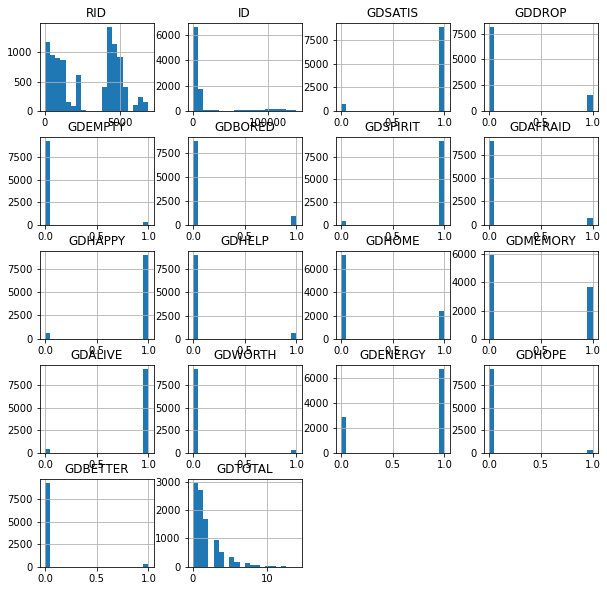

In [296]:
gds.hist(figsize=(10,10),bins=20)
a=1

In [297]:
# How many entries did we lose to cleaning?
gds_finish_entries = gds.shape[0]
dropped_entries = gds_start_entries - gds_finish_entries
print(dropped_entries)
print(np.round(dropped_entries/gds_start_entries*100, 2), '% removed')

1765
15.52 % removed


In [298]:
# Writing df to csv.
df = gds
df.to_csv('../../data/tabular_data/clean_GDSCALE.csv', index=False)

### Mini Mental State Examination (MMSE)

The Mini-Mental State Exam (MMSE) evaluates orientation, attention, memory, language and visual-spatial skills. It is fine-tuned for population over 55 years of age and is used as a test of cognitive function among the elderly.

    
[TEST EXAMPLE link](https://oxfordmedicaleducation.com/wp-content/uploads/2016/10/MMSE-printable-mini-mental-state-examination.pdf)

1. **Orientation** (10 points)
2. **Registration** (3 points) 
3. **Attention & calculation** (5 points)
4. **Recall** (3 points) 
5. **Language** (8 points) (Word list)
6. **Copying by drawing** (1 point)

The MMSE asks questions to ascertain cognitive status. Responses are scored as following:

0 = incorrect    
1 = correct   
6 = item administered, participant does not answer    
9 = test item not administered, unknown   

**MMSE (0–30):**  

**24-30 no cognitive impairment,  
18-23 = mild impairment,  
0-17 = severe impairment/dementia**

The MMSE does not test executive brain functions or frontal lobe functions including judgment, planning or impulsivity.
However, score <21 indicates increased odds of dementia, while score >25 indicates decreased odds of dementia.

<u>Sources:<u>
- https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/GetPdf.cgi?id=phd001525.1
- https://oxfordmedicaleducation.com/geriatrics/mini-mental-state-examination-mmse/
- http://www.cba.org/CBA/cle/PDF/ELD13_paper_shulman.pdf
- http://www.heartinstitutehd.com/Misc/Forms/MMSE.1276128605.pdf


In [299]:
# MMSE data dictionary, for information about the abbreviations in column names.
mmse_dict = pd.read_csv('../../data/tabular_data/MMSE_dict.csv', header=None)
mmse_dict.style.set_properties(**{'text-align': 'left'}).hide_index()

0,1
Phase,Phase
ID,Record ID
RID,Participant roster ID
SITEID,Site ID
VISCODE,Visit code
VISCODE2,Translated visit code: longitudinal progression
USERDATE,Date record created
USERDATE2,Date record last updated
EXAMDATE,Examination Date
MMDATE,1. What is today's date?1=Correct; 2=Incorrect


Columns:   
    
1. **Orientation (10 points)**: 'MMDATE', 'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR', 'MMCITY', 'MMAREA', 'MMSTATE',
2. **Registration** (3 points): 'MMBALL', 'MMFLAG', 'MMTREE', 'MMTRIALS'
3. **Attention & calculation** (5 points): 'MMD','MML', 'MMR', 'MMO', 'MMW'
4. **Recall** (3 points): 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL'
5. **Language** (8 points): 'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR', 'MMREAD', 'MMWRITE', 'WORLDSCORE'
6. **Copying by drawing** (1 point): 'MMDRAW'   

As we understand from the protocol, the columns after 'MMSCORE' are intended for testers' notes to make it easier for them to calculate some other scores, like WORLDSCORE (score obtained by the participant for each correct letter in 'WORLD' backwards.)   

One task is to spell the word WORLD backwards.
Columns MMLTR1-7 mark the letter that needed to be indicated for the participant (D, O, R ...).    

The 3 words used to test Registration and Recall (Ball/Apple, Flag/Penny, Tree/Table) are scored for correctness in columns MMBALL, MMFLAG, MMTREE (1=correct, 2=incorrect) and similarly in the 3 columns for recall (eg. MMBALL**DL**)
Columns WORD1/WORD1DL -  WORD3/WORD3DL are just translated entries for MMBALL/MMBALLDL, where instead of 1 and 2 values, the entries are 1 point for correct, 0 points for incorrect answer, to make it easier for the tester to sum up the total -> redundant columns? Or added due to changes in protocol?

In [300]:
cols = mmse_dict[0].tolist()
# cols

In [301]:
mmse = pd.read_csv('../../data/tabular_data/MMSE.csv')

# Change hidden missing values.
mmse = mmse.replace('-1', np.NaN)   
mmse = mmse.replace(-1, np.NaN) 
mmse = mmse.replace(-4, np.NaN)
mmse = mmse.replace('-4', np.NaN)
mmse = mmse.replace('-', np.NaN)

C:\Users\kfatur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (8,58,59,60,61,62,63,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [302]:
# mmse.info()

In [303]:
mmse.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,EXAMDATE,MMDATE,MMDATECM,...,MMLTR6,MMLTR7,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORDLIST,WORLDSCORE,update_stamp
0,ADNI1,10,2,107,sc,sc,2005-08-17,NaN,2005-08-17,1.0,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-17 00:00:00.0
1,ADNI1,12,1,10,f,f,2005-08-18,NaN,2005-08-18,1.0,18th,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
2,ADNI1,14,3,107,sc,sc,2005-08-18,NaN,2005-08-18,2.0,IDK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
3,ADNI1,16,4,10,sc,sc,2005-08-18,NaN,2005-08-18,1.0,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
4,ADNI1,18,5,107,sc,sc,2005-08-23,NaN,2005-08-23,1.0,23rd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-23 00:00:00.0


In [304]:
mmse_start_entries = mmse.shape[0]
mmse.shape

(12353, 74)

In [305]:
# Remove participants who failed screening (VISCODE = 'f')
mmse = mmse[mmse.VISCODE != 'f']
mmse.shape

(11946, 74)

In [306]:
# Order VISCODE, Phases
am['Phase'] = am['Phase'].astype('category')
am['VISCODE'] = am['VISCODE'].astype('category')

am['Phase'] = am['Phase'].cat.set_categories(['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3'], ordered=True)
am['VISCODE'] = am['VISCODE'].cat.set_categories(['sc', 'bl', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48',
                                                  'm54', 'uns1', 'f', 'nv', 'scmri', 'm03', 'm60', 'm66', 'm72', 'm78', 'v01', 'v02',
                                                  'v03', 'v04', 'v05', 'v06', 'v07', 'v11', 'v12', 'v21', 'v22', 'v31',
                                                  'v32', 'v41', 'v42', 'v51', 'v52', 'tau', 'reg', 'init', 'y1', 'y2', 
                                                  'y3', 'y4', 'y5', 'y6'], ordered=True)

In [307]:
# Drop redundant columns. 
mmse = mmse.drop(['USERDATE', 'USERDATE2'], axis=1)

In [308]:
mmse.isnull().sum()

Phase               0
ID                  0
RID                 0
SITEID              0
VISCODE             0
VISCODE2           16
EXAMDATE         8071
MMDATE             55
MMDATECM          101
MMYEAR             54
MMYEARCM           93
MMMONTH            56
MMMNTHCM           99
MMDAY              54
MMDAYCM            90
MMSEASON           54
MMSESNCM           88
MMHOSPIT           54
MMHOSPCM          104
MMFLOOR            54
MMFLRCM            91
MMCITY             54
MMCITYCM           89
MMAREA             54
MMAREACM          115
MMSTATE            54
MMSTCM             81
MMRECALL         6881
MMBALL           2319
MMFLAG           2319
MMTREE           2319
MMTRIALS         2327
MMD              2323
MMDLTR           2369
MML              2323
MMLLTR           2394
MMR              2323
MMRLTR           2444
MMO              2323
MMOLTR           2456
MMW              2323
MMWLTR           2697
MMBALLDL         2320
MMFLAGDL         2320
MMTREEDL         2320
MMWATCH   

In [309]:
# Fill all the NaN EXAMDATE for multindex ['Phase', 'RID', 'VISCODE'] with the respective EXAMDATE in reg df.
mmse = mmse.set_index(['Phase', 'RID', 'VISCODE'])
mmse['EXAMDATE'] = mmse['EXAMDATE'].fillna(reg.set_index(['Phase', 'RID', 'VISCODE'])['EXAMDATE'])
mmse.reset_index(inplace=True)
mmse[mmse['EXAMDATE'].isna()]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,MMDATE,MMDATECM,MMYEAR,MMYEARCM,...,MMLTR6,MMLTR7,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORDLIST,WORLDSCORE,update_stamp
4520,ADNIGO,830,m60,1352,21,m60,NaN,1.0,SEPTEMBER 22,1.0,2011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-07-08 19:02:06.0
9076,ADNI2,5256,v11,9024,1,m12,NaN,1.0,8,1.0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-09 19:18:06.0
9423,ADNI2,4555,v31,9730,2,m36,NaN,1.0,22,1.0,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-27 19:49:01.0
10979,ADNI3,2068,y1,97595,18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-13 11:16:40.0
11094,ADNI3,5273,y2,100318,52,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-13 11:16:40.0
11127,ADNI3,6082,y1,84690,49,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-13 11:16:40.0
11652,ADNI3,6375,y2,121665,4,NaN,NaN,1.0,9,1.0,2020,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2020-10-23 04:18:15.0
11696,ADNI3,6624,y2,123700,44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-19 15:29:44.0
11761,ADNI3,6909,sc,128234,12,NaN,NaN,1.0,the 24th,1.0,2021,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2021-02-25 04:18:41.0
11773,ADNI3,6688,y2,128826,50,NaN,NaN,1.0,4,1.0,2021,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2021-03-11 04:19:30.0


In [310]:
# Check letters.
mmse['MMLTR1'].unique()

array([nan, 'D', 'd', 'E', 'W', 'w', '0', 'l', 'O', 'L', 'o', 'y', 'P'],
      dtype=object)

In [311]:
mmse['MMLTR1'] = mmse['MMLTR1'].str.upper()
mmse['MMLTR2'] = mmse['MMLTR2'].str.upper()
mmse['MMLTR3'] = mmse['MMLTR3'].str.upper()
mmse['MMLTR4'] = mmse['MMLTR4'].str.upper()
mmse['MMLTR5'] = mmse['MMLTR5'].str.upper()
mmse['MMLTR6'] = mmse['MMLTR7'].str.upper()
# mmse['MMLTR1'].unique()

In [312]:
mmse['MMLTR7'].unique()

array([nan, '_'], dtype=object)

In [313]:
# Drop the column with no valid entries.
mmse = mmse.drop(['MMLTR7'], axis=1)

In [314]:
# MMSCORE is up to 30, no negative values.
print(mmse['MMSCORE'].max())
print(mmse['MMSCORE'].min())

30.0
0.0


In [315]:
mmse[mmse['MMSCORE'].isna()].head(20)

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,MMDATE,MMDATECM,MMYEAR,MMYEARCM,...,MMLTR5,MMLTR6,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORDLIST,WORLDSCORE,update_stamp
367,ADNI1,44,m06,1108,10,m06,2006-05-19,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-05-26 00:00:00.0
679,ADNI1,182,m06,1972,18,m06,2006-09-11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05 00:00:00.0
2647,ADNI1,726,m12,6124,19,m12,2007-11-14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-05-05 00:00:00.0
3168,ADNI1,1024,m24,7166,19,m24,2008-10-21,NaN,NaN,2.0,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-23 00:00:00.0
3276,ADNI1,1205,m24,8572,109,m24,2009-03-16,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-31 00:00:00.0
3413,ADNI1,1402,m24,7658,41,m24,2009-05-28,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-04 00:00:00.0
3474,ADNI1,1157,m24,7780,86,m24,2009-01-24,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-07-23 00:00:00.0
3512,ADNI1,1393,m48,8570,12,m48,2011-04-29,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-14 00:00:00.0
3696,ADNI1,1088,m36,8226,115,m36,2009-12-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-24 00:00:00.0
3698,ADNI1,1070,m36,8080,101,m36,2009-12-10,1.0,10,2.0,29009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-05 00:00:00.0


In [316]:
mmse[mmse['RID'] == 722]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,MMDATE,MMDATECM,MMYEAR,MMYEARCM,...,MMLTR5,MMLTR6,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORDLIST,WORLDSCORE,update_stamp
461,ADNI1,722,sc,1386,124,sc,2006-07-10,1.0,10-Jul-06,1.0,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-07-12 00:00:00.0
1247,ADNI1,722,m06,3302,124,m06,2007-02-28,1.0,28-Feb,1.0,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-03-02 00:00:00.0
1928,ADNI1,722,m12,4684,124,m12,2007-09-10,2.0,9/10/2008,1.0,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-09-12 00:00:00.0
2461,ADNI1,722,m18,5752,124,m18,2008-03-04,1.0,4-Mar,1.0,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-03-06 00:00:00.0
2956,ADNI1,722,m24,6742,124,m24,2008-09-17,1.0,17TH,1.0,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-09-18 00:00:00.0
3530,ADNI1,722,m36,7894,124,m36,2009-09-14,1.0,"Sept. 14, 2009",1.0,2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-09-15 00:00:00.0
3976,ADNIGO,722,m48,238,55,m48,2010-09-13,1.0,13,1.0,2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-16 09:41:07.0
4850,ADNI2,722,v06,558,55,m60,2011-08-22,1.0,22nd,1.0,2011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-16 12:25:07.0
6253,ADNI2,722,v11,3368,55,m72,2012-08-31,2.0,Sept 1,1.0,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-16 12:25:08.0
7678,ADNI2,722,v21,6222,55,m84,2013-09-05,1.0,5th,1.0,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-09-18 19:17:56.0


The entries with the missing MMSE Score mostly have NaN values in other cells as well, so we cannot calculate it by ourselves. It is also difficult to infer, why the values are missing, since sometimes (like with RID = 722), the test starts correctly, but is then prematurely ended with no values entered. There is no ground to conclude that the test was interrupted because the participant could not complete it - some of the participants involved only exhibit mild cognitive impairment and should be able to follow the task. Since the situation is unclear, the entries will be dropped.

In [317]:
mmse = mmse.dropna(subset=['MMSCORE'])

Also, only a smaller number of entries have information about which word list ("ball-flag-tree" or "apple-penny-table") they used.   
From the Protocol we know, that they mostly used the "ball-list" and we don't have sufficient data to compare the performance between the two lists (besides, there should be no significant difference, since the lists are construed based on the frequency of word use.) The column won't be included.

In [318]:
# Subset of columns we are interested in, we don't need verbatim responses (eg. 'MMDATECM' = 'the 24th'), just correct/incorrect information ('MMDATE').
# MMLTR1-7 columns note which letter was indicated in the word 'WORLD' backwards > 'D-L-R-O-W'
# Score for the 'WORLD' backwards spelling task: 'WORLDSCORE'
mmse = mmse[['Phase', 'ID', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE',
            'MMDATE', 'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 
            'MMHOSPIT', 'MMFLOOR', 'MMCITY', 'MMAREA', 'MMSTATE',
            'MMBALL', 'MMFLAG', 'MMTREE', 'MMTRIALS', 'MMD','MML',
             'MMR', 'MMO', 'MMW', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL', 
             'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 
             'MMONFLR', 'MMREAD', 'MMWRITE', 'MMDRAW', 'WORD1', 'WORD1DL',
             'WORD2', 'WORD2DL', 'WORD3', 'WORD3DL', 'WORLDSCORE', 'MMSCORE']]

pd.set_option('display.max_columns', 50)

In [319]:
mmse.head()

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
0,ADNI1,10,2,sc,sc,2005-08-17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
1,ADNI1,14,3,sc,sc,2005-08-18,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
2,ADNI1,16,4,sc,sc,2005-08-18,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0
3,ADNI1,18,5,sc,sc,2005-08-23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
4,ADNI1,22,7,sc,sc,2005-08-25,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0


In [320]:
mmse.isnull().sum()

Phase            0
ID               0
RID              0
VISCODE          0
VISCODE2        12
EXAMDATE         7
MMDATE           0
MMYEAR           0
MMMONTH          1
MMDAY            0
MMSEASON         0
MMHOSPIT         0
MMFLOOR          0
MMCITY           0
MMAREA           0
MMSTATE          0
MMBALL        2263
MMFLAG        2263
MMTREE        2263
MMTRIALS      2272
MMD           2264
MML           2264
MMR           2264
MMO           2264
MMW           2264
MMBALLDL      2263
MMFLAGDL      2263
MMTREEDL      2263
MMWATCH          1
MMPENCIL         1
MMREPEAT         1
MMHAND           1
MMFOLD           1
MMONFLR          1
MMREAD           0
MMWRITE          0
MMDRAW           1
WORD1         9622
WORD1DL       9621
WORD2         9622
WORD2DL       9620
WORD3         9622
WORD3DL       9620
WORLDSCORE    9631
MMSCORE          0
dtype: int64

In [321]:
mmse.shape

(11883, 45)

In [322]:
print (2263 + 9631)
print (2263 + 9620)

11894
11883


The curious thing is, that summing up the NaNs in columns MMBALL to MMTREEDL and WORLDSSCORE to WORD3DL comes very close to the number of all entries.   

It is possible that this is the same information, just encoded differently thoughout the Phases, meaning, in ADNI1 and ADNI2 they would enter the results for word list task in the MMBALL, MMFLAG, MMTREE columns, but in ADNI3 they would change the protocol and enter the values under WORD1, WORD2, WORD3?    

We should check that, but first we will fix minor things, like visit codes and dates.

We'll drop the individual entries with completely or partially missing test results.

In [323]:
# this is just one inccomplete entry, so we won't disect it in detail.
mmse = mmse.dropna(subset=['MMMONTH'])

In [324]:
mmse = mmse.dropna(subset=['MMWATCH'])

In [325]:
mmse = mmse.dropna(subset=['MMDRAW'])

In [326]:
mmse.shape

(11880, 45)

In [327]:
mmse[mmse['VISCODE2'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
9493,ADNI2,9870,5127,tau,NaN,2016-06-20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
9494,ADNI2,9872,5083,tau,NaN,2016-06-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
9592,ADNI2,10070,4552,tau,NaN,2016-10-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
9603,ADNI2,10092,4198,tau,NaN,2016-09-20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
9614,ADNI2,10114,5200,tau,NaN,2016-11-09,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
9653,ADNI2,10192,4028,tau,NaN,2016-01-12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
9654,ADNI2,10194,5126,tau,NaN,2015-11-30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
11652,ADNI3,121665,6375,y2,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,28.0
11761,ADNI3,128234,6909,sc,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0
11773,ADNI3,128826,6688,y2,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0


In [328]:
# 'tau' indicates that tau samples were taken, viscode2 = viscode.
# The remaining missing codes will be fixed with the help of EXAMDATE.
mmse.at[9493, 'VISCODE2'] = mmse['VISCODE'] 
mmse.at[9494, 'VISCODE2'] = mmse['VISCODE'] 
mmse.at[9592, 'VISCODE2'] = mmse['VISCODE'] 
mmse.at[9603, 'VISCODE2'] = mmse['VISCODE'] 
mmse.at[9614, 'VISCODE2'] = mmse['VISCODE'] 
mmse.at[9653, 'VISCODE2'] = mmse['VISCODE']
mmse.at[9654, 'VISCODE2'] = mmse['VISCODE'] 
mmse[mmse['VISCODE2'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
11652,ADNI3,121665,6375,y2,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,28.0
11761,ADNI3,128234,6909,sc,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0
11773,ADNI3,128826,6688,y2,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0
11793,ADNI3,129924,6839,y1,NaN,2021-03-25,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,20.0
11856,ADNI3,133453,6949,sc,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,29.0


In [329]:
# Let's try to fix date using the visit codes and previous dates of examinations.
mmse[mmse['RID'] == 6375]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
10329,ADNI3,42143,6375,sc,sc,2018-05-10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,27.0
11652,ADNI3,121665,6375,y2,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,28.0


In [330]:
# Previous exam for RID = 6375 at VISCODE2 'sc' was on 2018-05-10, so the exam at 'y2' happened approximately 24 months later.
# Date format: yyyy-mm-dd
mmse.at[11652, 'EXAMDATE'] = '2020-05-10'
mmse.at[11652, 'VISCODE2'] = 'm24'

In [331]:
mmse[mmse['RID'] == 6688]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
10812,ADNI3,75674,6688,sc,sc,2019-02-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,5.0,27.0
11488,ADNI3,110946,6688,y1,m12,2020-03-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,29.0
11773,ADNI3,128826,6688,y2,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0


In [332]:
mmse.at[11773, 'EXAMDATE'] = '2021-03-05'
mmse.at[11773, 'VISCODE2'] = 'm24'

In [333]:
mmse[mmse['RID'] == 6839]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
11350,ADNI3,103935,6839,sc,sc,2019-12-03,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,23.0
11793,ADNI3,129924,6839,y1,NaN,2021-03-25,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,20.0


In [334]:
mmse.at[11793, 'VISCODE2'] = 'm12'

RID 6839 got a very late first year examination (3 months later as appropriate), but we will consider this type of exam still as m12, since it was a yearly exam according to VISCODE.

In [335]:
mmse[mmse['RID'] == 6909]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
11761,ADNI3,128234,6909,sc,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0


In [336]:
mmse[mmse['RID'] == 6949]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
11856,ADNI3,133453,6949,sc,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,29.0


The participants with RIDs 6909 and 6949, who only completed 1 test at one examination and no date was entered, will be removed.

In [337]:
# Drop the entry with missing dates.
mmse = mmse.dropna(subset=['EXAMDATE'])

In [338]:
# Is participant 830 now complete, can we sort by dates?
mmse[mmse['RID'] == 830].sort_values(by='EXAMDATE')

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
548,ADNI1,1636,830,sc,sc,2006-08-17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
1359,ADNI1,3542,830,m06,m06,2007-04-03,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
1954,ADNI1,4736,830,m12,m12,2007-09-17,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
2519,ADNI1,5868,830,m18,m18,2008-03-24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
2974,ADNI1,6778,830,m24,m24,2008-09-25,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
3551,ADNI1,7936,830,m36,m36,2009-09-21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
4044,ADNIGO,396,830,m48,m48,2010-09-23,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
4905,ADNI2,668,830,v06,m60,2011-09-22,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0


In [339]:
# mmse.isnull().sum()

In [340]:
mmse[mmse['MMTRIALS'].isna()].sort_values(by = 'MMSCORE')

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMTRIALS,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
11414,ADNI3,107529,6100,y2,m24,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
11136,ADNI3,92460,6231,y1,m12,2019-07-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
11245,ADNI3,88324,6756,sc,sc,2019-07-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
11877,ADNI3,134879,6661,y2,m24,2021-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
10725,ADNI3,69739,6638,sc,sc,2018-11-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10345,ADNI3,43087,6386,sc,sc,2018-05-21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0
10342,ADNI3,43189,6354,sc,sc,2018-05-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0
10339,ADNI3,42905,6380,sc,sc,2018-05-16,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0
10353,ADNI3,44039,6392,sc,sc,2018-05-23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0


In [341]:
mmse['MMTRIALS'].unique()

array([ 1.,  2.,  4.,  3.,  5.,  6., nan])

Missing values in the number of trials are probably related to the changed manner of entering the test results in ADNI3 and will remain missing for those 2250+ entries. Since NEUROBAT test is more sensitive to trial and error we will dismiss this column entirely in MMSE due to the discrepancy in data quality and low information value.

In [342]:
mmse = mmse.drop(['MMTRIALS'], axis=1)

Our observation is also, that the columns MMBALL, MMFLAG, MMTREE mark the correct answer for the words 'ball', 'tree', 'flag'. In ADNI3 this correctness was marked under WORD1, WORD2, WORD3, because there are 2 lists with 3 words (ball, flag, tree / apple, penny, table) and they wanted to record the correct answer without specifying the list. The idea is to change the lists, so that the participants would not remember it from previous testing sessions, but they ended up using mostly the first list. (This is **not** very clearly marked in the [Protocol](https://adni.loni.usc.edu/wp-content/uploads/2012/10/ADNI3-Procedures-Manual_v3.0_20170627.pdf).)    

Spelling 'WORLD' backwards is recorded in the columns MMD, MML, MMR, MMO and MMW for earlier phases, but then in ADNI3 the sum of correct letters is entered just as sum in one column, 'WORLDSCORE.   

We need to unify these columns, since they basically hold the same kind of information.

The problem is also, that earlier, the wrong answer was encoded with '2', making it harder for us to just sum up the columns. We will encode wrong answer as '0' from now on.

In [343]:
mmse['MMBALL'].unique()

array([ 1.,  2., nan])

In [344]:
# Wrong answers will be encoded with 0 instead of 2, it makes it easier to sum up the columns.
mmse.loc[(mmse.MMBALL > 1), 'MMBALL'] = 0
mmse.loc[(mmse.MMFLAG > 1), 'MMFLAG'] = 0
mmse.loc[(mmse.MMTREE > 1), 'MMTREE'] = 0
mmse.loc[(mmse.MMBALLDL > 1), 'MMBALLDL'] = 0
mmse.loc[(mmse.MMFLAGDL > 1), 'MMFLAGDL'] = 0
mmse.loc[(mmse.MMTREEDL > 1), 'MMTREEDL'] = 0

In [345]:
mmse.loc[(mmse.MMDATE > 1), 'MMDATE'] = 0
mmse.loc[(mmse.MMYEAR > 1), 'MMYEAR'] = 0
mmse.loc[(mmse.MMMONTH > 1), 'MMMONTH'] = 0
mmse.loc[(mmse.MMDAY > 1), 'MMDAY'] = 0
mmse.loc[(mmse.MMSEASON > 1), 'MMSEASON'] = 0
mmse.loc[(mmse.MMHOSPIT  > 1), 'MMHOSPIT'] = 0
mmse.loc[(mmse.MMFLOOR > 1), 'MMFLOOR'] = 0
mmse.loc[(mmse.MMCITY > 1), 'MMCITY'] = 0
mmse.loc[(mmse.MMAREA > 1), 'MMAREA'] = 0
mmse.loc[(mmse.MMSTATE > 1), 'MMSTATE'] = 0

In [346]:
mmse['WORD1'].unique()

array([nan,  1.,  0.])

In [347]:
mmse['MMWATCH'].unique()

array([1., 2., 0.])

In [348]:
mmse.loc[(mmse.MMWATCH > 1), 'MMWATCH'] = 0
mmse.loc[(mmse.MMPENCIL > 1), 'MMPENCIL'] = 0
mmse.loc[(mmse.MMREPEAT > 1), 'MMREPEAT'] = 0
mmse.loc[(mmse.MMHAND > 1), 'MMHAND'] = 0
mmse.loc[(mmse.MMFOLD > 1), 'MMFOLD'] = 0
mmse.loc[(mmse.MMONFLR > 1), 'MMONFLR'] = 0
mmse.loc[(mmse.MMREAD > 1), 'MMREAD'] = 0
mmse.loc[(mmse.MMWRITE > 1), 'MMWRITE'] = 0
mmse.loc[(mmse.MMDRAW > 1), 'MMDRAW'] = 0

In [349]:
# How is letter W in spelling WORLD assessed? Correct = 1, incorrect = 2?
mmse['MMW'].unique()

array([ 1.,  2., nan])

In [350]:
# We need to change 2 to 0 to calculate 'WORLDSCORE' for missing entries.
mmse.loc[(mmse.MMD > 1), 'MMD'] = 0
mmse.loc[(mmse.MML > 1), 'MML'] = 0
mmse.loc[(mmse.MMR > 1), 'MMR'] = 0
mmse.loc[(mmse.MMO > 1), 'MMO'] = 0
mmse.loc[(mmse.MMW > 1), 'MMW'] = 0

In [351]:
pd.set_option('display.max_columns', 50)
mmse.head(10)

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMD,MML,MMR,MMO,MMW,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
0,ADNI1,10,2,sc,sc,2005-08-17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
1,ADNI1,14,3,sc,sc,2005-08-18,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
2,ADNI1,16,4,sc,sc,2005-08-18,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0
3,ADNI1,18,5,sc,sc,2005-08-23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
4,ADNI1,22,7,sc,sc,2005-08-25,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
5,ADNI1,24,8,sc,sc,2005-08-29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
6,ADNI1,30,14,sc,sc,2005-09-12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
7,ADNI1,32,16,sc,sc,2005-09-13,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
8,ADNI1,34,15,sc,sc,2005-09-15,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
9,ADNI1,38,19,sc,sc,2005-09-20,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0


In [352]:
# Calculate missing WORLDSCORE from columns counting correctness of each letter.
columns_list = ['MMD', 'MML', 'MMR', 'MMO', 'MMW']
mmse['WORLDSCORE_temp'] = mmse[columns_list].sum(axis=1)

In [353]:
# Fill the NaN in 'WORLDSCORE' from temp column.
mmse['WORLDSCORE'].fillna(mmse['WORLDSCORE_temp'], inplace=True)

In [354]:
# Drop individual columns for spelling D-L-R-O-W, drop temp column
mmse = mmse.drop(columns = columns_list, axis=1)
mmse = mmse.drop(['WORLDSCORE_temp'], axis=1)

In [355]:
mmse.head()

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
0,ADNI1,10,2,sc,sc,2005-08-17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,28.0
1,ADNI1,14,3,sc,sc,2005-08-18,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,20.0
2,ADNI1,16,4,sc,sc,2005-08-18,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,27.0
3,ADNI1,18,5,sc,sc,2005-08-23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,29.0
4,ADNI1,22,7,sc,sc,2005-08-25,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,20.0


In [356]:
# Where values for MMBALL, MMFLAG etc. are missing, these values are entered in WORD1, WORD2, WORD3 ...
mmse[mmse['MMBALL'].isna()]

,Phase,ID,RID,VISCODE,VISCODE2,EXAMDATE,MMDATE,MMYEAR,MMMONTH,MMDAY,MMSEASON,MMHOSPIT,MMFLOOR,MMCITY,MMAREA,MMSTATE,MMBALL,MMFLAG,MMTREE,MMBALLDL,MMFLAGDL,MMTREEDL,MMWATCH,MMPENCIL,MMREPEAT,MMHAND,MMFOLD,MMONFLR,MMREAD,MMWRITE,MMDRAW,WORD1,WORD1DL,WORD2,WORD2DL,WORD3,WORD3DL,WORLDSCORE,MMSCORE
9659,ADNI3,938,1078,init,m120,2017-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,4.0,14.0
9660,ADNI3,2013,120,init,m132,2017-03-29,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,29.0
9661,ADNI3,1486,1261,init,m120,2017-03-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0
9662,ADNI3,1175,1280,init,m120,2017-03-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0
9663,ADNI3,490,2183,init,m72,2017-01-13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11941,ADNI3,138287,6402,y3,m36,2021-07-20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0,27.0
11942,ADNI3,138431,6351,y2,m24,2020-08-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,29.0
11943,ADNI3,138512,2333,y3,m120,2021-07-26,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,24.0
11944,ADNI3,138474,4598,y4,m108,2021-07-20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0


In [357]:
# Fill missing values in WORD1 et co. from columns MMBALL et co. (the all test the same thing - how many of the 3 words did the participant remember).
# mmse['WORD1'].fillna(mmse['MMBALL'], inplace=True)
mmse['WORD2'].fillna(mmse['MMBALL'], inplace=True)
mmse['WORD1'].fillna(mmse['MMFLAG'], inplace=True)
mmse['WORD3'].fillna(mmse['MMTREE'], inplace=True)
mmse['WORD1DL'].fillna(mmse['MMBALLDL'], inplace=True)
mmse['WORD2DL'].fillna(mmse['MMFLAGDL'], inplace=True)
mmse['WORD3DL'].fillna(mmse['MMTREEDL'], inplace=True)

In [358]:
# Drop word columns from where the information was extracted to WORD1, WORD2, WORD3 ...
col_list = ['MMBALL', 'MMFLAG', 'MMTREE', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL']
mmse = mmse.drop(columns = col_list, axis=1)

In [359]:
# mmse.isnull().sum()

In [360]:
mmse = mmse.dropna()

New columns:

**Orientation (10 points):**
'MMDATE', 'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR', 'MMCITY', 'MMAREA', 'MMSTATE'
**Registration** (3 points): 'WORD1', 'WORD2', 'WORD3'  
**Attention & calculation** (5 points): 'WORLDSCORE'   
**Recall** (3 points): 'WORD1DL', 'WORD2DL', 'WORD3DL'  
**Language** (8 points): 'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR', 'MMREAD', 'MMWRITE'   
**Copying by drawing** (1 point): 'MMDRAW'


In [361]:
mmse.shape

(11874, 33)

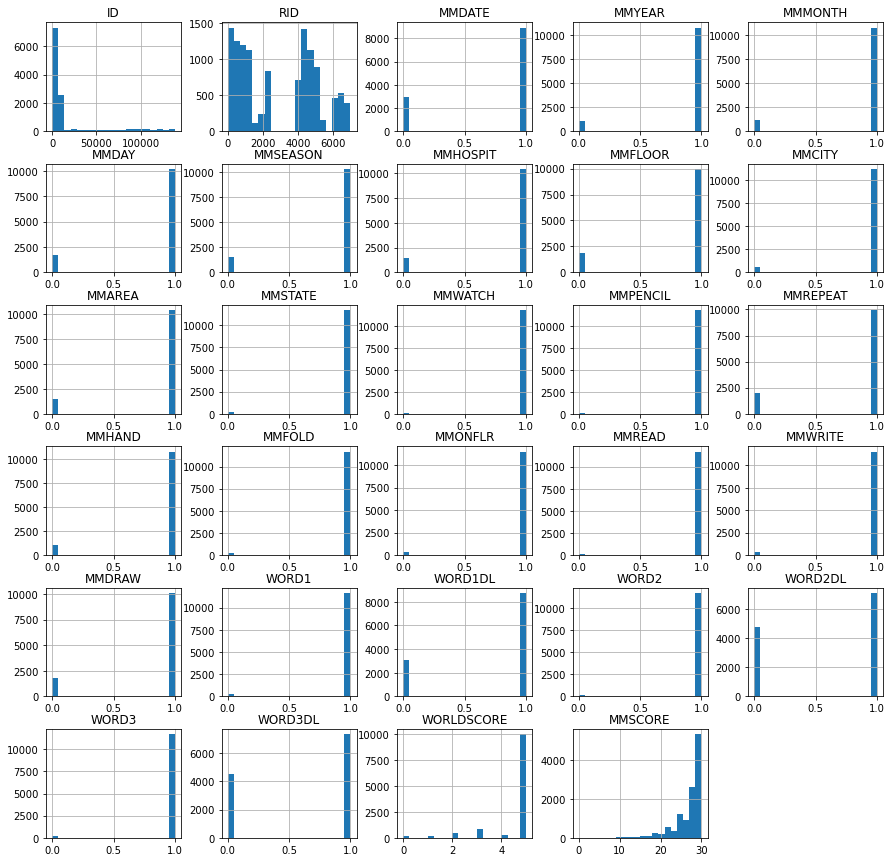

In [362]:
mmse.hist(figsize=(15,15),bins=20)
a=1

In [363]:
# How many entries did we lose to cleaning?
mmse_finish_entries = mmse.shape[0]
dropped_entries = mmse_start_entries - mmse_finish_entries
print(dropped_entries)
print(np.round(dropped_entries/mmse_start_entries*100, 2), '% removed')

479
3.88 % removed


In [364]:
# Writing df to csv.
df = mmse
df.to_csv('../../data/tabular_data/clean_MMSE.csv', index=False)

### Montreal Cognitive Assessment (MoCA) 

The Montreal Cognitive Assessment (MoCA) is a rapid screening instrument to assess mild cognitive dysfunction. It covers different cognitive domains: 

1. **Visuospatial/Executive**,
2. **Naming**, 
3. **Memory**, 
4. **Attention and calculation**, 
5. **Language**, 
6. **Conceptual thinking**,
7. **Delayed recall**,
8. **Orientation**.

**MoCa Scale (0-30):**  

**18-25 = mild cognitive impairment    
10-17 = moderate cognitive impairment   
< 10 = severe cognitive impairment**

"If the subject has 12 years of education or fewer, a point is added to his/her total score[, but] if a subject scores 30/30, a point is not added if he/she has 12 years of education or less."

"The cut-off score of 18 is usually considered to separate MCI from AD but there is an overlap in the scores since, by definition, AD is determined by the presence of cognitive impairment in addition to loss of autonomy.   

The average MoCA score for MCI is 22 (range 19-25) and the average MoCA score for Mild AD is 16 (11-21)." Source: [MoCa Test Website](https://www.mocatest.org/faq/)

According to the ADNI Procedures Manual, the MOCA total score is not calculated for ADNI.

<u>Sources:<u>
- https://www.mocatest.org/faq/
- https://www.dementia.org/diagnosing-dementia-the-montreal-cognitive-assessment
    
<u>Test samples<u>:
- https://www.parkinsons.va.gov/resources/MOCA-Test-English.pdf
- https://de.scribd.com/document/393713047/Montreal-cognitive-assessment-Basic-English-FINAL-VERSION-4-June-2014-pdf

In [365]:
moca_dict = pd.read_csv('../../data/tabular_data/MOCA_dict.csv', header=None)
moca_dict

,0,1
0,Phase,Phase
1,ID,Record ID
2,RID,Participant roster ID
3,SITEID,Site ID
4,VISCODE,Visit code
5,VISCODE2,Translated visit code: longitudinal progression
6,USERDATE,Date record created
7,USERDATE2,Date record last updated
8,TRAILS,Trails; 1=Correct; 0=Incorrect
9,CUBE,Copy Cube; 1=Correct; 0=Incorrect(ADNI2&3)


In [366]:
cols = moca_dict[0].tolist()
# cols

Columns (see [test example](https://static.seattletimes.com/wp-content/uploads/2018/01/0bb5d4b6-fbe7-11e7-93e1-366632afe6f9-780x1032.jpg) for clarity:
    
   **Visuospatial/executive**: 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN'   (**5** pts)
   
   **Naming**: 'LION', 'RHINO', 'CAMEL'    (**3** pts)    
   
   **Memory**:   (**no points**, counted only for delayed recall)
   
        > Recall of the read words in 1st trial: 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5'     
        > Recall of the read words in 2nd trial: 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5'  
        
   **Attention**:    
   
        > Reading digits: 'DIGFOR', 'DIGBACK'    (**2** pts)
        > Reading a list of letters: 'LETTERS'   (**1** pt; no points if no. of errors >= 2)
        > Serial substraction: 'SERIAL1', 'SERIAL2', 'SERIAL3', 'SERIAL4', 'SERIAL5'   
        (**3** pts; if only 2-3 correct substractions: **2** pts, if 1 correct substraction: **1** pt)
        
   **Language**: 'REPEAT1', 'REPEAT2', 'FFLUENCY'    (**2** pts for correct REPEAT, **1** pt if >=11 words listed)
   
   **Abstraction** (similarity between concepts): 'ABSTRAN', 'ABSMEAS'    (**2** pts)
   
   **Delayed recall** (word list from the Memory part): 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5'  (**5** pts)
   (Points only for uncued recall.)
   
   **Orientation**: 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY'      (**6** pts)  

In [367]:
moca = pd.read_csv('../../data/tabular_data/MOCA.csv')
moca.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,...,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA,update_stamp
0,ADNIGO,4,292,24,m48,m48,2010-05-27,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,2012-11-16 09:41:13.0
1,ADNIGO,6,1326,12,m36,m36,2010-05-30,2011-08-04,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,2012-11-16 09:41:13.0
2,ADNIGO,8,376,17,m48,m48,2010-06-02,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,2.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2012-11-16 09:41:13.0
3,ADNIGO,10,1117,12,m36,m36,2010-06-27,2011-11-08,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,2012-11-16 09:41:13.0
4,ADNIGO,12,618,21,m48,m48,2010-06-28,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2012-11-16 09:41:13.0


In [368]:
moca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7042 entries, 0 to 7041
Data columns (total 52 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Phase         7042 non-null   object 
 1   ID            7042 non-null   int64  
 2   RID           7042 non-null   int64  
 3   SITEID        7042 non-null   int64  
 4   VISCODE       7042 non-null   object 
 5   VISCODE2      7034 non-null   object 
 6   USERDATE      7042 non-null   object 
 7   USERDATE2     2853 non-null   object 
 8   TRAILS        6961 non-null   float64
 9   CUBE          6961 non-null   float64
 10  CLOCKCON      6950 non-null   float64
 11  CLOCKNO       6949 non-null   float64
 12  CLOCKHAN      6947 non-null   float64
 13  LION          6965 non-null   float64
 14  RHINO         6964 non-null   float64
 15  CAMEL         6965 non-null   float64
 16  IMMT1W1       6948 non-null   float64
 17  IMMT1W2       6949 non-null   float64
 18  IMMT1W3       6946 non-null 

In [369]:
# Order VISCODE, Phases
am['Phase'] = am['Phase'].astype('category')
am['VISCODE'] = am['VISCODE'].astype('category')

am['Phase'] = am['Phase'].cat.set_categories(['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3'], ordered=True)
am['VISCODE'] = am['VISCODE'].cat.set_categories(['sc', 'bl', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48',
                                                  'm54', 'uns1', 'f', 'nv', 'scmri', 'm03', 'm60', 'm66', 'm72', 'm78', 'v01', 'v02',
                                                  'v03', 'v04', 'v05', 'v06', 'v07', 'v11', 'v12', 'v21', 'v22', 'v31',
                                                  'v32', 'v41', 'v42', 'v51', 'v52', 'tau', 'reg', 'init', 'y1', 'y2', 
                                                  'y3', 'y4', 'y5', 'y6'], ordered=True)

In [370]:
# Change hidden missing values.
moca = moca.replace(-1, np.NaN)    
moca = moca.replace(-4, np.NaN)
moca = moca.replace('-1', np.NaN)    
moca = moca.replace('-4', np.NaN)

moca.isnull().sum()

Phase              0
ID                 0
RID                0
SITEID             0
VISCODE            0
VISCODE2           8
USERDATE           0
USERDATE2       4189
TRAILS            81
CUBE              81
CLOCKCON          92
CLOCKNO           93
CLOCKHAN          95
LION              77
RHINO             78
CAMEL             77
IMMT1W1           94
IMMT1W2           93
IMMT1W3           96
IMMT1W4           98
IMMT1W5           88
IMMT2W1          103
IMMT2W2           98
IMMT2W3          100
IMMT2W4          101
IMMT2W5           95
DIGFOR            78
DIGBACK           79
LETTERS           91
SERIAL1          102
SERIAL2          116
SERIAL3          123
SERIAL4          125
SERIAL5          127
REPEAT1           79
REPEAT2           80
FFLUENCY          87
ABSTRAN           92
ABSMEAS           93
DELW1            103
DELW2             98
DELW3            104
DELW4            106
DELW5            102
DATE              86
MONTH             86
YEAR              87
DAY          

In [371]:
moca_start_entries = moca.shape[0]

In [372]:
moca.shape

(7042, 52)

In [373]:
# Remove eventual participants who failed screening (VISCODE = 'f')
moca = moca[moca.VISCODE != 'f']

In [374]:
moca = moca.drop(columns = ['USERDATE', 'USERDATE2', 'update_stamp'])
moca.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
0,ADNIGO,4,292,24,m48,m48,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN
1,ADNIGO,6,1326,12,m36,m36,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN
2,ADNIGO,8,376,17,m48,m48,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,2.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3,ADNIGO,10,1117,12,m36,m36,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN
4,ADNIGO,12,618,21,m48,m48,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


<a id='moca_score'></a>
**Entries with MOCA score calculated**:
Some participants (1872) actually have their MOCA score entered, while the majority is missing this value. Let's quickly check the ones who do have the score, to see how complete the rows are.

We might want to check these values later, when we use our own formula to calculate the score for all entries and compare with the originally calculated score. [Compare with the calculated MOCA score.](#calculated_score)

In [375]:
moca[~moca['MOCA'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5106,ADNI3,389,74,20,init,m132,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,17.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0
5107,ADNI3,941,1078,27,init,m120,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
5108,ADNI3,244,2183,20,init,m72,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,10.0,1.0,1.0,3.0,2.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
5109,ADNI3,424,2219,20,init,m72,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9.0,1.0,1.0,0.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0
5110,ADNI3,230,2245,20,init,m72,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,ADNI3,138345,6402,6,y3,m36,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,10.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,22.0
7038,ADNI3,138355,6962,59,bl,bl,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,10.0
7039,ADNI3,138436,6351,13,y2,m24,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,27.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0
7040,ADNI3,138516,2333,55,y3,m120,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,2.0,0.0,3.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,15.0


In [376]:
moca['Phase'].unique()

array(['ADNIGO', 'ADNI2', 'ADNI3'], dtype=object)

MOCA test was not done in ADNI1!

In [377]:
moca[moca['VISCODE2'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
6146,ADNI3,84693,6082,49,y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6374,ADNI3,97598,2068,18,y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6424,ADNI3,100322,5273,52,y2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6796,ADNI3,121687,6375,4,y2,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0
6892,ADNI3,127760,6892,12,bl,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,17.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
6904,ADNI3,128833,6688,50,y2,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,11.0,1.0,1.0,3.0,3.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0
6922,ADNI3,129944,6839,12,y1,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,12.0
6957,ADNI3,132821,6931,12,bl,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,1.0,1.0,3.0,3.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0


In [378]:
# Get the index of entries with missing VISCODE2 and NaN values in all other cells and delete them right away.
i = moca[((moca.Phase == 'ADNI3') &( moca.RID == 6082) & (moca.VISCODE == 'y1'))].index
j = moca[((moca.Phase == 'ADNI3') &( moca.RID == 2068) & (moca.VISCODE == 'y1'))].index
k = moca[((moca.Phase == 'ADNI3') &( moca.RID == 5273) & (moca.VISCODE == 'y2'))].index

moca = moca.drop(i)
moca = moca.drop(j)
moca = moca.drop(k)

In [379]:
moca[moca['RID'] == 6375]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5768,ADNI3,58320,6375,4,bl,bl,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0
6796,ADNI3,121687,6375,4,y2,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0


In [380]:
moca.at[6796,'VISCODE2'] = 'm24'

In [381]:
moca[moca['RID'] == 6892]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
6892,ADNI3,127760,6892,12,bl,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,17.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0


In [382]:
# What is VISCODE2 for other participants with VISCODE 'bl'?

moca.Phase = pd.Categorical(moca.Phase, 
                      categories=['ADNI1', 'ADNI2', 'ADNIGO', 'ADNI3'],
                      ordered=True)

viscode = moca[moca['VISCODE'] == 'bl']
viscode.sort_values(by = ['Phase', 'VISCODE2']).tail(10)

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
7014,ADNI3,137162,6927,25,bl,bl,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,1.0,1.0,3.0,3.0,3.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,16.0
7015,ADNI3,137143,6969,24,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,19.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,22.0
7020,ADNI3,137252,6965,20,bl,bl,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,13.0,1.0,0.0,0.0,3.0,0.0,2.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,17.0
7024,ADNI3,137683,6941,12,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,22.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,26.0
7025,ADNI3,137652,6966,34,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,17.0,1.0,0.0,1.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
7030,ADNI3,137946,6920,11,bl,bl,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,13.0,1.0,0.0,3.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0
7034,ADNI3,138172,6964,55,bl,bl,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,0.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,19.0
7038,ADNI3,138355,6962,59,bl,bl,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,10.0
6892,ADNI3,127760,6892,12,bl,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,17.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
6957,ADNI3,132821,6931,12,bl,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,1.0,1.0,3.0,3.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0


In [383]:
moca.at[6892,'VISCODE2'] = 'bl'
moca.at[6957,'VISCODE2'] = 'bl'

In [384]:
moca[moca['RID'] == 6688]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
6028,ADNI3,77458,6688,50,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,14.0,1.0,1.0,0.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,22.0
6632,ADNI3,110953,6688,50,y1,m12,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,15.0,1.0,1.0,3.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,23.0
6904,ADNI3,128833,6688,50,y2,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,11.0,1.0,1.0,3.0,3.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0


In [385]:
moca.at[6904,'VISCODE2'] = 'm24'

In [386]:
moca[moca['RID'] == 6839]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
6549,ADNI3,106692,6839,12,bl,bl,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0
6922,ADNI3,129944,6839,12,y1,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,12.0


In [387]:
moca.at[6922,'VISCODE2'] = 'm12'

In [388]:
# How do the entries with missing values in 'TRAILS' column look like?
moca[moca['TRAILS'].isna()].head(10)          

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
75,ADNIGO,158,2106,5,bl,bl,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
104,ADNIGO,216,869,25,m48,m48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,ADNIGO,922,2210,56,m06,m06,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
469,ADNIGO,946,622,47,m60,m60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
566,ADNI2,184,552,26,v06,m60,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,0.0,0.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,ADNI2,190,161,7,v06,m60,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN
688,ADNI2,428,887,17,v06,m60,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
752,ADNI2,556,667,38,v06,m60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773,ADNI2,598,869,25,v06,m60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780,ADNI2,612,1389,51,v06,m48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [389]:
# Delete rows which have only visit codes and exam date, but no test values.
to_delete = moca.iloc[:, 6:]
to_delete = to_delete.columns.to_list()

moca.dropna(subset = to_delete, how = 'all', inplace = True)

print(moca.shape)
moca.head()

(6971, 49)


,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
0,ADNIGO,4,292,24,m48,m48,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN
1,ADNIGO,6,1326,12,m36,m36,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN
2,ADNIGO,8,376,17,m48,m48,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,2.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3,ADNIGO,10,1117,12,m36,m36,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,1.0,0.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN
4,ADNIGO,12,618,21,m48,m48,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [390]:
# moca.isnull().sum()

In [391]:
moca[moca['TRAILS'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
75,ADNIGO,158,2106,5,bl,bl,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
457,ADNIGO,922,2210,56,m06,m06,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
566,ADNI2,184,552,26,v06,m60,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,0.0,0.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,ADNI2,190,161,7,v06,m60,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN
688,ADNI2,428,887,17,v06,m60,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1984,ADNI2,3028,887,17,v11,m72,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2477,ADNI2,4018,1318,20,v11,m72,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,0.0,NaN
3406,ADNI2,5878,1057,2,v11,m72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4040,ADNI2,7146,5029,36,v11,m12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4580,ADNI2,8228,722,55,v41,m108,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,1.0,3.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [392]:
# Let's check performance of a couple of participants, where some segments of the test are missing.
moca[moca['RID'] == 2106]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
75,ADNIGO,158,2106,5,bl,bl,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
327,ADNIGO,662,2106,5,m06,m06,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,8.0,1.0,0.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
760,ADNI2,572,2106,5,v06,m12,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3216,ADNI2,5498,2106,5,v21,m36,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN


In [393]:
moca[moca['RID'] == 2210]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
252,ADNIGO,512,2210,56,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,10.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
457,ADNIGO,922,2210,56,m06,m06,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1064,ADNI2,1186,2210,56,v06,m12,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,11.0,0.0,1.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3818,ADNI2,6702,2210,56,v21,m36,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,1.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN
4286,ADNI2,7638,2210,56,v31,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,0.0,1.0,2.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4797,ADNI2,8670,2210,56,v41,m60,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,0.0,1.0,3.0,2.0,3.0,2.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,NaN


In [394]:
moca[moca['RID'] == 2106]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
75,ADNIGO,158,2106,5,bl,bl,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,1.0,1.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
327,ADNIGO,662,2106,5,m06,m06,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,8.0,1.0,0.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
760,ADNI2,572,2106,5,v06,m12,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3216,ADNI2,5498,2106,5,v21,m36,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN


In [395]:
moca[moca['RID'] == 5029]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
2185,ADNI2,3430,5029,36,v03,bl,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN
2848,ADNI2,4762,5029,36,v05,m06,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN
4040,ADNI2,7146,5029,36,v11,m12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can't be sure why the values in some rows are missing. Was the question not asked? Did the participant not reply, or wasn't able to?   

Assuming that the tester sometimes simply did not score a wrong answer, (and hence NaN is actually 0 points), doesn't seem valied, since some rows contain NaN, 0 (incorrect answer) and 1 (correct answer). 

Since we are risking a moderately low proportion of entries (10/6971 or 0.14%), we will drop the entries.

In [396]:
moca.shape

(6971, 49)

In [397]:
moca = moca[~moca['TRAILS'].isna()]

In [398]:
moca.shape

(6961, 49)

In [399]:
moca.isnull().sum()

Phase          0
ID             0
RID            0
SITEID         0
VISCODE        0
VISCODE2       0
TRAILS         0
CUBE           2
CLOCKCON      11
CLOCKNO       12
CLOCKHAN      14
LION           3
RHINO          4
CAMEL          3
IMMT1W1       19
IMMT1W2       18
IMMT1W3       21
IMMT1W4       23
IMMT1W5       13
IMMT2W1       28
IMMT2W2       23
IMMT2W3       25
IMMT2W4       26
IMMT2W5       20
DIGFOR         4
DIGBACK        5
LETTERS       16
SERIAL1       25
SERIAL2       39
SERIAL3       46
SERIAL4       48
SERIAL5       50
REPEAT1        4
REPEAT2        5
FFLUENCY      16
ABSTRAN       16
ABSMEAS       17
DELW1         28
DELW2         23
DELW3         29
DELW4         31
DELW5         27
DATE          12
MONTH         12
YEAR          13
DAY           14
PLACE         14
CITY          14
MOCA        5089
dtype: int64

In [400]:
moca.shape

(6961, 49)

In [401]:
moca[moca['IMMT1W1'].isna()].head(10)

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
1094,ADNI2,1246,4488,5,v03,bl,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,13.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1308,ADNI2,1674,1318,20,v06,m60,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3309,ADNI2,5684,4282,37,v21,m24,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4619,ADNI2,8308,8,8,v41,m120,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,12.0,0.0,1.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4937,ADNI2,8952,5202,30,v31,m36,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,22.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5138,ADNI3,2337,4254,16,init,m60,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,9.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0
5206,ADNI3,7884,4835,14,init,m60,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,18.0,1.0,1.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0
5311,ADNI3,14805,698,5,init,m132,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0
5354,ADNI3,18830,4414,25,init,m60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5929,ADNI3,69332,6073,9,y1,m12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,0.0,1.0,29.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,19.0


In [402]:
moca.dropna(subset=['IMMT1W1'], inplace=True)

In [403]:
moca[moca['CUBE'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
1211,ADNI2,1480,981,2,v06,m60,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,13.0,1.0,1.0,1.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3021,ADNI2,5108,5171,10,v03,bl,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [404]:
diag[diag['RID'] == 981]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
556,ADNI1,981,003_S_0981,102,bl,bl,2006-10-30,0,1.0
1350,ADNI1,981,003_S_0981,102,m06,m06,2007-05-02,0,1.0
2110,ADNI1,981,003_S_0981,102,m12,m12,2007-11-01,0,1.0
3118,ADNI1,981,003_S_0981,102,m24,m24,2008-11-12,0,1.0
3638,ADNI1,981,003_S_0981,102,m36,m36,2009-11-11,0,1.0
4213,ADNIGO,981,003_S_0981,2,m48,m48,2011-01-04,1.0,1.0
7141,ADNI2,981,003_S_0981,2,v06,m60,2012-03-29,1.0,1.0
8111,ADNI2,981,003_S_0981,2,v11,m72,2013-03-29,1.0,1.0
8942,ADNI2,981,003_S_0981,2,v21,m84,2014-04-15,1.0,1.0
9480,ADNI2,981,003_S_0981,2,v31,m96,2015-12-01,1.0,1.0


In [405]:
diag[diag['RID'] == 5171]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
5288,ADNI2,5171,013_S_5171,10,v01,sc,2013-05-01,1.0,1.0
6102,ADNI2,5171,013_S_5171,10,v03,bl,2013-09-03,1.0,1.0
6834,ADNI2,5171,013_S_5171,10,v05,m06,2014-02-05,1.0,1.0
8722,ADNI2,5171,013_S_5171,10,v21,m24,2015-09-09,1.0,1.0
10809,ADNI3,5171,013_S_5171,10,init,m60,2018-06-11,0,1.0
12215,ADNI3,5171,013_S_5171,10,y1,m72,2019-09-16,0,1.0


Both participants who have NaN in 'CUBE' are cognitively normal. It appears the testers simply dropped the task, assuming the participants would complete it.

In [406]:
moca[moca['RID'] == 981]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
174,ADNIGO,356,981,2,m48,m48,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,1.0,1.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1211,ADNI2,1480,981,2,v06,m60,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,13.0,1.0,1.0,1.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2536,ADNI2,4136,981,2,v11,m72,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3749,ADNI2,6564,981,2,v21,m84,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5104,ADNI2,9302,981,2,v31,m96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5327,ADNI3,16593,981,2,init,m132,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,1.0,2.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0


In [407]:
moca.columns

Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'TRAILS', 'CUBE',
       'CLOCKCON', 'CLOCKNO', 'CLOCKHAN', 'LION', 'RHINO', 'CAMEL', 'IMMT1W1',
       'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5', 'IMMT2W1', 'IMMT2W2',
       'IMMT2W3', 'IMMT2W4', 'IMMT2W5', 'DIGFOR', 'DIGBACK', 'LETTERS',
       'SERIAL1', 'SERIAL2', 'SERIAL3', 'SERIAL4', 'SERIAL5', 'REPEAT1',
       'REPEAT2', 'FFLUENCY', 'ABSTRAN', 'ABSMEAS', 'DELW1', 'DELW2', 'DELW3',
       'DELW4', 'DELW5', 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY',
       'MOCA'],
      dtype='object')

In [408]:
cols = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
moca.loc[moca['RID'] == 981, cols] = moca.loc[:, cols].fillna(1.0)
moca.loc[moca['RID'] == 5171, cols] = moca.loc[:, cols].fillna(1.0)

In [409]:
moca[moca['CLOCKCON'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
564,ADNI2,180,4071,26,v03,bl,0.0,0.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,11.0,1.0,1.0,0.0,3.0,2.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
734,ADNI2,520,150,26,v06,m60,1.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
743,ADNI2,538,539,26,v06,m60,0.0,0.0,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,11.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN
746,ADNI2,544,4001,26,v05,m06,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1231,ADNI2,1520,289,50,v06,m72,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
3033,ADNI2,5132,5071,10,v05,m06,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,18.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3173,ADNI2,5412,906,23,v21,m84,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5037,ADNI2,9154,842,6,v41,m108,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [410]:
# This participant converts from NC to MCI and back to NC, so infering the missing test results (assuming, that the test results would be similar to previous testing), seems unfounded.
diag[diag['RID'] == 842]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
474,ADNI1,842,009_S_0842,105,bl,bl,2006-10-09,0,1.0
1271,ADNI1,842,009_S_0842,105,m06,m06,2007-04-20,0,1.0
2037,ADNI1,842,009_S_0842,105,m12,m12,2007-10-16,0,1.0
3053,ADNI1,842,009_S_0842,105,m24,m24,2008-10-30,0,1.0
3590,ADNI1,842,009_S_0842,105,m36,m36,2009-10-09,0,1.0
4188,ADNIGO,842,009_S_0842,6,m48,m48,2010-12-13,1.0,1.0
7120,ADNI2,842,009_S_0842,6,v06,m60,2011-10-24,1.0,1.0
8092,ADNI2,842,009_S_0842,6,v11,m72,2012-10-31,4.0,2.0
8927,ADNI2,842,009_S_0842,6,v21,m84,2013-11-01,2.0,2.0
9474,ADNI2,842,009_S_0842,6,v31,m96,2014-10-15,2.0,2.0


In [411]:
diag[diag['RID'] == 4001]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
4343,ADNI2,4001,037_S_4001,26,v01,sc,2011-05-04,3.0,3.0
5399,ADNI2,4001,037_S_4001,26,v03,bl,2011-03-10,3.0,3.0
6181,ADNI2,4001,037_S_4001,26,v05,m06,2011-10-12,3.0,3.0
7281,ADNI2,4001,037_S_4001,26,v11,m12,2012-03-27,3.0,3.0
8225,ADNI2,4001,037_S_4001,26,v21,m24,2013-03-20,3.0,3.0


In [412]:
moca.loc[moca['RID'] == 4001, cols] = moca.loc[:, cols].fillna(0.0)

This participant (4001) has dementia, and if we compare it with other dementia patients, the CLOCK columns mostly get 0 points.   
For other participants it is more difficult to infer, what score would they achieve, so we will drop the missing values.

In [413]:
moca.dropna(subset=['CLOCKCON'], inplace=True)
moca.dropna(subset=['CLOCKNO'], inplace=True)

In [414]:
moca[moca['CLOCKHAN'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5641,ADNI3,47121,6358,15,bl,bl,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,1.0,1.0,NaN,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN
6796,ADNI3,121687,6375,4,y2,m24,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0


In [415]:
diag[diag['RID'] == 6358]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10233,ADNI3,6358,020_S_6358,15,bl,bl,2018-06-21,0,1.0
11340,ADNI3,6358,020_S_6358,15,sc,sc,2018-05-08,0,1.0


In [416]:
diag[diag['RID'] == 6375]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10245,ADNI3,6375,006_S_6375,4,bl,bl,2018-09-11,0,1.0
11357,ADNI3,6375,006_S_6375,4,sc,sc,2018-05-10,0,1.0


In [417]:
# Both 6358 and 6375 are cognitively normal, so it is expected that they could draw hands on a clock, as this is the normal result of this task.
moca.loc[moca['RID'] == 6358, cols] = moca.loc[:, cols].fillna(1.0)
moca.loc[moca['RID'] == 6375, cols] = moca.loc[:, cols].fillna(1.0)

In [418]:
moca[moca['LION'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5282,ADNI3,12495,6025,40,bl,bl,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6434,ADNI3,100676,6221,42,bl,bl,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [419]:
moca[moca['CITY'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
56,ADNIGO,118,667,38,m48,m48,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
467,ADNIGO,942,1387,19,m60,m60,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967,ADNI2,2994,4152,2,v11,m12,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,ADNI2,3190,4940,47,v03,bl,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,12.0,0.0,1.0,3.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,NaN,1.0,NaN,NaN
3116,ADNI2,5298,4912,8,v11,m12,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3477,ADNI2,6020,2060,58,v21,m36,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3687,ADNI2,6440,2216,37,v21,m36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4162,ADNI2,7390,4945,29,v21,m24,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,6.0,1.0,1.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4269,ADNI2,7604,1078,26,v31,m96,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4297,ADNI2,7660,4015,26,v41,m48,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [420]:
moca[moca['PLACE'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
56,ADNIGO,118,667,38,m48,m48,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
467,ADNIGO,942,1387,19,m60,m60,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967,ADNI2,2994,4152,2,v11,m12,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3116,ADNI2,5298,4912,8,v11,m12,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3477,ADNI2,6020,2060,58,v21,m36,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3687,ADNI2,6440,2216,37,v21,m36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4162,ADNI2,7390,4945,29,v21,m24,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,6.0,1.0,1.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4269,ADNI2,7604,1078,26,v31,m96,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4297,ADNI2,7660,4015,26,v41,m48,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5790,ADNI3,59487,4868,13,y1,m72,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [421]:
diag[diag['RID'] == 6047]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10043,ADNI3,6047,130_S_6047,50,bl,bl,2017-10-03,0,2.0
11072,ADNI3,6047,130_S_6047,50,sc,sc,2017-06-28,0,2.0
11921,ADNI3,6047,130_S_6047,50,y1,m12,2019-05-24,0,2.0
12425,ADNI3,6047,130_S_6047,50,y2,m24,2019-12-22,0,2.0
12827,ADNI3,6047,130_S_6047,50,y3,m36,2020-08-24,0,2.0


In [422]:
moca[moca['RID'] == 6047]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5239,ADNI3,9905,6047,50,bl,bl,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,25.0
5787,ADNI3,59361,6047,50,y1,m12,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,22.0
6310,ADNI3,94671,6047,50,y2,m24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,9.0,1.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN
6721,ADNI3,117944,6047,50,y3,m36,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,12.0,1.0,1.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,22.0


In [423]:
moca.dropna(subset=['CITY'], inplace=True)
moca.dropna(subset=['PLACE'], inplace=True)

In [424]:
moca['SERIAL3'].isna().sum()

39

In [425]:
moca['SERIAL5'].isna().sum()

43

In [426]:
moca[moca['SERIAL5'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
106,ADNIGO,220,906,23,m48,m48,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,11.0,1.0,0.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN
538,ADNI2,128,4001,26,v03,bl,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,8.0,1.0,0.0,2.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1659,ADNI2,2376,4477,59,v05,m06,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2090,ADNI2,3240,4737,37,v05,m06,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,11.0,1.0,1.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN
2117,ADNI2,3294,5018,1,v03,bl,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2148,ADNI2,4502,5026,50,v05,m06,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,17.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2365,ADNI2,3790,4477,59,v11,m12,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2454,ADNI2,3972,4001,26,v21,m24,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2470,ADNI2,4004,4549,59,v11,m12,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,0.0,1.0,10.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,NaN
2538,ADNI2,4140,126,17,v11,m84,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,NaN,NaN,1.0,0.0,14.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN


A possible explanations why not all SERIAL columns contain values is, that the testers tried to save time: if SERIAL1 and/or SERIAL2 (serial substraction of numbers) were 0, they did not continue with the task and we can assume that the missing values would be 0 in columns SERIAL2-5. This mostly occured with participants with moderate to significant cognitive deficits.    

If SERIAL1 and SERIAL2 (serial substraction of numbers) were 1, the testers also stopped, but in this case probably because they assumed the participant is capable of performing the task. This behaviour also correlates with higer score in FFLUENCY (> 15) for such participants, so it is probable that the participants would indeed complete the test.      

In line with our goal no to introduce bias, we would need to drop these rows. The problem ensues, because if we decide to drop the rows with missing SERIAL1-5 columns, we would remove additional entries belonging MCI and AD participants. The proportion is not in their favour either way, because there are many more normal controls.

However, the information we would infer, is very similar to imputing (just with a more naive and more bias-prone) approach, so we will drop this rows and sacrifice 40-something entries.

In [427]:
cols = ['SERIAL1', 'SERIAL2', 'SERIAL3', 'SERIAL4', 'SERIAL5']
moca.dropna(subset=cols, how='any', inplace=True)

In [428]:
moca[moca['IMMT1W1'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA


In [429]:
moca[moca['IMMT1W3'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
4828,ADNI2,8732,4547,8,v41,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,1.0,1.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5299,ADNI3,13843,5265,5,init,m48,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,11.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
5703,ADNI3,52935,6421,5,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,16.0,1.0,1.0,1.0,1.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
6268,ADNI3,92255,2403,50,y2,m96,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0
6456,ADNI3,101712,4188,9,y2,m96,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0
6738,ADNI3,118534,6513,15,y2,m24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,1.0,1.0,3.0,3.0,3.0,3.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
7001,ADNI3,136153,6948,25,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,22.0
7014,ADNI3,137162,6927,25,bl,bl,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,1.0,1.0,3.0,3.0,3.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,16.0
7034,ADNI3,138172,6964,55,bl,bl,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,0.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,19.0


In [430]:
moca[moca['IMMT2W1'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
174,ADNIGO,356,981,2,m48,m48,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,1.0,1.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
366,ADNIGO,740,1074,2,m48,m48,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,18.0,1.0,1.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
848,ADNI2,748,4288,2,v03,bl,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,14.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1264,ADNI2,1586,4469,40,v03,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,1.0,0.0,3.0,0.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1568,ADNI2,2194,4354,2,v05,m06,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1811,ADNI2,2680,4892,2,v03,bl,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,3.0,3.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3144,ADNI2,5354,4783,24,v11,m12,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,1.0,0.0,0.0,3.0,2.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN
5319,ADNI3,15482,4188,9,init,m72,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0
5711,ADNI3,53400,6449,15,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,25.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,28.0
5732,ADNI3,55014,6470,15,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,12.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,27.0


In [431]:
moca[moca['IMMT2W3'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
174,ADNIGO,356,981,2,m48,m48,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,1.0,1.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
366,ADNIGO,740,1074,2,m48,m48,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,18.0,1.0,1.0,3.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
848,ADNI2,748,4288,2,v03,bl,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,14.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1264,ADNI2,1586,4469,40,v03,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,1.0,0.0,3.0,0.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1568,ADNI2,2194,4354,2,v05,m06,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1811,ADNI2,2680,4892,2,v03,bl,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,3.0,3.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3144,ADNI2,5354,4783,24,v11,m12,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,14.0,1.0,0.0,0.0,3.0,2.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN
5319,ADNI3,15482,4188,9,init,m72,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0
5703,ADNI3,52935,6421,5,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,16.0,1.0,1.0,1.0,1.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0
5711,ADNI3,53400,6449,15,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,25.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,28.0


IMMT1-columns (and similarly IMMT2-columns) test the memory with the recall of words. The pattern in these columns allows us to believe that the missing values in this case are 0 (current values in the rows are either 1 or NaN), when at 1 or 2 coilumn values are missing.    

The rows with NaN in all 5 (10) columns denoting word recall will be dropped.

In [432]:
cols1 = ['IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols2 = ['IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5']
moca.dropna(subset = cols1, how='all', inplace=True)
moca.dropna(subset = cols2, how='all', inplace=True)

In [433]:
cols = cols1 + cols2
moca.dropna(subset=cols, inplace=True)

In [434]:
moca.dropna(subset=['IMMT2W4'], inplace=True)

In [435]:
moca[moca['DELW3'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
95,ADNIGO,198,2087,16,bl,bl,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,17.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,NaN
264,ADNIGO,536,2042,39,m06,m06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,NaN
1127,ADNI2,1312,4548,59,v03,bl,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,6.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1576,ADNI2,2210,4120,8,v11,m12,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,11.0,1.0,1.0,0.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2010,ADNI2,3080,4538,25,v05,m06,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4344,ADNI2,7754,5121,9,v21,m24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4614,ADNI2,8298,4271,27,v41,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,1.0,2.0,3.0,NaN,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4757,ADNI2,8590,4380,41,v41,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5133,ADNI3,2003,4071,27,init,m72,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,2.0,2.0,NaN,1.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
5622,ADNI3,45357,6279,23,bl,bl,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [436]:
diag[diag['RID'] == 6229]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10145,ADNI3,6229,070_S_6229,34,bl,bl,2018-03-27,0,2.0
11231,ADNI3,6229,070_S_6229,34,sc,sc,2018-02-13,0,2.0
11953,ADNI3,6229,070_S_6229,34,y1,m12,2019-04-02,0,2.0
12832,ADNI3,6229,070_S_6229,34,y3,m36,2021-03-31,0,2.0


In [437]:
moca[moca['RID'] == 6229]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5524,ADNI3,35372,6229,34,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,12.0,0.0,0.0,0.0,3.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,19.0
6060,ADNI3,79615,6229,34,y1,m12,1.0,0.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6926,ADNI3,130273,6229,34,y3,m36,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,21.0


In [438]:
cols = ['RHINO', 'ABSTRAN', 'ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4']
moca.dropna(subset = cols, how='all', inplace=True)

In [439]:
moca[moca['DELW1'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
95,ADNIGO,198,2087,16,bl,bl,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,17.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,NaN
264,ADNIGO,536,2042,39,m06,m06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,NaN
1127,ADNI2,1312,4548,59,v03,bl,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,6.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2010,ADNI2,3080,4538,25,v05,m06,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4344,ADNI2,7754,5121,9,v21,m24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4757,ADNI2,8590,4380,41,v41,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5446,ADNI3,26455,4176,24,init,m72,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,1.0,NaN,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5622,ADNI3,45357,6279,23,bl,bl,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5641,ADNI3,47121,6358,15,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,1.0,1.0,NaN,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN
6395,ADNI3,98684,4643,9,y2,m84,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [440]:
cols = ['ABSTRAN', 'ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4']
moca.dropna(subset = cols, how='all', inplace=True)

In [441]:
moca[moca['DELW3'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
95,ADNIGO,198,2087,16,bl,bl,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,17.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,NaN
264,ADNIGO,536,2042,39,m06,m06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,NaN
1127,ADNI2,1312,4548,59,v03,bl,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,6.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1576,ADNI2,2210,4120,8,v11,m12,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,11.0,1.0,1.0,0.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2010,ADNI2,3080,4538,25,v05,m06,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4344,ADNI2,7754,5121,9,v21,m24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4614,ADNI2,8298,4271,27,v41,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,1.0,2.0,3.0,NaN,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4757,ADNI2,8590,4380,41,v41,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5133,ADNI3,2003,4071,27,init,m72,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,2.0,2.0,NaN,1.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
6258,ADNI3,91735,4835,14,y2,m84,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1.0,3.0,2.0,NaN,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [442]:
cols = ['DELW1', 'DELW2', 'DELW3', 'DELW4']
moca.dropna(subset = cols, how='all', inplace=True)

In [443]:
cols = ['DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW4']
moca[cols] = moca[cols].fillna(0.0)

# Check, if one of RIDs with previously missing values is now complete.
moca[moca['RID'] == 4071]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
967,ADNI2,988,4071,26,v05,m06,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1547,ADNI2,2152,4071,26,v11,m12,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,11.0,1.0,1.0,2.0,3.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN
2943,ADNI2,4952,4071,26,v21,m24,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,1.0,0.0,2.0,3.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3987,ADNI2,7040,4071,26,v31,m36,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,3.0,3.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4634,ADNI2,8338,4071,26,v41,m48,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4976,ADNI2,9032,4071,26,v51,m60,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,1.0,3.0,3.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5133,ADNI3,2003,4071,27,init,m72,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,2.0,2.0,0.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN


In [444]:
moca[moca['LETTERS'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
482,ADNI2,16,1271,43,v06,m48,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
775,ADNI2,602,1260,27,v06,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,10.0,1.0,1.0,0.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1213,ADNI2,1484,4138,27,v05,m06,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,1.0,3.0,2.0,3.0,2.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN
4192,ADNI2,7450,1030,6,v31,m96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
4194,ADNI2,7454,230,48,v31,m108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4460,ADNI2,7986,566,26,v41,m108,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6334,ADNI3,95933,6777,61,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,1.0,1.0,0.0,3.0,0.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
6345,ADNI3,96160,6796,17,bl,bl,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
6416,ADNI3,99928,6822,17,bl,bl,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6792,ADNI3,121609,6503,9,y2,m24,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,3.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [445]:
moca[moca['FFLUENCY'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5291,ADNI3,13053,4488,5,init,m72,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,3.0,3.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
5410,ADNI3,23872,5228,47,init,m48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6150,ADNI3,84857,5132,47,y2,m72,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6223,ADNI3,89491,4224,37,y1,m96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6749,ADNI3,119580,6872,55,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6792,ADNI3,121609,6503,9,y2,m24,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,3.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [446]:
moca[moca['ABSMEAS'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
1078,ADNI2,1214,684,47,v06,m60,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,NaN,NaN,0.0,3.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3011,ADNI2,5088,4917,10,v11,m12,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
3255,ADNI2,5576,4985,10,v11,m12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,NaN,NaN,0.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN
6099,ADNI3,82015,6713,41,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6880,ADNI3,126730,6888,45,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,NaN,NaN,0.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN


In [447]:
moca.dropna(subset = ['LETTERS'], inplace=True)
moca.dropna(subset = ['FFLUENCY'], inplace=True)
moca.dropna(subset = ['SERIAL2'], inplace=True)

In [448]:
moca[moca['CAMEL'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5282,ADNI3,12495,6025,40,bl,bl,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6434,ADNI3,100676,6221,42,bl,bl,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [449]:
# This participant is cog. normal, the animals would be probably named correctly.
diag[diag['RID'] == 6025]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10027,ADNI3,6025,099_S_6025,40,bl,bl,2017-09-21,0,1.0
11052,ADNI3,6025,099_S_6025,40,sc,sc,2017-05-22,0,1.0
12591,ADNI3,6025,099_S_6025,40,y2,m30,2020-03-03,0,1.0
12952,ADNI3,6025,099_S_6025,40,y4,m48,2021-12-01,0,1.0


In [450]:
cols = ['LION', 'RHINO', 'CAMEL']
moca.loc[moca['RID'] == 6025, cols] = moca.loc[:, cols].fillna(1.0)

In [451]:
diag[diag['RID'] == 6221]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10139,ADNI3,6221,109_S_6221,42,bl,bl,2019-01-15,0,2.0
11225,ADNI3,6221,109_S_6221,42,sc,sc,2018-07-23,0,2.0


In [452]:
# We can't deduct, what this participant would answer.
moca[moca['RID'] == 6221]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
6434,ADNI3,100676,6221,42,bl,bl,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [453]:
moca.dropna(subset = ['LION'], inplace=True)

In [454]:
moca[moca['REPEAT2'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
5955,ADNI3,72139,6633,57,bl,bl,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,3.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [455]:
diag[diag['RID'] == 6633]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10403,ADNI3,6633,153_S_6633,57,bl,bl,2018-12-20,0,2.0
11566,ADNI3,6633,153_S_6633,57,sc,sc,2018-11-14,0,2.0


In [456]:
moca.dropna(subset = ['REPEAT2'], inplace=True)

In [457]:
moca.isna().sum()

Phase          0
ID             0
RID            0
SITEID         0
VISCODE        0
VISCODE2       0
TRAILS         0
CUBE           0
CLOCKCON       0
CLOCKNO        0
CLOCKHAN       0
LION           0
RHINO          0
CAMEL          0
IMMT1W1        0
IMMT1W2        0
IMMT1W3        0
IMMT1W4        0
IMMT1W5        0
IMMT2W1        0
IMMT2W2        0
IMMT2W3        0
IMMT2W4        0
IMMT2W5        0
DIGFOR         0
DIGBACK        0
LETTERS        0
SERIAL1        0
SERIAL2        0
SERIAL3        0
SERIAL4        0
SERIAL5        0
REPEAT1        0
REPEAT2        0
FFLUENCY       0
ABSTRAN        4
ABSMEAS        5
DELW1          0
DELW2          0
DELW3          0
DELW4          0
DELW5          3
DATE           0
MONTH          0
YEAR           0
DAY            0
PLACE          0
CITY           0
MOCA        4992
dtype: int64

In [458]:
moca[moca['ABSMEAS'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
1078,ADNI2,1214,684,47,v06,m60,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,NaN,NaN,0.0,3.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3011,ADNI2,5088,4917,10,v11,m12,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
3255,ADNI2,5576,4985,10,v11,m12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,NaN,NaN,0.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN
6099,ADNI3,82015,6713,41,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
6880,ADNI3,126730,6888,45,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,NaN,NaN,0.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN


In [459]:
diag[diag['RID'] == 684]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
389,ADNI1,684,127_S_0684,114,bl,bl,2006-08-10,0,1.0
1191,ADNI1,684,127_S_0684,114,m06,m06,2007-02-22,0,1.0
1960,ADNI1,684,127_S_0684,114,m12,m12,2007-08-24,0,1.0
2986,ADNI1,684,127_S_0684,114,m24,m24,2008-08-13,0,1.0
3550,ADNI1,684,127_S_0684,114,m36,m36,2009-08-17,0,1.0
4170,ADNIGO,684,127_S_0684,47,m48,m48,2010-09-17,1.0,1.0
7099,ADNI2,684,127_S_0684,47,v06,m60,2012-06-21,1.0,1.0
8074,ADNI2,684,127_S_0684,47,v11,m72,2012-11-07,1.0,1.0
8910,ADNI2,684,127_S_0684,47,v21,m84,2013-08-13,1.0,1.0
9466,ADNI2,684,127_S_0684,47,v31,m96,2014-08-29,1.0,1.0


In [460]:
# Cognitively normal, but relatively low MOCA score.
# Based on the score, we infer that missing values in this case are 0.
cols = ['ABSTRAN', 'ABSMEAS']
moca.loc[moca['RID'] == 684, cols] = moca.loc[:, cols].fillna(0.0)

In [461]:
diag[diag['RID'] == 4917]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
5091,ADNI2,4917,013_S_4917,10,v01,sc,2012-08-29,2.0,2.0
5967,ADNI2,4917,013_S_4917,10,v03,bl,2012-10-10,2.0,2.0
6709,ADNI2,4917,013_S_4917,10,v05,m06,2013-03-20,2.0,2.0
7797,ADNI2,4917,013_S_4917,10,v11,m12,2013-09-03,2.0,2.0


In [462]:
diag[diag['RID'] == 4985]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
5146,ADNI2,4985,013_S_4985,10,v01,sc,2012-10-10,2.0,2.0
6004,ADNI2,4985,013_S_4985,10,v03,bl,2012-12-19,2.0,2.0
6745,ADNI2,4985,013_S_4985,10,v05,m06,2013-04-23,2.0,2.0
7831,ADNI2,4985,013_S_4985,10,v11,m12,2013-11-13,2.0,2.0
8676,ADNI2,4985,013_S_4985,10,v21,m24,2014-12-03,2.0,2.0


In [463]:
diag[diag['RID'] == 6888]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10554,ADNI3,6888,123_S_6888,45,bl,bl,2020-10-07,0,2.0
11775,ADNI3,6888,123_S_6888,45,sc,sc,2020-10-01,0,2.0
12118,ADNI3,6888,123_S_6888,45,y1,m12,2021-10-18,0,2.0


In [464]:
diag[diag['RID'] == 6713]

,Phase,RID,PTID,SITEID,VISCODE,VISCODE2,EXAMDATE,DXCHANGE,DX
10450,ADNI3,6713,100_S_6713,41,bl,bl,2019-05-10,0,3.0
11633,ADNI3,6713,100_S_6713,41,sc,sc,2019-04-10,0,3.0
12175,ADNI3,6713,100_S_6713,41,y1,m30,2021-09-03,0,3.0


In [465]:
# A person with dementia, with RID = 6713, achieved a high (almost perfect) score on MOCA, how many years of education does this person have(PTEDUCAT), how old is she (AGE)?
print(dem[dem['RID'] == 6713])
print(am[am['RID'] == 6713])

      Phase     ID   RID  SITEID VISCODE VISCODE2 PTGENDER  PTDOBYY PTHAND  \
3894  ADNI3  79721  6713      41      sc       sc      2.0   1948.0    1.0   

     PTMARRY PTEDUCAT PTPLANG PTETHCAT PTRACCAT  
3894     1.0     16.0     1.0      2.0      5.0  
        RID  Phase  SITE VISCODE   EXAMDATE DX_bl   AGE PTGENDER  PTEDUCAT  \
15561  6713  ADNI3   100      bl 2019-05-01    AD  71.1   Female        16   
15562  6713  ADNI3   100     m30 2021-09-01    AD  71.1   Female        16   

              PTETHCAT PTRACCAT  PTMARRY        DX EXAMDATE_bl  
15561  Not Hisp/Latino    White  Married  Dementia  2019-05-01  
15562  Not Hisp/Latino    White  Married  Dementia  2019-05-01  


We learn that this person is 71 years old and has had 16 years of education. This leads us to reconsider some things for model building: to make a good model, we would probably need to account for education effects well as age effects, on top of the basic model.

In [466]:
# What are other results in abstract columns (ABSEMEAS, ABSTRAN) for this person?
moca[moca['RID'] == 6888]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
6880,ADNI3,126730,6888,45,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,NaN,NaN,0.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN


In [467]:
moca[moca['RID'] == 4917]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
1907,ADNI2,2872,4917,10,v03,bl,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2491,ADNI2,4046,4917,10,v05,m06,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,1.0,1.0,2.0,2.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
3011,ADNI2,5088,4917,10,v11,m12,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN


In [468]:
moca[moca['RID'] == 4985]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
2207,ADNI2,3474,4985,10,v03,bl,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN
2576,ADNI2,4216,4985,10,v05,m06,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,2.0,1.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3255,ADNI2,5576,4985,10,v11,m12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,NaN,NaN,0.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN
4087,ADNI2,7240,4985,10,v21,m24,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN


In [469]:
# For this person (6713), and other participants with NaN in ABSMEAS, NaN probably counted as 0.
# (Based on previous scores, their diagnosis and other test results over all other visits).
col = ['ABSMEAS']
moca.loc[moca['RID'] == 6713, col] = moca.loc[:, col].fillna(0.0)

cols = ['ABSTRAN', 'ABSMEAS']
moca.loc[moca['RID'] == 4917, cols] = moca.loc[:, col].fillna(0.0)
moca.loc[moca['RID'] == 4985, cols] = moca.loc[:, col].fillna(0.0)
moca.loc[moca['RID'] == 6888, cols] = moca.loc[:, col].fillna(0.0)

In [470]:
moca[moca['RID'] == 6713]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
6099,ADNI3,82015,6713,41,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [471]:
moca[moca['ABSTRAN'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,DIGBACK,LETTERS,SERIAL1,SERIAL2,SERIAL3,SERIAL4,SERIAL5,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,MOCA
1907,ADNI2,2872,4917,10,v03,bl,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0,NaN,1.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2207,ADNI2,3474,4985,10,v03,bl,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,NaN,0.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN
2491,ADNI2,4046,4917,10,v05,m06,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,NaN,1.0,2.0,2.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
2576,ADNI2,4216,4985,10,v05,m06,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,NaN,0.0,2.0,1.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3011,ADNI2,5088,4917,10,v11,m12,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
3255,ADNI2,5576,4985,10,v11,m12,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,NaN,0.0,0.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN
4087,ADNI2,7240,4985,10,v21,m24,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,NaN,0.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN
6880,ADNI3,126730,6888,45,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,NaN,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN


In [472]:
moca.dropna(subset = ['ABSTRAN'], axis = 0, inplace=True)

In [473]:
# Since MOCA column has a lot of NaN and we know how to calculate the score, we'll make a new one.
moca.drop('MOCA', axis=1, inplace=True)

There are specific rules to score the columns, so first we will prepare the df for summing up the values per row, as it is not a straightforward sum.

In [474]:
# Column 'LETTERS' contains the number of errors and not points, so whenever the value in this column is >= 2, it counts as 0 points.  
moca['LETTERS_points'] = moca[['LETTERS']].apply(lambda x: 0 if x['LETTERS'] >= 2 else 1, axis=1)

In [475]:
# Sum the points in these columns.
moca['SERIAL_sum'] = moca.loc[:,['SERIAL1', 'SERIAL2', 'SERIAL3', 'SERIAL4', 'SERIAL5']].sum(axis=1)

# Columns SERIAL1-5: if the sum of columns is 4+: 3 points, if the sum is 2 or 3: 2 points, for sum 1: 1 point, else 0
# Map sum of columns to points for columns.
serial_points = {5: 3, 4: 3, 3: 2, 2: 2, 1: 1, 0: 0}
moca['SERIAL_points'] = moca['SERIAL_sum'].map(serial_points)

In [476]:
# FFLUENCY: 1 point if the participant lists 11+ words ('FFLUENCY' >= 11 --> 1 point) 
moca['FLUENCY_points'] = moca[['FFLUENCY']].apply(lambda x: 1 if x['FFLUENCY'] >= 11 else 0, axis=1)

In [477]:
moca['DELW1'].unique()

array([0., 3., 2., 1.])

In [478]:
moca['DELW5'].unique()

array([ 0.,  3.,  1.,  2., nan])

In [479]:
moca.dropna(subset = ['DELW5'], axis=0, inplace=True)

In [480]:
# DELW1-5: 1 point if the participant recalls the word without cue (values 2 and 3 indicate cueing and count as 0 points) 
recall_points = {3: 0, 2: 0, 1: 1, 0: 0}
moca['RECALL1'] = moca['DELW1'].map(recall_points)
moca['RECALL2'] = moca['DELW2'].map(recall_points)
moca['RECALL3'] = moca['DELW3'].map(recall_points)
moca['RECALL4'] = moca['DELW4'].map(recall_points)
moca['RECALL5'] = moca['DELW5'].map(recall_points)

In [481]:
# Are the results as expected?
moca.head(10)

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,...,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,LETTERS_points,SERIAL_sum,SERIAL_points,FLUENCY_points,RECALL1,RECALL2,RECALL3,RECALL4,RECALL5
0,ADNIGO,4,292,24,m48,m48,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,5.0,3,0,0,0,0,0,0
1,ADNIGO,6,1326,12,m36,m36,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1.0,1,0,0,0,0,0,0
2,ADNIGO,8,376,17,m48,m48,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,5.0,0.0,0.0,0.0,2.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1,5.0,3,0,0,0,0,0,0
3,ADNIGO,10,1117,12,m36,m36,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,11.0,1.0,0.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0.0,0,1,0,0,0,0,0
4,ADNIGO,12,618,21,m48,m48,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,12.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,5.0,3,1,0,1,0,0,1
5,ADNIGO,14,2002,48,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,30.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,5.0,3,1,0,1,0,1,1
6,ADNIGO,16,2007,12,bl,bl,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,20.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1,5.0,3,1,0,0,0,0,0
7,ADNIGO,18,2010,1,bl,bl,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,18.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,5.0,3,1,1,1,0,0,1
8,ADNIGO,20,622,47,m48,m48,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,10.0,1.0,1.0,2.0,3.0,1.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1,3.0,2,0,0,0,1,0,0
9,ADNIGO,22,685,1,m48,m48,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,11.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1,5.0,3,1,0,0,0,0,0


In [482]:
moca.shape

(6800, 57)

In [483]:
moca.drop('SERIAL_sum', axis=1, inplace=True)

In [484]:
# Columns which don't count for final score.  
dont_count = ['IMMT1W1', 
              'IMMT1W2',
              'IMMT1W3',
              'IMMT1W4',
              'IMMT1W5',
              'IMMT2W1',
              'IMMT2W2',
              'IMMT2W3',
              'IMMT2W4',
              'IMMT2W5',
              'LETTERS',
              'SERIAL1',
              'SERIAL2',
              'SERIAL3',
              'SERIAL4',
              'SERIAL5',
              'FFLUENCY', 
              'DELW1', 
              'DELW2', 
              'DELW3', 
              'DELW4', 
              'DELW5']


# Column to calculate MOCA score.
moca['MOCASCORE'] = moca.iloc[:,6:].sum(axis=1) - moca[dont_count].sum(axis=1)

# # Fill the NaN in 'WORLDSCORE' from temp column.
# mmse['WORLDSCORE'].fillna(mmse['WORLDSCORE_temp'], inplace=True)

In [485]:
moca.head(10)

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,TRAILS,CUBE,CLOCKCON,CLOCKNO,CLOCKHAN,LION,RHINO,CAMEL,IMMT1W1,IMMT1W2,IMMT1W3,IMMT1W4,IMMT1W5,IMMT2W1,IMMT2W2,IMMT2W3,IMMT2W4,IMMT2W5,DIGFOR,...,REPEAT1,REPEAT2,FFLUENCY,ABSTRAN,ABSMEAS,DELW1,DELW2,DELW3,DELW4,DELW5,DATE,MONTH,YEAR,DAY,PLACE,CITY,LETTERS_points,SERIAL_points,FLUENCY_points,RECALL1,RECALL2,RECALL3,RECALL4,RECALL5,MOCASCORE
0,ADNIGO,4,292,24,m48,m48,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,3,0,0,0,0,0,0,18.0
1,ADNIGO,6,1326,12,m36,m36,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0,0,0,0,0,0,13.0
2,ADNIGO,8,376,17,m48,m48,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,5.0,0.0,0.0,0.0,2.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1,3,0,0,0,0,0,0,21.0
3,ADNIGO,10,1117,12,m36,m36,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,11.0,1.0,0.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,1,0,0,0,0,0,12.0
4,ADNIGO,12,618,21,m48,m48,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,12.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,3,1,0,1,0,0,1,26.0
5,ADNIGO,14,2002,48,bl,bl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,30.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,3,1,0,1,0,1,1,28.0
6,ADNIGO,16,2007,12,bl,bl,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,20.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1,3,1,0,0,0,0,0,23.0
7,ADNIGO,18,2010,1,bl,bl,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,18.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,3,1,1,1,0,0,1,27.0
8,ADNIGO,20,622,47,m48,m48,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,10.0,1.0,1.0,2.0,3.0,1.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1,2,0,0,0,1,0,0,21.0
9,ADNIGO,22,685,1,m48,m48,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,11.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1,3,1,0,0,0,0,0,24.0


<a id='calculated_score'></a>
Some participants have had their MOCA score calculated previously, we've checked it right at the beginning. 
[Entries with the original MOCA score](#moca_score).

If we've done the calculation right, the values should match.

In [486]:
# The entry with ID 389 had MOCA score of 24.0
print(moca[moca['ID']==389]['MOCASCORE'])

# The entry with ID 941 had MOCA score of 8.0
print(moca[moca['ID']==941]['MOCASCORE'])

# The entry with ID 138476 had MOCA score of 27.0
print(moca[moca['ID']==138476]['MOCASCORE'])

5106    24.0
Name: MOCASCORE, dtype: float64
5107    8.0
Name: MOCASCORE, dtype: float64
7041    27.0
Name: MOCASCORE, dtype: float64


In [487]:
# # Yay, lets's wrap it up.
moca.isnull().sum()

Phase             0
ID                0
RID               0
SITEID            0
VISCODE           0
VISCODE2          0
TRAILS            0
CUBE              0
CLOCKCON          0
CLOCKNO           0
CLOCKHAN          0
LION              0
RHINO             0
CAMEL             0
IMMT1W1           0
IMMT1W2           0
IMMT1W3           0
IMMT1W4           0
IMMT1W5           0
IMMT2W1           0
IMMT2W2           0
IMMT2W3           0
IMMT2W4           0
IMMT2W5           0
DIGFOR            0
DIGBACK           0
LETTERS           0
SERIAL1           0
SERIAL2           0
SERIAL3           0
SERIAL4           0
SERIAL5           0
REPEAT1           0
REPEAT2           0
FFLUENCY          0
ABSTRAN           0
ABSMEAS           0
DELW1             0
DELW2             0
DELW3             0
DELW4             0
DELW5             0
DATE              0
MONTH             0
YEAR              0
DAY               0
PLACE             0
CITY              0
LETTERS_points    0
SERIAL_points     0


We added columns LETTERS_points, SERIAL_points, FLUENCY_points, and columns for recall RECALL1-5 to calculate the MOCASCORE for all participants. We will leave them in the dataframe, since the original columns carry information that is more qualitative in nature (e.g. after how many hints a participant got the answer right) and are less suitable for scoring. However, we want to retain this qualitative value of data, should we explore it later when nuancing types of errors.  

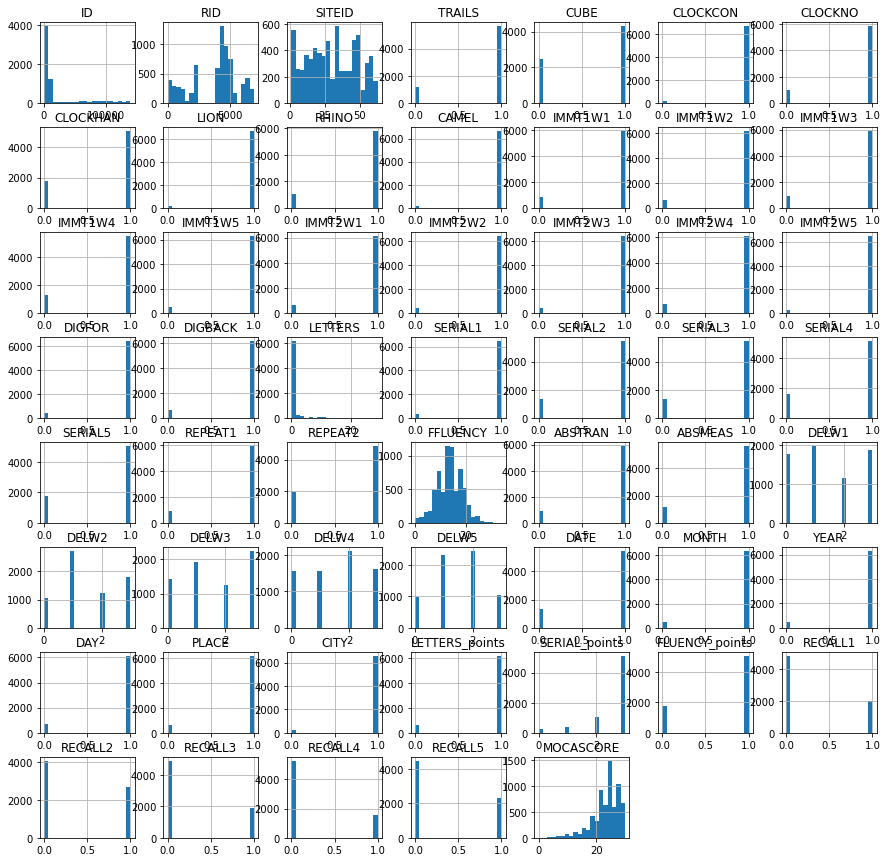

In [488]:
moca.hist(figsize=(15,15),bins=20)
a=1

In [489]:
# How many entries did we lose due to cleaning?
moca_finish_entries = moca.shape[0]
dropped_entries = moca_start_entries - moca_finish_entries
print(dropped_entries)
print(np.round(dropped_entries/moca_start_entries*100, 2), '% removed')

242
3.44 % removed


In [490]:
# Writing df to csv.
df = moca
df.to_csv('../../data/tabular_data/clean_MOCA.csv', index=False)

### Neuropsychological Battery Tests (NEUROBAT)

The Neuropsychological Battery comprises of several tests:

1. **Logical Memory** (Immediate and delayed recall)
2. **Rey Auditory Verbal Learning Test**
3. **Clock Drawing and Copying**
4. **Fluency**
5. **Trail Making Test**
6. **Boston Naming Test / Multilingual Naming Test**
8. **ANART (American National Adult Reading Test)**
9. **Digit Span**

Only a subset of these tests was administered at any given visit.     

The Digit Span was dropped after ADNI1, we will drop it in our analysis as well.

The Category Fluency - Animals was retained, but Vegetables were dropped after ADNI1.

A Spanish language option for the Boston Naming Test became available later in ADNI2/GO. 

<u>Sources:<u>
- https://adni.bitbucket.io/reference/neurobat.html

In [491]:
pd.set_option('display.max_columns', 82)
nb_dict = pd.read_csv('../../data/tabular_data/NEUROBAT_dict.csv', header=None)
nb_dict

,0,1
0,Phase,Phase
1,ID,Record ID
2,RID,Participant roster ID
3,SITEID,Site ID
4,VISCODE,Visit code
5,VISCODE2,Translated visit code
6,USERDATE,Date record created
7,USERDATE2,Date record last updated
8,EXAMDATE,Examination Date
9,CLOCKCIRC,1. Approximately circular face; 1=Yes;0=No


In [492]:
nb = pd.read_csv('../../data/tabular_data/NEUROBAT.csv')

# Change hidden missing values.
nb = nb.replace(-1, np.NaN)    
nb = nb.replace(-4, np.NaN)
nb = nb.replace('-1', np.NaN)    
nb = nb.replace('-4', np.NaN)
nb = nb.replace('-', np.NaN)    

C:\Users\kfatur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [493]:
nb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14710 entries, 0 to 14709
Data columns (total 81 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Phase                  14710 non-null  object 
 1   ID                     14710 non-null  int64  
 2   RID                    14710 non-null  int64  
 3   SITEID                 14710 non-null  int64  
 4   VISCODE                14710 non-null  object 
 5   VISCODE2               14694 non-null  object 
 6   USERDATE               14710 non-null  object 
 7   USERDATE2              8452 non-null   object 
 8   EXAMDATE               5102 non-null   object 
 9   CLOCKCIRC              10783 non-null  float64
 10  CLOCKSYM               10783 non-null  float64
 11  CLOCKNUM               10783 non-null  float64
 12  CLOCKHAND              10783 non-null  float64
 13  CLOCKTIME              10785 non-null  float64
 14  CLOCKSCOR              10784 non-null  float64
 15  CO

In [494]:
nb.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LMSTORY,LIMMTOTAL,LIMMEND,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,AVENDED,DSPANFOR,DSPANFLTH,DSPANBAC,DSPANBLTH,CATANIMSC,CATANPERS,CATANINTR,CATVEGESC,CATVGPERS,CATVGINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,DIGITSCOR,LDELBEGIN,LDELTOTAL,LDELCUE,BNTND,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDELBEGAN,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTND,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,update_stamp
0,ADNI1,12,2,107,sc,sc,2005-08-17,NaN,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
1,ADNI1,14,3,107,sc,sc,2005-08-18,NaN,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
2,ADNI1,16,4,10,sc,sc,2005-08-18,NaN,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
3,ADNI1,18,5,107,sc,sc,2005-08-23,NaN,2005-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
4,ADNI1,20,7,10,sc,sc,2005-08-25,NaN,2005-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0


In [495]:
nb.isnull().sum()

Phase                        0
ID                           0
RID                          0
SITEID                       0
VISCODE                      0
VISCODE2                    16
USERDATE                     0
USERDATE2                 6258
EXAMDATE                  9608
CLOCKCIRC                 3927
CLOCKSYM                  3927
CLOCKNUM                  3927
CLOCKHAND                 3927
CLOCKTIME                 3925
CLOCKSCOR                 3926
COPYCIRC                  3921
COPYSYM                   3921
COPYNUM                   3921
COPYHAND                  3921
COPYTIME                  3922
COPYSCOR                  3919
LMSTORY                   8121
LIMMTOTAL                 4367
LIMMEND                   8131
AVTOT1                    3928
AVERR1                    3937
AVTOT2                    3934
AVERR2                    3941
AVTOT3                    3951
AVERR3                    3960
AVTOT4                    3963
AVERR4                    3973
AVTOT5  

<AxesSubplot:>

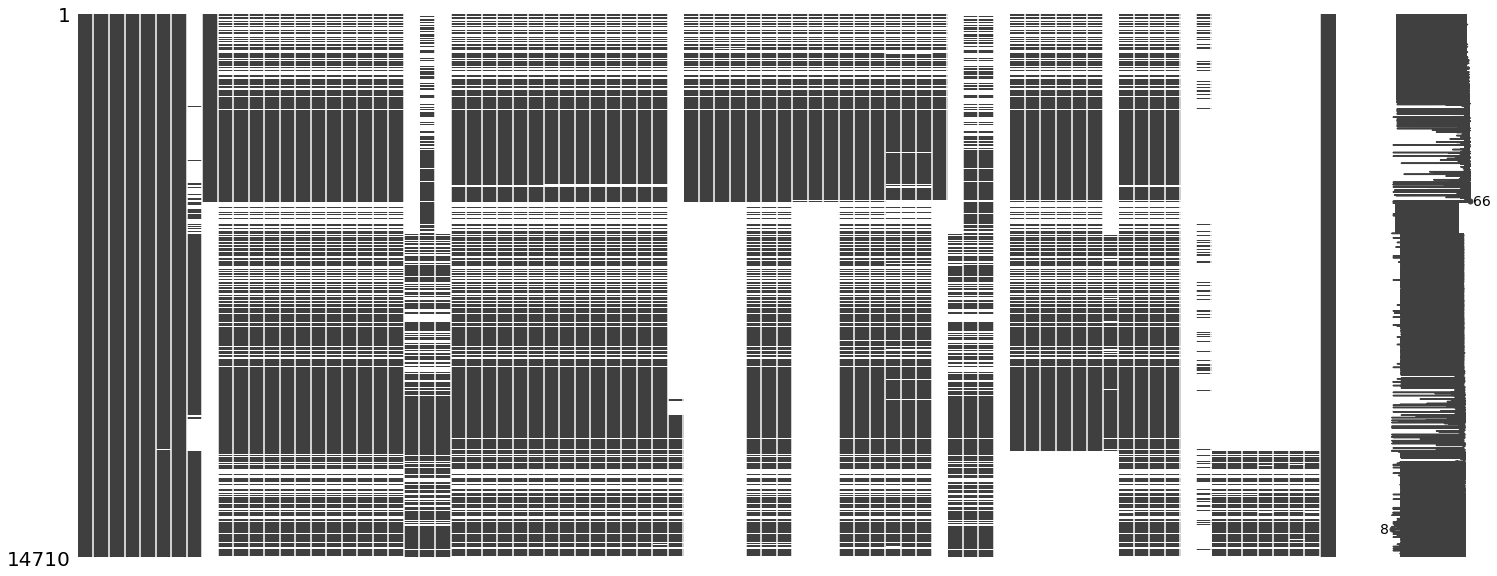

In [496]:
msno.matrix(nb)

In [497]:
nb_start_entries = nb.shape[0]

In [498]:
# Drop those who failed screening.
nb = nb[nb.VISCODE != 'f']

In [499]:
# Adult reading test.
# How many rows, where 'ANARTERR' is not null?
nb[~nb['ANARTERR'].isnull()].sort_values(by = ['Phase', 'RID', 'VISCODE'])

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LMSTORY,LIMMTOTAL,LIMMEND,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,AVENDED,DSPANFOR,DSPANFLTH,DSPANBAC,DSPANBLTH,CATANIMSC,CATANPERS,CATANINTR,CATVEGESC,CATVGPERS,CATVGINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,DIGITSCOR,LDELBEGIN,LDELTOTAL,LDELCUE,BNTND,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDELBEGAN,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTND,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,update_stamp
9,ADNI1,30,2,107,bl,bl,2005-09-09,NaN,2005-09-08,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,NaN,NaN,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,NaN,10.0,8.0,8.0,5.0,15.0,2.0,0.0,8.0,0.0,0.0,29.0,0.0,0.0,112.0,1.0,0.0,34.0,NaN,NaN,NaN,NaN,29.0,0.0,0.0,0.0,0.0,29.0,NaN,5.0,4.0,6.0,0.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
12,ADNI1,36,3,107,bl,bl,2005-09-13,NaN,2005-09-12,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,NaN,NaN,NaN,3.0,0.0,6.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,3.0,1.0,1.0,2.0,NaN,10.0,7.0,5.0,4.0,10.0,0.0,0.0,5.0,1.0,1.0,57.0,0.0,0.0,148.0,1.0,0.0,25.0,NaN,NaN,NaN,NaN,17.0,0.0,0.0,13.0,5.0,17.0,NaN,0.0,0.0,1.0,0.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
10,ADNI1,32,5,107,bl,bl,2005-09-09,NaN,2005-09-07,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,NaN,NaN,5.0,1.0,6.0,1.0,9.0,0.0,8.0,0.0,9.0,0.0,4.0,0.0,4.0,1.0,NaN,10.0,8.0,8.0,6.0,19.0,1.0,0.0,11.0,0.0,0.0,50.0,0.0,0.0,90.0,1.0,0.0,38.0,NaN,NaN,NaN,NaN,27.0,0.0,0.0,3.0,30.0,27.0,NaN,5.0,5.0,15.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
85,ADNI1,182,6,4,bl,bl,2005-11-30,NaN,2005-11-29,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,4.0,NaN,NaN,NaN,5.0,0.0,6.0,0.0,6.0,0.0,7.0,1.0,6.0,0.0,4.0,4.0,4.0,0.0,NaN,9.0,7.0,6.0,4.0,13.0,4.0,0.0,9.0,3.0,0.0,49.0,0.0,0.0,168.0,1.0,0.0,34.0,NaN,NaN,NaN,NaN,24.0,6.0,1.0,5.0,5.0,25.0,NaN,1.0,0.0,7.0,1.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
20,ADNI1,52,8,107,bl,bl,2005-09-26,NaN,2005-09-19,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,NaN,NaN,5.0,1.0,10.0,2.0,12.0,0.0,12.0,0.0,12.0,0.0,10.0,0.0,5.0,0.0,NaN,7.0,6.0,4.0,3.0,22.0,1.0,0.0,16.0,0.0,0.0,31.0,0.0,0.0,51.0,0.0,0.0,49.0,NaN,NaN,NaN,NaN,27.0,0.0,0.0,3.0,30.0,27.0,NaN,9.0,1.0,13.0,0.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-26 16:22:44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5887,ADNIGO,1600,2396,30,bl,bl,2011-08-30,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,8.0,0.0,8.0,0.0,4.0,3.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,14.0,1.0,0.0,NaN,NaN,NaN,25.0,0.0,0.0,92.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,25.0,0.0,0.0,5.0,3.0,25.0,NaN,2.0,3.0,10.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-16 09:42:20.0
5870,ADNIGO,1566,2398,31,bl,bl,2011-07-27,2012-03-26,NaN,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,NaN,NaN,4.0,1.0,5.0,0.0,9.0,1.0,10.0,0.0,11.0,0.0,8.0,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,15.0,0.0,0.0,NaN,NaN,NaN,34.0,0.0,0.0,300.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,29.0,1.0,0.0,1.0,1.0,29.0,NaN,3.0,1.0,14.0,1.0,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-16 09:42:20.0
5927,ADNIGO,1680,2403,50,bl,bl,2011-11-22,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,NaN,NaN,3.0,2.0,5.0,2.0,5.0,1.0,6.0,3.0,8.0,1.0,4.0,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,26.0,0.0,0.0,NaN,NaN,NaN,41.0,0.0,0.0,92.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,29.0,0.0,0.0,1.0,1.0,29.0,NaN,0.0,3.0,9.0,6.0,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-16 09:42:20.0

Columns ANARTND and ANARTERR cointain information on the adult reading test.    
ANARTND ("not done") should be filled in, if the test has not been done, but given a lot of missing values in the score column ANARTERR, it seems that this test was mostly just skipped over and it was not even noted that it has not been done.

The reading test was performed on baseline visit. Was it thus completed just once per participant?

In [500]:
# Did somebody do it twice?
nb[~nb['ANARTERR'].isnull()].duplicated().any()

False

In [501]:
# How many unique participants in the table?
nb['RID'].nunique()

3385

In [502]:
2281/3793

0.6013709464803586

For roughly 30% participants we don't have the reading test results. Those, who did completed the test, performed it only once.

We were considering imputation, but it could bring questionable results, since these tests record a participant's performance and working with imputed data would introduce a bias when building ML models.   

We suspect, that in line with the protocol, only a subset of tests was administered at a given visit. For tests, which were not performed, we have empty values at that visit's columns and we would introduce values for tests which did not actually happen.     

We will consider grouping the results by exam when they were performed.

In [503]:
# Column on whether the reading test was done or not - drop it.
nb = nb.drop(columns = ['ANARTND'])

In [504]:
# nb.columns

In [505]:
# Retain relevant columns.
nb = nb.drop(columns = ['USERDATE', 'USERDATE2', 'LMSTORY', 'LIMMEND', 'AVENDED',
                        'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH', 'DIGITSCOR', 
                        'CATVEGESC', 'CATVGPERS', 'CATVGINTR', 'LDELBEGIN', 'BNTND',
                        'BNTND', 'AVDELBEGAN', 'update_stamp'])

In [506]:
# # Check VISCODE2 column, make sure, the visit timing codes are ordered.
# # Dataframe vis_dict above defines the order of values for phase and visit.
# vis_dict

In [507]:
# Order VISCODE, Phases
nb['Phase'] = nb['Phase'].astype('category')
nb['VISCODE'] = nb['VISCODE'].astype('category')

nb['Phase'] = nb['Phase'].cat.set_categories(['ADNI1', 'ADNIGO', 'ADNI2', 'ADNI3'], ordered=True)
nb['VISCODE'] = nb['VISCODE'].cat.set_categories(['sc', 'bl', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48',
                                                  'm54', 'uns1', 'f', 'nv', 'scmri', 'm03', 'm60', 'm66', 'm72', 'm78', 'v01', 'v02',
                                                  'v03', 'v04', 'v05', 'v06', 'v07', 'v11', 'v12', 'v21', 'v22', 'v31',
                                                  'v32', 'v41', 'v42', 'v51', 'v52', 'tau', 'reg', 'init', 'y1', 'y2', 
                                                  'y3', 'y4', 'y5', 'y6'], ordered=True)

In [508]:
# Drop participants who failed screening.
index_names = nb[nb['VISCODE'] == 'f' ].index
  
# drop these row indexes
nb.drop(index_names, inplace = True)

In [509]:
nb[nb['VISCODE2'].isna()]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
11679,ADNI2,11470,5127,19,tau,NaN,NaN,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,26.0,2.0,0.0,22.0,0.0,0.0,69.0,0.0,0.0,15.0,0.0,25.0,0.0,0.0,5.0,4.0,25.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11680,ADNI2,11472,5083,19,tau,NaN,NaN,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,1.0,0.0,37.0,0.0,0.0,79.0,0.0,0.0,17.0,0.0,26.0,0.0,0.0,4.0,3.0,26.0,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11782,ADNI2,11678,4552,35,tau,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,0.0,0.0,24.0,0.0,0.0,48.0,0.0,0.0,15.0,0.0,28.0,0.0,0.0,2.0,1.0,28.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11792,ADNI2,11698,4198,47,tau,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,2.0,0.0,43.0,1.0,0.0,63.0,0.0,0.0,13.0,0.0,30.0,0.0,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11803,ADNI2,11720,5200,47,tau,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,0.0,0.0,34.0,0.0,0.0,71.0,0.0,0.0,16.0,0.0,30.0,0.0,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11843,ADNI2,11800,4028,26,tau,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,1.0,0.0,18.0,0.0,0.0,61.0,2.0,0.0,17.0,0.0,30.0,0.0,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11844,ADNI2,11802,5126,26,tau,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0,0.0,18.0,0.0,0.0,43.0,0.0,0.0,15.0,0.0,29.0,0.0,0.0,1.0,1.0,29.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13569,ADNI3,84692,6082,49,y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13880,ADNI3,97597,2068,18,y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13941,ADNI3,100319,5273,52,y2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [510]:
# 'tau'
nb.at[11679,'VISCODE2'] = 'VISCODE'
nb.at[11680,'VISCODE2'] = 'VISCODE'
nb.at[11782,'VISCODE2'] = 'VISCODE'
nb.at[11792,'VISCODE2'] = 'VISCODE'
nb.at[11803,'VISCODE2'] = 'VISCODE'
nb.at[11843,'VISCODE2'] = 'VISCODE'
nb.at[11844,'VISCODE2'] = 'VISCODE'

In [511]:
# # Fill all the NaN EXAMDATE for multindex ['Phase', 'RID', 'VISCODE'] with the respective EXAMDATE in reg df.
nb = nb.set_index(['Phase', 'RID', 'VISCODE'])
nb['EXAMDATE'] = nb['EXAMDATE'].fillna(reg.set_index(['Phase', 'RID', 'VISCODE'])['EXAMDATE'])
nb.reset_index(inplace=True)
nb[nb['EXAMDATE'].isna()]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
5494,ADNIGO,830,m60,1630,21,m60,NaN,1.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,1.0,1.0,4.0,8.0,4.0,0.0,7.0,0.0,8.0,0.0,7.0,0.0,6.0,0.0,3.0,0.0,4.0,0.0,16.0,2.0,0.0,40.0,0.0,0.0,219.0,5.0,6.0,8.0,0.0,17.0,6.0,2.0,11.0,4.0,19.0,2.0,0.0,11.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10859,ADNI2,5256,v11,10630,1,m12,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,7.0,0.0,10.0,0.0,12.0,0.0,15.0,0.0,15.0,0.0,12.0,0.0,6.0,0.0,17.0,0.0,0.0,31.0,1.0,0.0,110.0,2.0,0.0,15.0,0.0,26.0,0.0,0.0,4.0,4.0,26.0,11.0,0.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11204,ADNI2,4555,v31,11330,2,m36,NaN,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,3.0,1.0,6.0,1.0,9.0,0.0,10.0,0.0,11.0,1.0,10.0,2.0,5.0,0.0,15.0,0.0,0.0,18.0,0.0,0.0,77.0,1.0,0.0,14.0,0.0,22.0,8.0,1.0,7.0,0.0,23.0,9.0,3.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11625,ADNI3,907,init,4530,2,m132,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,12.0,6.0,0.0,8.0,0.0,11.0,0.0,12.0,0.0,14.0,0.0,9.0,0.0,3.0,0.0,12.0,0.0,0.0,44.0,0.0,0.0,139.0,2.0,0.0,11.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,15.0,0.0,NaN,0.0,23.0,23.0,4.0,51.0,8.0,28.571428
13161,ADNI3,6082,y1,84692,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13472,ADNI3,2068,y1,97597,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13533,ADNI3,5273,y2,100319,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14076,ADNI3,6892,bl,127765,12,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,3.0,0.0,8.0,0.0,10.0,0.0,10.0,0.0,10.0,0.0,9.0,0.0,3.0,1.0,18.0,0.0,0.0,34.0,0.0,0.0,78.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,15.0,0.0,NaN,0.0,25.0,25.0,4.0,41.0,7.0,40.000000
14087,ADNI3,6909,sc,128235,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14098,ADNI3,6688,y2,128827,50,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,12.0,6.0,0.0,8.0,0.0,8.0,0.0,7.0,0.0,8.0,0.0,5.0,0.0,5.0,1.0,22.0,1.0,0.0,33.0,0.0,0.0,86.0,0.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,32.0,6.0,37.0,2.0,75.000000


There are rows (see the rows for RIDs 6082, 2068 and 5273 above), which contain no test results. We will delete such rows.

In [512]:
# Drop rows with no test values.
test_columns = nb.iloc[:, 7:].columns
test_columns

nb = nb.dropna(subset = test_columns, how='all', axis = 0)

In [513]:
nb.shape

(14226, 63)

In [514]:
# Infer missing EXAMDATE and VISCODE2, where these are not present in the Registry df.
# For example, exams with visit code 'm24' and missing date will get date based on the previous exam ('m12') plus 12 months:
# e.g. 'm12': 2010-09-23 >> m24: 2011-09-23
nb[nb['RID'] == 830]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
916,ADNI1,830,sc,2354,15,sc,2006-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,ADNI1,830,bl,2724,15,bl,2006-09-21,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,0.0,7.0,0.0,2.0,0.0,4.0,0.0,17.0,0.0,0.0,29.0,0.0,0.0,75.0,0.0,1.0,NaN,NaN,23.0,1.0,1.0,6.0,4.0,24.0,3.0,0.0,13.0,6.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2121,ADNI1,830,m06,5050,15,m06,2007-04-03,1.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,3.0,2.0,4.0,2.0,4.0,0.0,6.0,1.0,7.0,1.0,2.0,3.0,1.0,2.0,16.0,0.0,0.0,50.0,0.0,0.0,87.0,1.0,0.0,NaN,NaN,21.0,2.0,1.0,8.0,3.0,22.0,0.0,1.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2765,ADNI1,830,m12,6344,15,m12,2007-09-17,1.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,1.0,1.0,4.0,12.0,6.0,0.0,6.0,1.0,9.0,0.0,7.0,2.0,8.0,2.0,3.0,4.0,5.0,2.0,22.0,0.0,0.0,50.0,0.0,0.0,99.0,0.0,0.0,12.0,0.0,22.0,7.0,1.0,7.0,4.0,23.0,2.0,4.0,13.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3335,ADNI1,830,m18,7486,15,m18,2008-03-24,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,4.0,1.0,7.0,0.0,8.0,0.0,9.0,0.0,7.0,0.0,3.0,2.0,3.0,0.0,15.0,0.0,0.0,50.0,0.0,0.0,122.0,1.0,0.0,NaN,NaN,23.0,4.0,0.0,7.0,6.0,23.0,1.0,2.0,15.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3792,ADNI1,830,m24,8400,15,m24,2008-09-25,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0,10.0,6.0,1.0,6.0,2.0,6.0,1.0,6.0,0.0,7.0,1.0,4.0,0.0,5.0,1.0,21.0,0.0,0.0,31.0,0.0,0.0,96.0,1.0,0.0,11.0,0.0,22.0,2.0,1.0,7.0,5.0,23.0,3.0,0.0,14.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4077,ADNI1,830,m36,9554,15,m36,2009-09-21,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,7.0,5.0,0.0,5.0,0.0,6.0,1.0,8.0,0.0,7.0,0.0,1.0,1.0,5.0,0.0,20.0,0.0,0.0,41.0,1.0,0.0,115.0,0.0,0.0,6.0,1.0,23.0,4.0,0.0,7.0,5.0,23.0,1.0,0.0,14.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4904,ADNIGO,830,m48,446,21,m48,2010-09-23,1.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,1.0,1.0,4.0,13.0,4.0,2.0,6.0,0.0,4.0,2.0,5.0,1.0,7.0,3.0,2.0,0.0,3.0,1.0,14.0,2.0,0.0,41.0,0.0,0.0,179.0,5.0,0.0,10.0,1.0,19.0,3.0,1.0,10.0,5.0,20.0,0.0,0.0,12.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5494,ADNIGO,830,m60,1630,21,m60,NaN,1.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,1.0,1.0,4.0,8.0,4.0,0.0,7.0,0.0,8.0,0.0,7.0,0.0,6.0,0.0,3.0,0.0,4.0,0.0,16.0,2.0,0.0,40.0,0.0,0.0,219.0,5.0,6.0,8.0,0.0,17.0,6.0,2.0,11.0,4.0,19.0,2.0,0.0,11.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5993,ADNI2,830,v06,882,21,m60,2011-09-22,1.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,1.0,1.0,4.0,8.0,4.0,0.0,7.0,0.0,8.0,0.0,7.0,0.0,6.0,0.0,3.0,0.0,4.0,0.0,16.0,2.0,0.0,40.0,1.0,0.0,219.0,5.0,5.0,8.0,0.0,17.0,6.0,2.0,11.0,4.0,19.0,2.0,0.0,11.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [515]:
nb.loc[(nb.ID == 1630) & (nb.Phase == 'ADNIGO'), 'EXAMDATE'] = '2011-09-23'

In [516]:
nb[nb['RID'] == 5256]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
9135,ADNI2,5256,v01,7174,1,sc,2013-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9241,ADNI2,5256,v03,7386,1,bl,2013-07-30,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,7.0,0.0,11.0,0.0,14.0,0.0,15.0,0.0,15.0,0.0,13.0,0.0,5.0,0.0,18.0,1.0,0.0,41.0,2.0,0.0,72.0,0.0,0.0,NaN,NaN,28.0,2.0,0.0,2.0,2.0,28.0,14.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9908,ADNI2,5256,v05,8724,1,m06,2014-02-06,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,6.0,1.0,10.0,7.0,10.0,1.0,13.0,1.0,15.0,0.0,12.0,1.0,5.0,3.0,17.0,2.0,0.0,32.0,2.0,0.0,80.0,0.0,0.0,NaN,NaN,29.0,1.0,0.0,0.0,0.0,29.0,14.0,3.0,14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10859,ADNI2,5256,v11,10630,1,m12,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,7.0,0.0,10.0,0.0,12.0,0.0,15.0,0.0,15.0,0.0,12.0,0.0,6.0,0.0,17.0,0.0,0.0,31.0,1.0,0.0,110.0,2.0,0.0,15.0,0.0,26.0,0.0,0.0,4.0,4.0,26.0,11.0,0.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10921,ADNI2,5256,v21,10754,1,m24,2015-09-08,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,7.0,0.0,10.0,0.0,12.0,0.0,15.0,0.0,15.0,0.0,12.0,0.0,6.0,0.0,17.0,0.0,0.0,31.0,1.0,0.0,110.0,2.0,0.0,15.0,0.0,26.0,0.0,0.0,4.0,4.0,26.0,11.0,0.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [517]:
nb.loc[(nb.ID == 10630) & (nb.Phase == 'ADNI2'), 'EXAMDATE'] = '2014-08-06'

In [518]:
nb[nb['EXAMDATE'].isna()]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
11204,ADNI2,4555,v31,11330,2,m36,NaN,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,3.0,1.0,6.0,1.0,9.0,0.0,10.0,0.0,11.0,1.0,10.0,2.0,5.0,0.0,15.0,0.0,0.0,18.0,0.0,0.0,77.0,1.0,0.0,14.0,0.0,22.0,8.0,1.0,7.0,0.0,23.0,9.0,3.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11625,ADNI3,907,init,4530,2,m132,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,12.0,6.0,0.0,8.0,0.0,11.0,0.0,12.0,0.0,14.0,0.0,9.0,0.0,3.0,0.0,12.0,0.0,0.0,44.0,0.0,0.0,139.0,2.0,0.0,11.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,15.0,0.0,NaN,0.0,23.0,23.0,4.0,51.0,8.0,28.571428
14076,ADNI3,6892,bl,127765,12,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,3.0,0.0,8.0,0.0,10.0,0.0,10.0,0.0,10.0,0.0,9.0,0.0,3.0,1.0,18.0,0.0,0.0,34.0,0.0,0.0,78.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,15.0,0.0,NaN,0.0,25.0,25.0,4.0,41.0,7.0,40.000000
14087,ADNI3,6909,sc,128235,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14098,ADNI3,6688,y2,128827,50,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,12.0,6.0,0.0,8.0,0.0,8.0,0.0,7.0,0.0,8.0,0.0,5.0,0.0,5.0,1.0,22.0,1.0,0.0,33.0,0.0,0.0,86.0,0.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,32.0,6.0,37.0,2.0,75.000000
14198,ADNI3,6949,sc,133454,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [519]:
nb[nb['RID'] == 4555]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
6679,ADNI2,4555,v01,2258,2,sc,2012-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6897,ADNI2,4555,v03,2694,2,bl,2012-03-23,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,5.0,1.0,6.0,1.0,8.0,2.0,7.0,0.0,10.0,1.0,9.0,0.0,5.0,0.0,15.0,0.0,0.0,24.0,0.0,0.0,75.0,1.0,0.0,NaN,NaN,20.0,0.0,0.0,10.0,6.0,20.0,10.0,2.0,14.0,1.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8121,ADNI2,4555,v05,5142,2,m06,2012-11-07,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,6.0,0.0,9.0,0.0,8.0,0.0,13.0,0.0,12.0,0.0,9.0,3.0,7.0,0.0,19.0,1.0,0.0,27.0,0.0,0.0,101.0,4.0,0.0,NaN,NaN,20.0,0.0,0.0,10.0,3.0,20.0,7.0,4.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8927,ADNI2,4555,v11,6756,2,m12,2013-05-14,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,15.0,6.0,1.0,7.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,12.0,0.0,4.0,1.0,19.0,1.0,0.0,29.0,0.0,0.0,72.0,4.0,0.0,10.0,0.0,24.0,0.0,0.0,6.0,2.0,24.0,10.0,2.0,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10051,ADNI2,4555,v21,9010,2,m24,2014-03-20,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,16.0,6.0,0.0,7.0,1.0,11.0,0.0,11.0,0.0,11.0,0.0,10.0,0.0,4.0,0.0,23.0,0.0,0.0,20.0,0.0,0.0,50.0,0.0,0.0,13.0,0.0,22.0,5.0,0.0,8.0,7.0,22.0,10.0,2.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11204,ADNI2,4555,v31,11330,2,m36,NaN,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,3.0,1.0,6.0,1.0,9.0,0.0,10.0,0.0,11.0,1.0,10.0,2.0,5.0,0.0,15.0,0.0,0.0,18.0,0.0,0.0,77.0,1.0,0.0,14.0,0.0,22.0,8.0,1.0,7.0,0.0,23.0,9.0,3.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11410,ADNI2,4555,v41,11750,2,m48,2016-04-22,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,3.0,1.0,6.0,1.0,9.0,0.0,10.0,0.0,11.0,1.0,10.0,2.0,5.0,0.0,15.0,0.0,0.0,18.0,0.0,0.0,77.0,1.0,0.0,14.0,0.0,22.0,8.0,1.0,7.0,0.0,23.0,9.0,3.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [520]:
nb.loc[(nb.ID == 11330) & (nb.Phase == 'ADNI2'), 'EXAMDATE'] = '2015-03-20'

In [521]:
nb[nb['RID'] == 907]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
1065,ADNI1,907,sc,2710,102,sc,2006-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1253,ADNI1,907,bl,3136,102,bl,2006-10-16,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,4.0,0.0,8.0,0.0,13.0,0.0,11.0,0.0,15.0,0.0,12.0,0.0,3.0,0.0,23.0,0.0,0.0,22.0,0.0,0.0,52.0,0.0,0.0,NaN,NaN,28.0,2.0,0.0,2.0,0.0,28.0,11.0,2.0,14.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2240,ADNI1,907,m06,5292,102,m06,2007-04-23,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,5.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,12.0,0.0,9.0,0.0,4.0,0.0,20.0,0.0,0.0,19.0,0.0,0.0,63.0,1.0,0.0,NaN,NaN,26.0,0.0,0.0,4.0,4.0,26.0,9.0,0.0,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2930,ADNI1,907,m12,6674,102,m12,2007-10-30,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,6.0,0.0,11.0,0.0,14.0,0.0,15.0,0.0,15.0,0.0,10.0,1.0,5.0,0.0,18.0,0.0,0.0,33.0,0.0,0.0,58.0,0.0,0.0,15.0,0.0,26.0,0.0,0.0,4.0,2.0,26.0,9.0,0.0,12.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3874,ADNI1,907,m24,8564,102,m24,2008-10-30,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,17.0,4.0,0.0,8.0,0.0,10.0,0.0,13.0,0.0,13.0,0.0,11.0,0.0,4.0,0.0,21.0,0.0,0.0,27.0,0.0,0.0,62.0,0.0,0.0,16.0,0.0,24.0,1.0,1.0,5.0,2.0,25.0,11.0,0.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4405,ADNI1,907,m36,9628,102,m36,2009-10-27,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,16.0,5.0,1.0,10.0,0.0,9.0,0.0,11.0,0.0,11.0,0.0,10.0,0.0,3.0,0.0,17.0,2.0,0.0,22.0,0.0,0.0,57.0,0.0,0.0,16.0,0.0,26.0,0.0,0.0,4.0,2.0,26.0,8.0,4.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5086,ADNIGO,907,m48,814,2,m48,2010-12-13,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,5.0,0.0,7.0,0.0,9.0,0.0,14.0,0.0,12.0,0.0,12.0,0.0,5.0,0.0,17.0,0.0,0.0,37.0,0.0,0.0,76.0,2.0,0.0,11.0,0.0,23.0,1.0,1.0,6.0,4.0,24.0,12.0,0.0,14.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6544,ADNI2,907,v06,1986,2,m60,2012-01-23,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,15.0,8.0,0.0,11.0,0.0,12.0,0.0,14.0,0.0,13.0,0.0,14.0,0.0,5.0,0.0,21.0,2.0,0.0,35.0,0.0,0.0,58.0,0.0,0.0,17.0,0.0,27.0,0.0,0.0,3.0,2.0,27.0,15.0,0.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8735,ADNI2,907,v11,6372,2,m72,2013-03-27,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,18.0,4.0,7.0,7.0,2.0,12.0,0.0,13.0,0.0,13.0,0.0,12.0,0.0,7.0,1.0,17.0,0.0,0.0,24.0,0.0,0.0,43.0,0.0,0.0,17.0,0.0,23.0,0.0,0.0,7.0,5.0,23.0,10.0,1.0,12.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11072,ADNI2,907,v41,11064,2,m108,2016-01-29,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,16.0,4.0,0.0,9.0,0.0,13.0,0.0,11.0,0.0,12.0,0.0,12.0,0.0,2.0,0.0,14.0,2.0,1.0,29.0,0.0,0.0,92.0,0.0,0.0,15.0,0.0,22.0,8.0,1.0,7.0,5.0,23.0,9.0,0.0,14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [522]:
nb.loc[(nb.ID == 4530) & (nb.Phase == 'ADNI3'), 'EXAMDATE'] = '2018-01-29'

In [523]:
nb[nb['RID'] == 6892]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
13970,ADNI3,6892,sc,121839,12,sc,2020-10-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14076,ADNI3,6892,bl,127765,12,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,3.0,0.0,8.0,0.0,10.0,0.0,10.0,0.0,10.0,0.0,9.0,0.0,3.0,1.0,18.0,0.0,0.0,34.0,0.0,0.0,78.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,15.0,0.0,NaN,0.0,25.0,25.0,4.0,41.0,7.0,40.0


In [524]:
# The test tasks were distributed between two visits, with only logical memory taking place during screening. 
# Would it make sense to eventually create full test entries per person, regardless if the tests were completed within 6 months or a year?
# Baseline happens within a month (or 6 months) afdter screening, so we could subsume the results in one record to obtain a complete test.
nb.loc[(nb.ID == 127765) & (nb.Phase == 'ADNI3'), 'EXAMDATE'] = '2020-10-23'

In [525]:
nb[nb['RID'] == 6909]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
14087,ADNI3,6909,sc,128235,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [526]:
nb[nb['RID'] == 6949]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
14198,ADNI3,6949,sc,133454,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [527]:
nb[nb['RID'] == 6688]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
12970,ADNI3,6688,sc,75676,50,sc,2019-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13000,ADNI3,6688,bl,77456,50,bl,2019-03-07,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,6.0,0.0,8.0,0.0,8.0,0.0,7.0,0.0,8.0,0.0,1.0,1.0,4.0,1.0,20.0,1.0,0.0,38.0,0.0,0.0,118.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,7.0,1.0,8.0,0.0,31.0,31.0,6.0,37.0,2.0,75.000000
13782,ADNI3,6688,y1,110951,50,m12,2020-03-05,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,10.0,5.0,0.0,7.0,0.0,7.0,0.0,8.0,0.0,6.0,1.0,6.0,0.0,3.0,2.0,18.0,0.0,0.0,35.0,0.0,0.0,88.0,0.0,0.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,13.0,1.0,NaN,0.0,32.0,32.0,4.0,33.0,1.0,66.666664
14098,ADNI3,6688,y2,128827,50,NaN,NaN,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,12.0,6.0,0.0,8.0,0.0,8.0,0.0,7.0,0.0,8.0,0.0,5.0,0.0,5.0,1.0,22.0,1.0,0.0,33.0,0.0,0.0,86.0,0.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,32.0,6.0,37.0,2.0,75.000000


In [528]:
nb.loc[(nb.ID == 128827) & (nb.Phase == 'ADNI3'), 'VISCODE2'] = 'm24'
nb.loc[(nb.ID == 128827) & (nb.Phase == 'ADNI3'), 'EXAMDATE'] = '2021-03-05'

Baseline and screening exams together make up for one entire test - some tasks are performed during screening, other tasks during the baseline exam. The pattern repeats itself, it might pay off to join these two exams into one entry? (The testing occurs within a month, anyhow.) We'll address this after we finish with VISCODEs.

In [529]:
nb['EXAMDATE'] = pd.to_datetime(nb['EXAMDATE']).dt.date

In [530]:
# drop rows with missing date, because we cannot infer visit code, and we've seen above, that a lot of row values are missing.
nb = nb.dropna(subset = ['EXAMDATE'], axis = 0)

In [531]:
nb[nb['VISCODE2'].isna()]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
14076,ADNI3,6892,bl,127765,12,NaN,2020-10-23,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,3.0,0.0,8.0,0.0,10.0,0.0,10.0,0.0,10.0,0.0,9.0,0.0,3.0,1.0,18.0,0.0,0.0,34.0,0.0,0.0,78.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,15.0,0.0,NaN,0.0,25.0,25.0,4.0,41.0,7.0,40.000000
14125,ADNI3,6839,y1,129941,12,NaN,2021-03-25,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,3.0,0.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,11.0,1.0,0.0,33.0,1.0,0.0,300.0,2.0,6.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,13.0,7.0,NaN,0.0,27.0,27.0,3.0,16.0,3.0,100.000000
14182,ADNI3,6931,bl,132828,12,NaN,2021-05-12,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,5.0,0.0,8.0,0.0,9.0,0.0,10.0,0.0,12.0,0.0,7.0,1.0,6.0,0.0,26.0,1.0,0.0,18.0,1.0,0.0,49.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,7.0,1.0,9.0,0.0,26.0,26.0,10.0,44.0,7.0,83.333336


In [532]:
nb[nb['RID'] == 6892]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
13970,ADNI3,6892,sc,121839,12,sc,2020-10-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14076,ADNI3,6892,bl,127765,12,NaN,2020-10-23,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,3.0,0.0,8.0,0.0,10.0,0.0,10.0,0.0,10.0,0.0,9.0,0.0,3.0,1.0,18.0,0.0,0.0,34.0,0.0,0.0,78.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,15.0,0.0,NaN,0.0,25.0,25.0,4.0,41.0,7.0,40.0


In [533]:
nb.loc[(nb.ID == 127765) & (nb.Phase == 'ADNI3'), 'VISCODE2'] = 'bl'

In [534]:
nb[nb['RID'] == 6839]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
13621,ADNI3,6839,sc,103930,12,sc,2019-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13679,ADNI3,6839,bl,106693,12,bl,2020-01-13,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,3.0,0.0,4.0,0.0,3.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,0.0,30.0,0.0,0.0,278.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,9.0,7.0,13.0,0.0,30.0,30.0,5.0,18.0,2.0,100.0
14125,ADNI3,6839,y1,129941,12,NaN,2021-03-25,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,3.0,0.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,11.0,1.0,0.0,33.0,1.0,0.0,300.0,2.0,6.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,13.0,7.0,NaN,0.0,27.0,27.0,3.0,16.0,3.0,100.0


In [535]:
nb.loc[(nb.ID == 129941) & (nb.Phase == 'ADNI3'), 'VISCODE2'] = 'm12'

In [536]:
nb[nb['RID'] == 6931]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
14147,ADNI3,6931,sc,131055,12,sc,2021-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14182,ADNI3,6931,bl,132828,12,NaN,2021-05-12,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,5.0,0.0,8.0,0.0,9.0,0.0,10.0,0.0,12.0,0.0,7.0,1.0,6.0,0.0,26.0,1.0,0.0,18.0,1.0,0.0,49.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,7.0,1.0,9.0,0.0,26.0,26.0,10.0,44.0,7.0,83.333336


In [537]:
nb.loc[(nb.ID == 132828) & (nb.Phase == 'ADNI3'), 'VISCODE2'] = 'bl'

In [538]:
nb.shape

(14224, 63)

In [539]:
# Baseline and screening exams together make up for one complete test. What pattern exists with other NaN is not yet clear.
nb[(nb['Phase'] == 'ADNI1') & (nb['VISCODE'].isin(['sc', 'bl']))].sort_values(by = 'RID')

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
0,ADNI1,2,sc,12,107,sc,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ADNI1,2,bl,30,107,bl,2005-09-08,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,15.0,2.0,0.0,29.0,0.0,0.0,112.0,1.0,0.0,NaN,NaN,29.0,0.0,0.0,0.0,0.0,29.0,5.0,4.0,6.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,3,sc,14,107,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ADNI1,3,bl,36,107,bl,2005-09-12,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,NaN,3.0,0.0,6.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,3.0,1.0,1.0,2.0,10.0,0.0,0.0,57.0,0.0,0.0,148.0,1.0,0.0,NaN,NaN,17.0,0.0,0.0,13.0,5.0,17.0,0.0,0.0,1.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,ADNI1,4,bl,140,10,bl,2005-11-08,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,4.0,0.0,6.0,1.0,8.0,1.0,8.0,1.0,11.0,0.0,6.0,0.0,2.0,1.0,22.0,0.0,0.0,67.0,1.0,0.0,271.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,13.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,ADNI1,1427,sc,6090,114,sc,2007-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2645,ADNI1,1430,sc,6102,115,sc,2007-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2786,ADNI1,1430,bl,6386,115,bl,2007-09-21,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,4.0,0.0,4.0,1.0,5.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,3.0,2.0,10.0,2.0,0.0,39.0,0.0,0.0,256.0,2.0,0.0,NaN,NaN,18.0,12.0,2.0,10.0,7.0,20.0,0.0,1.0,13.0,2.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2755,ADNI1,1435,bl,6324,20,bl,2007-09-11,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,4.0,0.0,6.0,1.0,5.0,1.0,6.0,0.0,7.0,0.0,1.0,1.0,2.0,3.0,23.0,2.0,0.0,28.0,0.0,0.0,178.0,2.0,1.0,NaN,NaN,27.0,2.0,0.0,3.0,3.0,27.0,0.0,1.0,4.0,4.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [540]:
no_clock = nb[nb['CLOCKCIRC'].isna()].sort_values(by = ['Phase', 'VISCODE'])
no_clock

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
0,ADNI1,2,sc,12,107,sc,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,3,sc,14,107,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADNI1,4,sc,16,10,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADNI1,5,sc,18,107,sc,2005-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADNI1,7,sc,20,10,sc,2005-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13274,ADNI3,4324,y2,89048,6,m96,2019-07-10,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,3.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.0,2.0,NaN,0.0,16.0,16.0,5.0,18.0,2.0,100.0
13700,ADNI3,6100,y2,107536,44,m24,2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13948,ADNI3,6347,y2,120899,43,m24,2020-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,30.0,NaN,NaN,NaN,NaN
14008,ADNI3,6433,y2,123623,47,m24,2020-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [541]:
no_clock['VISCODE'].value_counts()

sc       2130
v01      1251
v21        10
v06         9
v11         6
y2          5
init        5
m24         3
m48         3
y1          3
v05         3
bl          3
v41         2
m36         2
v31         2
m06         1
m12         1
m60         1
v51         1
v42         0
y4          0
v32         0
v52         0
y5          0
reg         0
y3          0
v22         0
tau         0
v04         0
v12         0
nv          0
m18         0
m30         0
m42         0
m54         0
uns1        0
f           0
scmri       0
v07         0
m03         0
m66         0
m72         0
m78         0
v02         0
v03         0
y6          0
Name: VISCODE, dtype: int64

During the screening visit in ADNI1, only logical memory  test was performed (3 columns with values: LIMMTOTAL, LDELTOTAL, LDELCUE). This occurs systematically for 2130 entries, and this causes NaN values in these rows, despite the fact that these participants have completed the test in it's entirety, but over several visits.

In [542]:
nb[((nb.VISCODE == 'bl') & nb.LIMMTOTAL.isna())]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
6,ADNI1,2,bl,30,107,bl,2005-09-08,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,15.0,2.0,0.0,29.0,0.0,0.0,112.0,1.0,0.0,NaN,NaN,29.0,0.0,0.0,0.0,0.0,29.0,5.0,4.0,6.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ADNI1,5,bl,32,107,bl,2005-09-07,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,5.0,1.0,6.0,1.0,9.0,0.0,8.0,0.0,9.0,0.0,4.0,0.0,4.0,1.0,19.0,1.0,0.0,50.0,0.0,0.0,90.0,1.0,0.0,NaN,NaN,27.0,0.0,0.0,3.0,30.0,27.0,5.0,5.0,15.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ADNI1,3,bl,36,107,bl,2005-09-12,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,NaN,3.0,0.0,6.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,3.0,1.0,1.0,2.0,10.0,0.0,0.0,57.0,0.0,0.0,148.0,1.0,0.0,NaN,NaN,17.0,0.0,0.0,13.0,5.0,17.0,0.0,0.0,1.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,ADNI1,8,bl,52,107,bl,2005-09-19,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,5.0,1.0,10.0,2.0,12.0,0.0,12.0,0.0,12.0,0.0,10.0,0.0,5.0,0.0,22.0,1.0,0.0,31.0,0.0,0.0,51.0,0.0,0.0,NaN,NaN,27.0,0.0,0.0,3.0,30.0,27.0,9.0,1.0,13.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,ADNI1,7,bl,78,10,bl,2005-10-06,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,2.0,1.0,3.0,1.0,3.0,1.0,5.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,8.0,0.0,0.0,82.0,0.0,0.0,300.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14280,ADNI3,6941,bl,137685,12,bl,2021-07-08,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,4.0,1.0,7.0,4.0,9.0,1.0,8.0,1.0,11.0,0.0,10.0,1.0,6.0,0.0,27.0,2.0,0.0,46.0,1.0,0.0,101.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2.0,12.0,0.0,6.0,0.0,28.0,28.0,3.0,39.0,7.0,27.272728
14281,ADNI3,6966,bl,137630,34,bl,2021-07-12,1.0,1.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,1.0,1.0,4.0,NaN,8.0,1.0,10.0,1.0,11.0,1.0,14.0,2.0,12.0,0.0,12.0,0.0,6.0,0.0,20.0,3.0,0.0,31.0,0.0,0.0,71.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0,14.0,0.0,12.0,1.0,29.0,28.0,-2.0,55.0,4.0,-16.666666
14286,ADNI3,6920,bl,137939,11,bl,2021-07-15,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,6.0,2.0,8.0,0.0,7.0,1.0,10.0,0.0,10.0,0.0,1.0,1.0,7.0,1.0,15.0,1.0,0.0,40.0,0.0,0.0,127.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,12.0,1.0,33.0,3.0,28.0,25.0,6.0,41.0,4.0,60.000000
14293,ADNI3,6964,bl,138171,55,bl,2021-07-20,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,4.0,1.0,3.0,0.0,22.0,3.0,0.0,51.0,0.0,0.0,85.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,12.0,0.0,17.0,1.0,28.0,27.0,2.0,25.0,0.0,40.000000


In [543]:
nb[((nb.VISCODE == 'sc') & nb.AVTOT1.isna())]

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
0,ADNI1,2,sc,12,107,sc,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,3,sc,14,107,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADNI1,4,sc,16,10,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADNI1,5,sc,18,107,sc,2005-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADNI1,7,sc,20,10,sc,2005-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14287,ADNI3,6928,sc,137988,36,sc,2021-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14288,ADNI3,6968,sc,137937,36,sc,2021-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14290,ADNI3,6970,sc,138030,10,sc,2021-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14292,ADNI3,6963,sc,138209,27,sc,2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [544]:
nb[nb['VISCODE'] == 'v51'].head(10)

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting
11109,ADNI2,127,v51,11138,33,m120,2016-02-22,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,15.0,8.0,0.0,9.0,0.0,11.0,0.0,10.0,0.0,13.0,0.0,8.0,1.0,7.0,1.0,21.0,1.0,0.0,41.0,0.0,0.0,113.0,2.0,0.0,17.0,0.0,29.0,0.0,0.0,1.0,1.0,29.0,6.0,5.0,13.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11159,ADNI2,150,v51,11238,26,m120,2016-03-16,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0,3.0,0.0,1.0,5.0,4.0,0.0,6.0,0.0,6.0,1.0,0.0,0.0,1.0,2.0,9.0,0.0,0.0,70.0,0.0,0.0,201.0,1.0,0.0,0.0,1.0,25.0,1.0,0.0,5.0,4.0,25.0,0.0,0.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11187,ADNI2,1190,v51,11296,17,m108,2016-04-08,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,9.0,5.0,0.0,7.0,0.0,7.0,0.0,9.0,0.0,9.0,0.0,6.0,2.0,4.0,6.0,14.0,2.0,0.0,41.0,0.0,0.0,93.0,0.0,0.0,3.0,0.0,28.0,1.0,0.0,2.0,2.0,28.0,4.0,2.0,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11202,ADNI2,473,v51,11326,33,m120,2016-04-26,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,4.0,14.0,3.0,0.0,9.0,0.0,8.0,0.0,10.0,0.0,11.0,0.0,10.0,0.0,3.0,0.0,18.0,0.0,0.0,48.0,0.0,0.0,91.0,0.0,0.0,13.0,0.0,30.0,0.0,0.0,0.0,0.0,30.0,7.0,2.0,13.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11205,ADNI2,303,v51,11332,26,m120,2016-04-27,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,14.0,5.0,0.0,7.0,0.0,10.0,0.0,12.0,0.0,12.0,0.0,8.0,0.0,3.0,0.0,15.0,2.0,0.0,45.0,0.0,0.0,95.0,0.0,0.0,15.0,0.0,30.0,0.0,0.0,0.0,0.0,30.0,9.0,0.0,13.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11213,ADNI2,4003,v51,11348,38,m60,2016-04-19,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,15.0,5.0,1.0,7.0,2.0,9.0,2.0,10.0,0.0,11.0,0.0,10.0,0.0,6.0,1.0,23.0,0.0,0.0,35.0,0.0,0.0,152.0,2.0,0.0,13.0,0.0,30.0,0.0,0.0,0.0,0.0,30.0,8.0,0.0,13.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11240,ADNI2,4004,v51,11402,27,m60,2016-05-24,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,19.0,5.0,0.0,8.0,0.0,10.0,0.0,10.0,0.0,14.0,0.0,12.0,0.0,4.0,1.0,26.0,0.0,0.0,32.0,0.0,0.0,96.0,0.0,1.0,15.0,0.0,30.0,0.0,0.0,0.0,0.0,30.0,11.0,2.0,14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11242,ADNI2,4030,v51,11406,26,m60,2016-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,28.0,2.0,0.0,2.0,2.0,28.0,0.0,0.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11262,ADNI2,467,v51,11446,26,m120,2016-06-13,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,1.0,3.0,1.0,5.0,0.0,5.0,0.0,3.0,0.0,1.0,1.0,1.0,2.0,12.0,3.0,0.0,48.0,0.0,0.0,158.0,2.0,0.0,1.0,1.0,22.0,8.0,0.0,8.0,3.0,22.0,0.0,0.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11288,ADNI2,602,v51,11504,3,m120,2016-07-13,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,19.0,6.0,0.0,6.0,0.0,7.0,0.0,8.0,0.0,9.0,0.0,5.0,1.0,4.0,0.0,21.0,0.0,0.0,24.0,1.0,0.0,63.0,1.0,0.0,17.0,0.0,28.0,0.0,0.0,2.0,2.0,28.0,3.0,0.0,11.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [545]:
# Naming test: Boston & Multilingual, unify. Normalize columns first, one has max 30 points, the other max 32 points.
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())
nb['BNTTOTAL'] = min_max_scaling(nb['BNTTOTAL'])
nb['MINTTOTAL'] = min_max_scaling(nb['MINTTOTAL'])                                    

In [546]:
# New column, containing results from Boston naming test, or if BNT is NaN, from Multilingual Naming Test (MINT).
# Naming test total.
nb['NMTOTAL'] = nb.BNTTOTAL.where(nb.BNTTOTAL.notnull(), nb.MINTTOTAL)
nb.NMTOTAL = nb.NMTOTAL.round(3)

In [547]:
nb.tail(20)

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,NMTOTAL
14282,ADNI3,4891,y3,137714,46,m108,2021-07-13,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,1.0,2.0,0.0,3.0,0.0,4.0,0.0,4.0,0.0,2.0,0.0,1.0,1.0,7.0,0.0,0.0,70.0,0.0,0.0,300.0,0.0,19.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,8.0,3.0,NaN,0.0,0.62500,20.0,4.0,15.0,2.0,100.000000,0.625
14283,ADNI3,5113,y4,137819,52,m96,2021-07-12,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,8.0,5.0,0.0,7.0,0.0,6.0,1.0,8.0,0.0,8.0,0.0,8.0,0.0,4.0,0.0,18.0,0.0,0.0,46.0,0.0,0.0,67.0,0.0,0.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,9.0,2.0,NaN,0.0,0.96875,31.0,7.0,34.0,3.0,87.500000,0.969
14284,ADNI3,767,y4,137909,55,m180,2021-07-16,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,10.0,5.0,0.0,7.0,0.0,6.0,0.0,8.0,0.0,8.0,1.0,5.0,1.0,5.0,0.0,17.0,0.0,0.0,35.0,0.0,0.0,80.0,0.0,0.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,12.0,1.0,NaN,0.0,1.00000,32.0,4.0,34.0,3.0,50.000000,1.000
14285,ADNI3,6283,y2,137949,37,m24,2020-07-27,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,17.0,6.0,0.0,9.0,0.0,9.0,0.0,13.0,0.0,12.0,0.0,8.0,0.0,4.0,0.0,24.0,0.0,0.0,31.0,0.0,0.0,84.0,0.0,0.0,17.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0,2.0,14.0,2.0,NaN,0.0,1.00000,32.0,-24.0,49.0,6.0,-200.000000,1.000
14286,ADNI3,6920,bl,137939,11,bl,2021-07-15,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,6.0,2.0,8.0,0.0,7.0,1.0,10.0,0.0,10.0,0.0,1.0,1.0,7.0,1.0,15.0,1.0,0.0,40.0,0.0,0.0,127.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,12.0,1.0,33.0,3.0,0.87500,25.0,6.0,41.0,4.0,60.000000,0.875
14287,ADNI3,6928,sc,137988,36,sc,2021-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14288,ADNI3,6968,sc,137937,36,sc,2021-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14289,ADNI3,4148,y4,138054,47,m120,2021-07-16,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,16.0,6.0,0.0,7.0,0.0,7.0,1.0,7.0,0.0,9.0,0.0,7.0,0.0,6.0,0.0,29.0,3.0,0.0,29.0,0.0,0.0,40.0,0.0,0.0,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,9.0,0.0,NaN,1.0,0.96875,30.0,9.0,36.0,3.0,100.000000,0.969
14290,ADNI3,6970,sc,138030,10,sc,2021-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14291,ADNI3,6037,y4,138150,50,m48,2021-07-20,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,19.0,5.0,0.0,11.0,0.0,10.0,0.0,11.0,0.0,11.0,0.0,8.0,0.0,8.0,0.0,20.0,0.0,0.0,32.0,0.0,0.0,74.0,0.0,0.0,20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,13.0,1.0,NaN,0.0,1.00000,32.0,1.0,48.0,6.0,9.090909,1.000


In [548]:
nb.shape

(14224, 64)

Given the criss-cross pattern of missing values, it might be best to separate the test into segments:
- Logical Memory
- Rey Auditory Verbal Learning Test
- Clock
- Fluency
- Trail Making
- Naming Test
- Reading Test

In [549]:
nb = nb.sort_values(by = ['Phase', 'RID', 'VISCODE']).reset_index(drop=True)
nb.head(30)

,Phase,RID,VISCODE,ID,SITEID,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,LIMMTOTAL,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,LDELTOTAL,LDELCUE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,MINTSEMCUE,MINTTOTAL,MINTUNCUED,RAVLT_forgetting,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,NMTOTAL
0,ADNI1,2,sc,12,107,sc,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,2,bl,30,107,bl,2005-09-08,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,15.0,2.0,0.0,29.0,0.0,0.0,112.0,1.0,0.0,NaN,NaN,29.0,0.0,0.0,0.0,0.0,0.966667,5.0,4.0,6.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967
2,ADNI1,2,m06,690,107,m06,2006-03-06,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0,NaN,5.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,8.0,0.0,6.0,0.0,7.0,0.0,14.0,0.0,0.0,35.0,0.0,0.0,125.0,0.0,0.0,NaN,NaN,29.0,0.0,0.0,0.0,0.0,0.966667,5.0,0.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967
3,ADNI1,2,m36,8278,107,m36,2008-08-27,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,15.0,6.0,0.0,6.0,0.0,6.0,0.0,8.0,0.0,8.0,0.0,1.0,2.0,5.0,0.0,16.0,0.0,0.0,33.0,0.0,0.0,127.0,0.0,0.0,13.0,0.0,29.0,0.0,0.0,1.0,1.0,0.966667,1.0,2.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967
4,ADNI1,3,sc,14,107,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ADNI1,3,bl,36,107,bl,2005-09-12,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,NaN,3.0,0.0,6.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,3.0,1.0,1.0,2.0,10.0,0.0,0.0,57.0,0.0,0.0,148.0,1.0,0.0,NaN,NaN,17.0,0.0,0.0,13.0,5.0,0.566667,0.0,0.0,1.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567
6,ADNI1,3,m06,766,107,m06,2006-03-13,1.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,4.0,NaN,4.0,1.0,3.0,1.0,2.0,0.0,4.0,0.0,6.0,0.0,0.0,1.0,3.0,0.0,11.0,3.0,0.0,38.0,0.0,0.0,135.0,2.0,0.0,NaN,NaN,16.0,1.0,1.0,12.0,9.0,0.566667,0.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567
7,ADNI1,3,m12,2580,107,m12,2006-09-12,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,4.0,5.0,5.0,0.0,7.0,0.0,6.0,0.0,6.0,0.0,7.0,0.0,2.0,1.0,3.0,0.0,10.0,1.0,0.0,53.0,0.0,0.0,126.0,0.0,0.0,0.0,1.0,12.0,1.0,1.0,17.0,9.0,0.433333,0.0,0.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433
8,ADNI1,3,m24,6638,107,m24,2007-09-12,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,4.0,0.0,4.0,1.0,4.0,0.0,6.0,0.0,5.0,1.0,0.0,2.0,4.0,1.0,9.0,0.0,0.0,55.0,0.0,0.0,275.0,3.0,0.0,0.0,1.0,9.0,1.0,0.0,21.0,14.0,0.300000,0.0,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300
9,ADNI1,4,sc,16,10,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### <u>Columns in our dataset<u>

For clarity, the majority of the field/variable names associated with each test are identified [here](https://adni.bitbucket.io/reference/neurobat.html). 
  
We will create thematic test segments, which will make it easier to clean NaNs. Let's start with logical memory.    
    
1) **Logical Memory**: 
- Immediate Recall: LMSTORY, LIMMTOTAL, LIMMEND
- Delayed Recall: LDELBEGIN, LDELTOTAL, LDELCUE

Each story item correctly repeated is worth one point, for a total of 25 points.
Delayed Recall is administered at least 30 minutes and no more than 40 minutes after Logical Memory - Immediate Recal. 

We retained columns: LIMMTOTAL, LDELTOTAL, LDELCUE

In [550]:
#Logical memory
logmem = nb[['Phase', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'LIMMTOTAL', 'LDELTOTAL', 'LDELCUE']]
print(logmem.shape)
logmem.head()

(14224, 8)


,Phase,RID,VISCODE,VISCODE2,EXAMDATE,LIMMTOTAL,LDELTOTAL,LDELCUE
0,ADNI1,2,sc,sc,2005-08-17,13.0,10.0,0.0
1,ADNI1,2,bl,bl,2005-09-08,NaN,NaN,NaN
2,ADNI1,2,m06,m06,2006-03-06,NaN,NaN,NaN
3,ADNI1,2,m36,m36,2008-08-27,15.0,13.0,0.0
4,ADNI1,3,sc,sc,2005-08-18,6.0,2.0,0.0


In [551]:
logmem.isnull().sum()

Phase           0
RID             0
VISCODE         0
VISCODE2        0
EXAMDATE        0
LIMMTOTAL    4291
LDELTOTAL    4341
LDELCUE      4346
dtype: int64

In [552]:
logmem.shape

(14224, 8)

In [553]:
logmem = logmem.dropna()

In [554]:
# Writing df to csv.
df = logmem
df.to_csv('../../data/tabular_data/clean_NB_LOGMEMORY.csv', index=False)

2) **Rey Auditory Verbal Learning Test**:
- Immediate: AVTOT1, AVERR1, AVTOT2, AVERR2, AVTOT3, AVERR3, AVTOT4, AVERR4, AVTOT5, AVERR5, AVTOT6, AVERR6, AVTOTB, AVERRB, AVENDED
- Delayed: AVDELBEGAN, AVDEL30MIN, AVDELERR1, AVDELTOT, AVDELERR2

In [Procedures Manual](https://adni.loni.usc.edu/wp-content/uploads/2012/10/ADNI3-Procedures-Manual_v3.0_20170627.pdf) it is explained, that this is "a test of episodic memory that assesses the ability to acquire 15 words across five immediate learning trials, to recall the words immediately after an intervening interference list, and to recall and recognize the words after a 30-minute delay interval."

"**Intrusions** are defined as any non-stimulus word (i.e. a word that is not on the list) recalled by the participant. 
**Preservations** are defined as repetition of a word (either an intrusion or correct stimulus word) in the same trial."

"The first time a subject recalls a stimulus word it is counted as correct. If later, in the same trial, the same stimulus word is recalled, the second recall is a perseveration. With non-stimulus words, it is considered an intrusion the first time the subject recalls the word and if the same non-stimulus word is recalled again (in the same trial), it is counted as a perseveration."
    
5 trials with the same word list are conducted with immediate recall of words. Then the tester introduces a new word list, List B, where the participants again have to repeat as many new words as they can. Then follows the 6th, last trial, with the original word list.

The test is scored 1 point for each correct word (max. 15 points, columns  AVTOT_), but intrusions are also marked in a separate column (AVERR_).
    
Delayed RAVLT (AVDEL30MIN) occurs 30 minutes after completing the List B.

In [555]:
# Rey Auditory Verbal Learning Test
ravlt = nb[['Phase', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 
            'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 
            'AVERR3', 'AVTOT4', 'AVERR4', 'AVTOT5', 'AVERR5', 
            'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB', 'AVDEL30MIN',
            'AVDELERR1', 'AVDELTOT', 'AVDELERR2']]
ravlt.head()

,Phase,RID,VISCODE,VISCODE2,EXAMDATE,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2
0,ADNI1,2,sc,sc,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,2,bl,bl,2005-09-08,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,5.0,4.0,6.0,0.0
2,ADNI1,2,m06,m06,2006-03-06,5.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,8.0,0.0,6.0,0.0,7.0,0.0,5.0,0.0,9.0,0.0
3,ADNI1,2,m36,m36,2008-08-27,6.0,0.0,6.0,0.0,6.0,0.0,8.0,0.0,8.0,0.0,1.0,2.0,5.0,0.0,1.0,2.0,9.0,0.0
4,ADNI1,3,sc,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [556]:
ravlt.isnull().sum()

Phase            0
RID              0
VISCODE          0
VISCODE2         0
EXAMDATE         0
AVTOT1        3442
AVERR1        3451
AVTOT2        3448
AVERR2        3455
AVTOT3        3465
AVERR3        3474
AVTOT4        3477
AVERR4        3487
AVTOT5        3484
AVERR5        3492
AVTOT6        3515
AVERR6        3523
AVTOTB        3492
AVERRB        3499
AVDEL30MIN    3499
AVDELERR1     3501
AVDELTOT      3514
AVDELERR2     3514
dtype: int64

In [557]:
ravlt.shape

(14224, 23)

In [558]:
ravlt = ravlt.dropna()

In [559]:
# Writing df to csv.
df = ravlt
df.to_csv('../../data/tabular_data/clean_NB_AUDITORY.csv', index=False)

3) **Clock**: 
- Drawing: CLOCKCIRC, CLOCKSYM, CLOCKNUM, CLOCKHAND, CLOCKTIME, CLOCKSCOR
- Copying: COPYCIRC, COPYSYM, COPYNUM, COPYHAND, COPYTIME, COPYSCOR




In [560]:
# Clock drawing and copying test
clock = nb[['Phase', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 
            'CLOCKCIRC', 'CLOCKSYM', 'CLOCKNUM', 'CLOCKHAND',
            'CLOCKTIME', 'CLOCKSCOR', 'COPYCIRC', 'COPYSYM',
            'COPYNUM', 'COPYHAND', 'COPYTIME', 'COPYSCOR']]
clock.head()

,Phase,RID,VISCODE,VISCODE2,EXAMDATE,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR
0,ADNI1,2,sc,sc,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,2,bl,bl,2005-09-08,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0
2,ADNI1,2,m06,m06,2006-03-06,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,4.0
3,ADNI1,2,m36,m36,2008-08-27,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0
4,ADNI1,3,sc,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [561]:
clock.isna().sum()

Phase           0
RID             0
VISCODE         0
VISCODE2        0
EXAMDATE        0
CLOCKCIRC    3441
CLOCKSYM     3441
CLOCKNUM     3441
CLOCKHAND    3441
CLOCKTIME    3439
CLOCKSCOR    3440
COPYCIRC     3435
COPYSYM      3435
COPYNUM      3435
COPYHAND     3435
COPYTIME     3436
COPYSCOR     3433
dtype: int64

In [562]:
clock.shape

(14224, 17)

In [563]:
clock = clock.dropna()

In [564]:
# Writing df to csv.
df = clock
df.to_csv('../../data/tabular_data/clean_NB_CLOCK.csv', index=False)

4) **Fluency** (Vegetables ADNI1 only): CATANIMSC, CATANPERS, CATANINTR, CATVEGESC, CATVGPERS, CATVGINTR
0-4 points

"This is a widely used measure of semantic memory (verbal fluency, language). The participant is asked to name different exemplars from a given semantic category. The number of correct unique exemplars named is scored." [Procedures Manual, p. 57](https://adni.loni.usc.edu/wp-content/uploads/2012/10/ADNI3-Procedures-Manual_v3.0_20170627.pdf)

The score is based on the number of correct unique animal (vegetable) names produced within the one-minute time limit.
Intrusions are defined as any word that does not fit the category of animals spoken by the participant during the one-minute fluency test.

Any word repeated, even if an intrusion, is counted as a perseveration. The non-categorical word is counted as an intrusion the first time, then a perseveration the second time, not as a second intrusion.
Example: Carrot, cat, carrot would be scored as one correct response (cat), one intrusion (carrot), and one perseveration (carrot #2).

Vegetables have been dropped after 1. phase, so we will work with animal columns only.

In [565]:
# Fluency
flu = nb[['Phase', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE',
          'CATANIMSC', 'CATANPERS', 'CATANINTR']]
flu.head()

,Phase,RID,VISCODE,VISCODE2,EXAMDATE,CATANIMSC,CATANPERS,CATANINTR
0,ADNI1,2,sc,sc,2005-08-17,NaN,NaN,NaN
1,ADNI1,2,bl,bl,2005-09-08,15.0,2.0,0.0
2,ADNI1,2,m06,m06,2006-03-06,14.0,0.0,0.0
3,ADNI1,2,m36,m36,2008-08-27,16.0,0.0,0.0
4,ADNI1,3,sc,sc,2005-08-18,NaN,NaN,NaN


In [566]:
flu.shape

(14224, 8)

In [567]:
flu.isna().sum()

Phase           0
RID             0
VISCODE         0
VISCODE2        0
EXAMDATE        0
CATANIMSC    3421
CATANPERS    3424
CATANINTR    3424
dtype: int64

In [568]:
cols = 'CATANIMSC', 'CATANPERS', 'CATANINTR'
flu = flu.dropna(subset = cols)

In [569]:
flu.shape

(10798, 8)

In [570]:
# Writing df to csv.
df = flu
df.to_csv('../../data/tabular_data/clean_NB_FLUENCY.csv', index=False)

5) **Trail Making Test**: TRAASCOR, TRAAERRCOM, TRAAERROM, TRABSCOR, TRABERRCOM, TRABERROM

According to the [Procedures Manual](https://adni.loni.usc.edu/wp-content/uploads/2012/10/ADNI3-Procedures-Manual_v3.0_20170627.pdf):"This is a test of processing speed and executive function. Although both Parts A and B depend on visuomotor and perceptual-scanning skills, Part B also requires considerable cognitive flexibility in shifting from number to letter sets under time pressure.

PART A consists of 25 circles numbered 1 through 25 distributed over a white sheet of 8 1/2” x 11” paper. The participant is instructed to connect the circles with a drawn line as quickly as possible in ascending numerical order.

PART B also consists of 25 circles, but these circles contain either numbers (1 through 13) or letters (A through L). The participant must connect the circles while alternating between numbers and letters in ascending order (e.g., A to 1; 1 to B; B to 2; 2 to C).

The participant’s performance is judged in terms of the time, in seconds - Part A (150-second maximum) and Part B (300-second maximum).

<u>Errors of omission<u> are defined as errors occurring because the participant failed to
draw a connecting line to a given circle in the correct sequence. This only occurs when
the participant is very slow and does not complete the task in the time allotted
    
<u>Errors of commission<u> are defined as errors occurring when the participant
connects two circles in the incorrect sequence. Each time this occurs, one error of
commission is scored.

In [571]:
# Trail making
trail = nb[['Phase', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 
            'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR', 
            'TRABERRCOM', 'TRABERROM']]
trail.head()

,Phase,RID,VISCODE,VISCODE2,EXAMDATE,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM
0,ADNI1,2,sc,sc,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,2,bl,bl,2005-09-08,29.0,0.0,0.0,112.0,1.0,0.0
2,ADNI1,2,m06,m06,2006-03-06,35.0,0.0,0.0,125.0,0.0,0.0
3,ADNI1,2,m36,m36,2008-08-27,33.0,0.0,0.0,127.0,0.0,0.0
4,ADNI1,3,sc,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN


In [572]:
trail.isna().sum()

Phase            0
RID              0
VISCODE          0
VISCODE2         0
EXAMDATE         0
TRAASCOR      3489
TRAAERRCOM    3487
TRAAERROM     3481
TRABSCOR      3802
TRABERRCOM    3807
TRABERROM     3808
dtype: int64

In [573]:
cols = ['TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR', 'TRABERRCOM', 'TRABERROM']
trail = trail.dropna(subset = cols, how = 'any')

In [574]:
trail.shape

(10398, 11)

In [575]:
trail.isna().sum()

Phase         0
RID           0
VISCODE       0
VISCODE2      0
EXAMDATE      0
TRAASCOR      0
TRAAERRCOM    0
TRAAERROM     0
TRABSCOR      0
TRABERRCOM    0
TRABERROM     0
dtype: int64

In [576]:
# Writing df to csv.
df = trail
df.to_csv('../../data/tabular_data/clean_NB_TRAIL.csv', index=False)

6) **Boston Naming Test** (Spanish version provided in ADNIGO/2): BNTND, BNTSPONT, BNTSTIM, BNTCSTIM, BNTPHON, BNTCPHON, BNTTOTAL
    
This is a word retrieval test, so semantic (but not phonemic) cues are allowed.

Later, **Mulitlingual Naming Test* (MINT) replaces the BNT from ADNI2 on. 
In MINT, the rater will administer the assessment by showing the participant images of 32 items.

In this sense BNTTOTAL could be compared with MINTTOTAL, if normalized (max. points in Boston namig test = 30, in Multilingual naming test = 32).

The change from earlier Phases to MINT in Phase 3 means, that where the entries for Boston naming test (BNTSPONT,BNTSTIM, BNTCSTIM, BNTPHON, BNTCPHON, BNTTOTAL) are missing, the data is in the Multilingual columns (MINTSEMCUE, MINTTOTAL, MINTUNCUED).\

Selected columns:
    **Naming Test - Boston**
    'BNTSPONT', 'BNTSTIM', 'BNTCSTIM', 
    'BNTPHON', 'BNTCPHON', 'BNTTOTAL',
    **Naming Test - Multilingual**
    'MINTUNCUED', 'MINTSEMCUE', 'MINTTOTAL',

In [577]:
# Naming tests
naming = nb[['Phase', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE',
         'BNTSPONT', 'BNTSTIM', 'BNTCSTIM', 'BNTPHON', 'BNTCPHON', 'BNTTOTAL',
         'MINTSEMCUE', 'MINTTOTAL', 'MINTUNCUED', 'NMTOTAL']]
naming.head()

,Phase,RID,VISCODE,VISCODE2,EXAMDATE,BNTSPONT,BNTSTIM,BNTCSTIM,BNTPHON,BNTCPHON,BNTTOTAL,MINTSEMCUE,MINTTOTAL,MINTUNCUED,NMTOTAL
0,ADNI1,2,sc,sc,2005-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,2,bl,bl,2005-09-08,29.0,0.0,0.0,0.0,0.0,0.966667,NaN,NaN,NaN,0.967
2,ADNI1,2,m06,m06,2006-03-06,29.0,0.0,0.0,0.0,0.0,0.966667,NaN,NaN,NaN,0.967
3,ADNI1,2,m36,m36,2008-08-27,29.0,0.0,0.0,1.0,1.0,0.966667,NaN,NaN,NaN,0.967
4,ADNI1,3,sc,sc,2005-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [578]:
naming.shape

(14224, 15)

In [579]:
naming.isna().sum()

Phase             0
RID               0
VISCODE           0
VISCODE2          0
EXAMDATE          0
BNTSPONT       5358
BNTSTIM        5359
BNTCSTIM       5362
BNTPHON        5363
BNTCPHON       5367
BNTTOTAL       5360
MINTSEMCUE    12340
MINTTOTAL     12334
MINTUNCUED    12332
NMTOTAL        3470
dtype: int64

In [580]:
naming = naming.drop(columns = ['BNTSPONT', 'BNTSTIM', 'BNTCSTIM', 'BNTPHON', 'BNTCPHON', 'BNTTOTAL',
         'MINTSEMCUE', 'MINTTOTAL', 'MINTUNCUED'])

In [581]:
naming.shape

(14224, 6)

In [582]:
naming.head()

,Phase,RID,VISCODE,VISCODE2,EXAMDATE,NMTOTAL
0,ADNI1,2,sc,sc,2005-08-17,NaN
1,ADNI1,2,bl,bl,2005-09-08,0.967
2,ADNI1,2,m06,m06,2006-03-06,0.967
3,ADNI1,2,m36,m36,2008-08-27,0.967
4,ADNI1,3,sc,sc,2005-08-18,NaN


In [583]:
naming = naming.dropna()

In [584]:
naming.shape

(10754, 6)

In [585]:
df = naming
df.to_csv('../../data/tabular_data/clean_NB_NAMING.csv', index=False)

7) **American National Adult Reading Test** (ANART): ANARTND, ANARTERR
Total score = # of errors made.
This test is not available in Spanish. For Spanish speaking participants, it is indicated, that it has not been done.

In [586]:
# Trail making
anart = nb[['Phase', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'ANARTERR']]
anart.head()

,Phase,RID,VISCODE,VISCODE2,EXAMDATE,ANARTERR
0,ADNI1,2,sc,sc,2005-08-17,NaN
1,ADNI1,2,bl,bl,2005-09-08,16.0
2,ADNI1,2,m06,m06,2006-03-06,NaN
3,ADNI1,2,m36,m36,2008-08-27,NaN
4,ADNI1,3,sc,sc,2005-08-18,NaN


In [587]:
anart = anart.dropna()

In [588]:
anart.shape

(2281, 6)

In [589]:
df = anart
df.to_csv('../../data/tabular_data/clean_NB_READING.csv', index=False)

In [590]:
# Make a merged nb dataframe with non-nan values.
from functools import reduce

# We won't add reading test to the complete df, because we only have 2281 records for ANART.
dfs = [logmem, ravlt, clock, flu, trail, naming]
nb_complete = reduce(lambda  left, right: pd.merge(left, right, on = ['Phase', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE'],
                                            how='outer'), dfs)

In [591]:
nb_complete.head()

,Phase,RID,VISCODE,VISCODE2,EXAMDATE,LIMMTOTAL,LDELTOTAL,LDELCUE,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR,TRABERRCOM,TRABERROM,NMTOTAL
0,ADNI1,2,sc,sc,2005-08-17,13.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADNI1,2,m36,m36,2008-08-27,15.0,13.0,0.0,6.0,0.0,6.0,0.0,6.0,0.0,8.0,0.0,8.0,0.0,1.0,2.0,5.0,0.0,1.0,2.0,9.0,0.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,5.0,16.0,0.0,0.0,33.0,0.0,0.0,127.0,0.0,0.0,0.967
2,ADNI1,3,sc,sc,2005-08-18,6.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADNI1,3,m12,m12,2006-09-12,5.0,0.0,1.0,5.0,0.0,7.0,0.0,6.0,0.0,6.0,0.0,7.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,4.0,10.0,1.0,0.0,53.0,0.0,0.0,126.0,0.0,0.0,0.433
4,ADNI1,3,m24,m24,2007-09-12,1.0,0.0,1.0,4.0,0.0,4.0,1.0,4.0,0.0,6.0,0.0,5.0,1.0,0.0,2.0,4.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,9.0,0.0,0.0,55.0,0.0,0.0,275.0,3.0,0.0,0.300


In [592]:
nb_complete = nb_complete.dropna()

In [593]:
nb_complete.shape

(6125, 48)

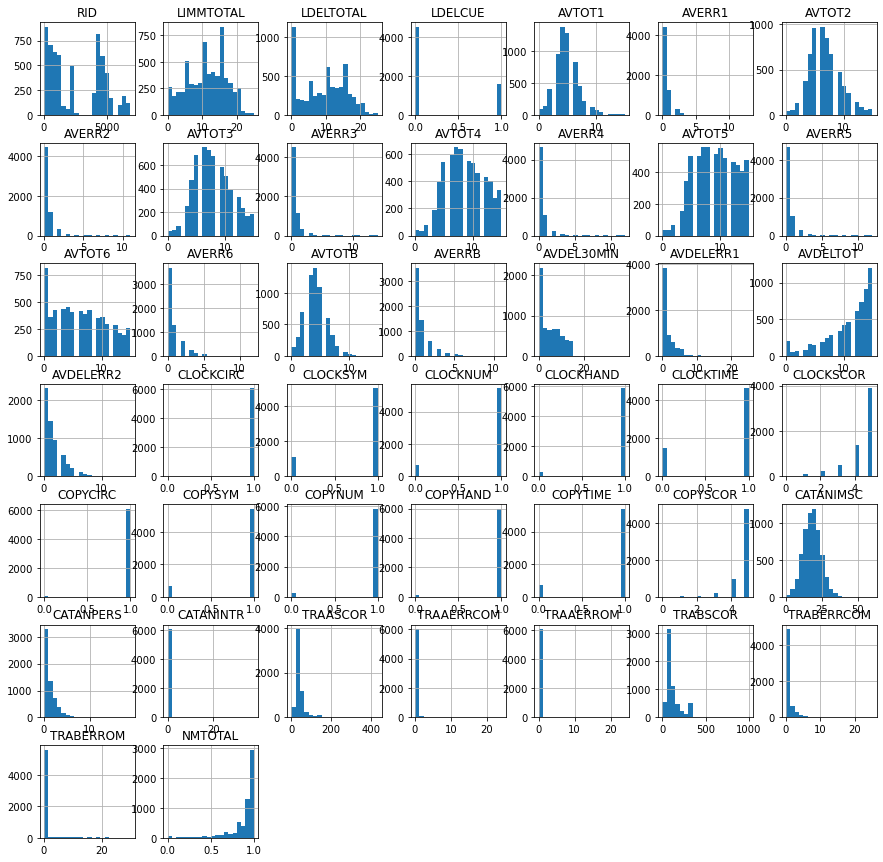

In [594]:
nb_complete.hist(figsize=(15,15),bins=20)
a=1

In [595]:
# How many entries did we lose to cleaning? 
# This is true only for the complete neuropsychological battery, not for individual sub-tests.
nb_finish_entries = nb_complete.shape[0]
dropped_entries = nb_start_entries - nb_finish_entries
print(dropped_entries)
print(np.round(dropped_entries/nb_start_entries*100, 2), '% removed')

8585
58.36 % removed


In [596]:
# Writing df to csv.
df = nb_complete
df.to_csv('../../data/tabular_data/clean_NEUROBAT.csv', index=False)